# Import Libraries



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install lazypredict
!pip install h2o
!pip install hdbscan

In [ ]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
import h2o
from h2o.automl import H2OAutoML
import random
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import lightgbm as lgb
import time
from skimage.feature import graycomatrix, graycoprops
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from lazypredict.Supervised import LazyClassifier

In [ ]:
cd '/content/drive/MyDrive/ML/final_project2'

/content/drive/MyDrive/ML/final_project2


# Load and Prepare Dataset

load features , csv files , Images

**Download and unzip Dataset**

In [ ]:
!gdown 1tKCABslGetwXq9pp9pKUCHIjBYNlpeaW

Downloading...
From: https://drive.google.com/uc?id=1tKCABslGetwXq9pp9pKUCHIjBYNlpeaW
To: /content/dataset_ml.zip
100% 2.23G/2.23G [00:27<00:00, 80.7MB/s]


In [ ]:
!unzip -qq "./dataset_ml.zip"

**Read Data**

In [ ]:
#read features



# Set the random seed for reproducibility
random_seed = 123
random.seed(random_seed)

real_folder = './/real'
fake_folder = './fake'

# Read all files in the real and fake folders
real_files = [os.path.join(real_folder, file) for file in os.listdir(real_folder)]
fake_files = [os.path.join(fake_folder, file) for file in os.listdir(fake_folder)]

# Create the dataset
dataset = [(file, 'Real') for file in real_files] + [(file, 'Fake') for file in fake_files]

# Shuffle the dataset
random.shuffle(dataset)

In [ ]:

# Assuming your dataframe is called `df` with the filename values in column 0
df = pd.read_csv('Features/labels.csv', header=None)
df = df.rename(columns={0: 'filename'})

# Extracting 'real/fake' information
df['real_fake'] = df['filename'].apply(lambda x: 'real' if 'real' in x else 'fake')

# Extracting 'jungle/sea/mountain' information
categories = ['jungle', 'sea', 'mountain']
df['category'] = df['filename'].apply(lambda x: next((cat for cat in categories if cat in x), None))

print(df)
df.to_csv('new_labels.csv')

                                    filename real_fake  category
0       810101213_fake_stable_mountain_2.png      fake  mountain
1        810701006_fake_stable_jungle_2.jpeg      fake    jungle
2      810199494_fake_stable_mountain_4.jpeg      fake  mountain
3          810199567_real_none_jungle_6.jpeg      real    jungle
4           810101149_real_none_jungle_1.jpg      real    jungle
...                                      ...       ...       ...
3413  810101201_fake_dallemini_jungle_5.jpeg      fake    jungle
3414    810198375_fake_stable_mountain_4.jpg      fake  mountain
3415   810199427_fake_stable_mountain_5.jpeg      fake  mountain
3416       810197636_real_none_jungle_7.jpeg      real    jungle
3417          150400011_real_none_sea_10.jpg      real       sea

[3418 rows x 3 columns]


In [ ]:


# Separate the features from the labels
features = pd.read_csv('Features/features.csv', header=None)
labels = pd.read_csv('new_labels.csv')

# Apply Min-Max scaling to the features
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)

# Create a new DataFrame with the normalized features and labels
normalized_df = pd.DataFrame(normalized_features, columns=features.columns)
normalized_df['Label'] = labels['real_fake']

# Split the normalized DataFrame into train, validation, and test sets
train_val_df, test_df = train_test_split(normalized_df, test_size=0.3, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit and transform the "Label" column in train_df
train_df['Label'] = label_encoder.fit_transform(train_df['Label'])

# Transform the "Label" column in val_df and test_df using the fitted encoder
val_df['Label'] = label_encoder.transform(val_df['Label'])
test_df['Label'] = label_encoder.transform(test_df['Label'])



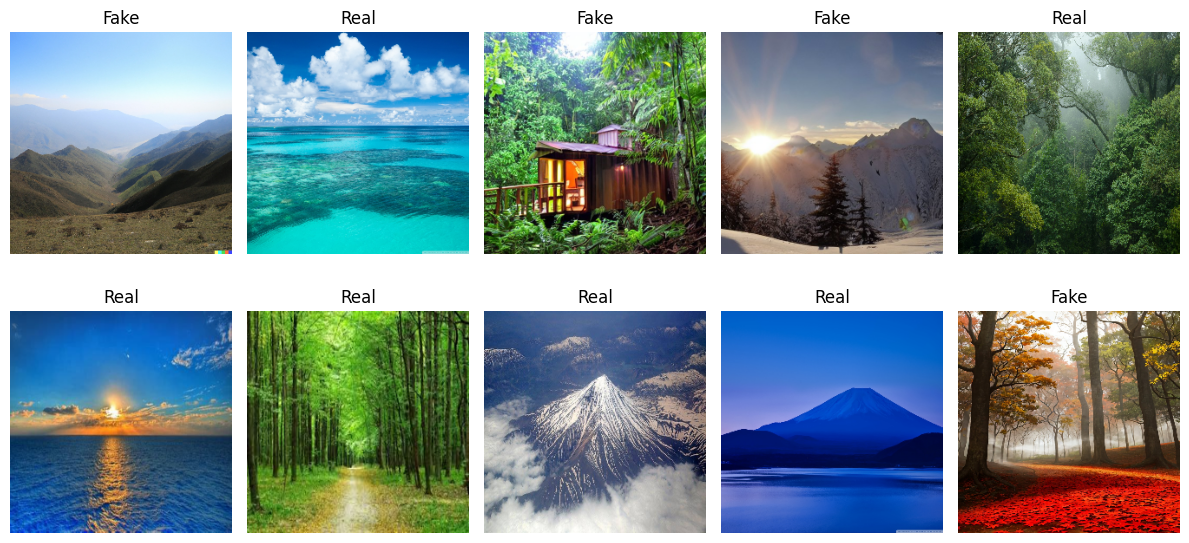

In [ ]:

# Display 10 random images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i in range(10):
    random_index = random.randint(0, len(dataset) - 1)
    file_path, label = dataset[random_index]

    # Read the image using cv2
    image = cv2.imread(file_path)

    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize the image to a square size
    target_size = (256, 256)
    image = cv2.resize(image, target_size)

    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(label)

plt.tight_layout()
plt.show()

# Clustering

In [ ]:
features_df = pd.read_csv('Features/features.csv', header=None)
labels_df = pd.read_csv('new_labels.csv')

In [ ]:
def perform_kmeans_clustering(features_df, labels_df, num_clusters, plot=True):
    # Step 1: Merge the features and labels dataframes
    merged_df = pd.merge(features_df, labels_df, left_index=True, right_index=True)

    # Step 2: Extract relevant columns
    real_fake = merged_df['real_fake']
    category = merged_df['category']

    # Step 3: Preprocess the feature data - Normalize the features
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features_df)

    # Step 4: Perform K-means clustering
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(scaled_features)

    # Step 5: Analyze the clusters
    cluster_labels = kmeans.labels_

    # Calculate Silhouette score
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)

    # Create a new dataframe with cluster labels and original labels
    clustered_data = pd.DataFrame({'Cluster': cluster_labels, 'Real_Fake': real_fake, 'Category': category})

    # Print Silhouette score
    print(f"Silhouette Score for {num_clusters} Clusters: {silhouette_avg}")

    # Iterate over clusters
    for i in range(num_clusters):
        print(f"\nCluster {i}:")
        cluster_data = clustered_data[clustered_data['Cluster'] == i]

        # Count the occurrences of each unique value in 'Real_Fake' column
        real_fake_counts = cluster_data['Real_Fake'].value_counts()
        print("Real vs. Fake:")
        print(real_fake_counts)

        # Count the occurrences of each unique value in 'Category' column
        category_counts = cluster_data['Category'].value_counts()
        print("\nCategory:")
        print(category_counts)

        # Plot bar charts for label counts within the cluster if plot=True
        if plot:
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].bar(real_fake_counts.index.astype(str), real_fake_counts.values)
            axes[0].set_title(f'Cluster {i}: Real vs. Fake')

            axes[1].bar(category_counts.index.astype(str), category_counts.values)
            axes[1].set_title(f'Cluster {i}: Category')

            plt.tight_layout()
            plt.show()



Silhouette Score for 2 Clusters: 0.340332639856897

Cluster 0:
Real vs. Fake:
fake    1639
real       3
Name: Real_Fake, dtype: int64

Category:
mountain    545
sea         530
jungle      498
Name: Category, dtype: int64


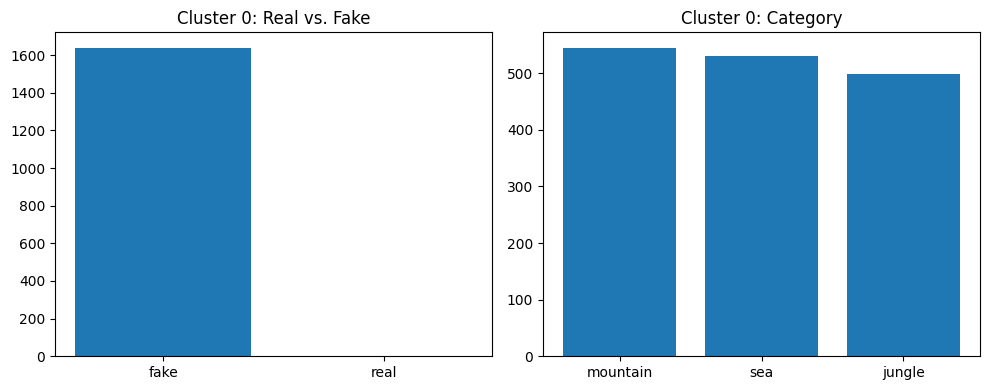


Cluster 1:
Real vs. Fake:
real    1675
fake     101
Name: Real_Fake, dtype: int64

Category:
mountain    575
sea         570
jungle      559
Name: Category, dtype: int64


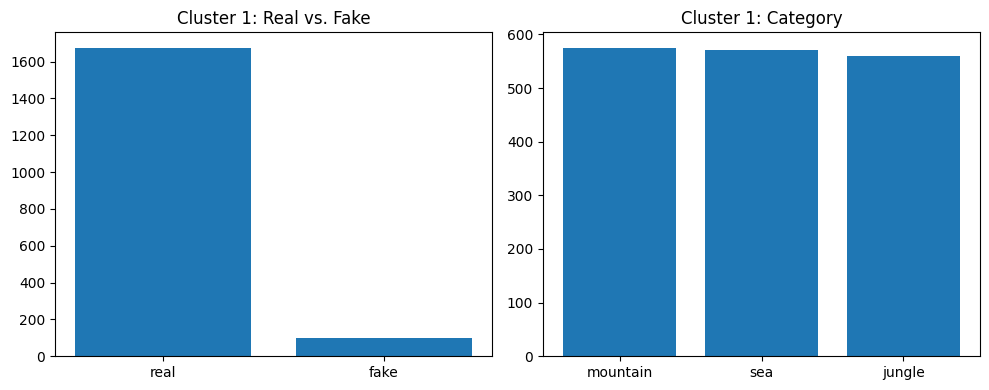

In [ ]:
perform_kmeans_clustering(features_df, labels_df, 2)

Silhouette Score for 3 Clusters: 0.26732381930414895

Cluster 0:
Real vs. Fake:
fake    1382
Name: Real_Fake, dtype: int64

Category:
mountain    478
sea         444
jungle      405
Name: Category, dtype: int64


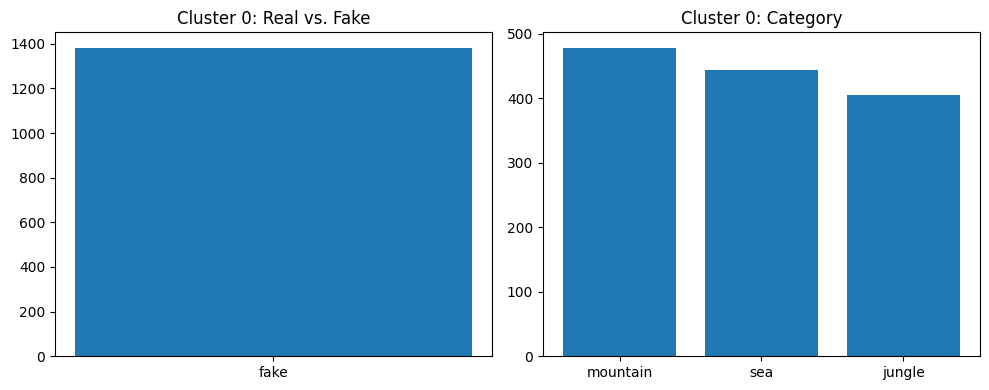


Cluster 1:
Real vs. Fake:
real    958
fake    344
Name: Real_Fake, dtype: int64

Category:
sea         541
mountain    448
jungle      264
Name: Category, dtype: int64


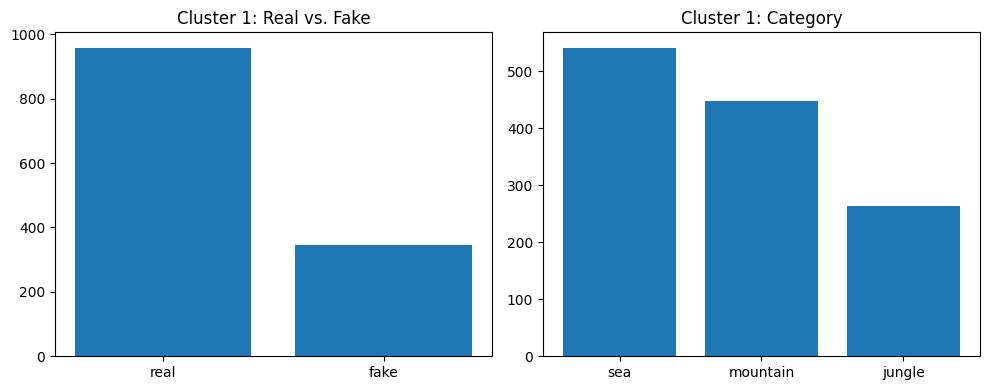


Cluster 2:
Real vs. Fake:
real    720
fake     14
Name: Real_Fake, dtype: int64

Category:
jungle      388
mountain    194
sea         115
Name: Category, dtype: int64


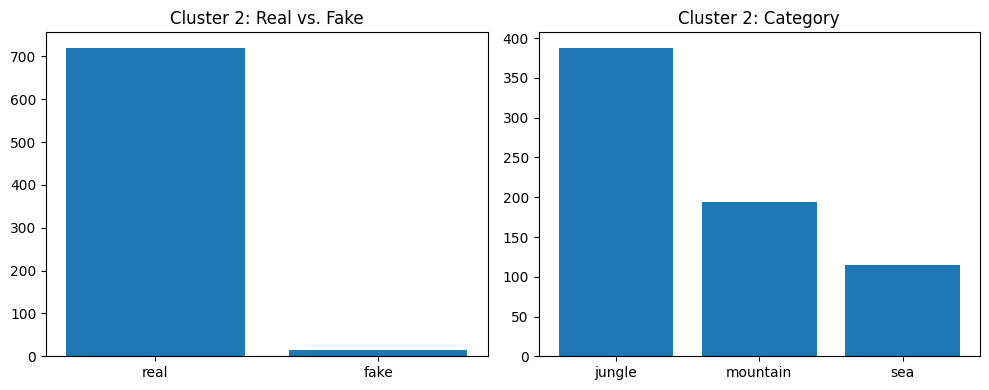

In [ ]:
perform_kmeans_clustering(features_df, labels_df, 3)


Silhouette Score for 6 Clusters: 0.20700614642138343

Cluster 0:
Real vs. Fake:
fake    886
Name: Real_Fake, dtype: int64

Category:
mountain    338
sea         285
jungle      217
Name: Category, dtype: int64


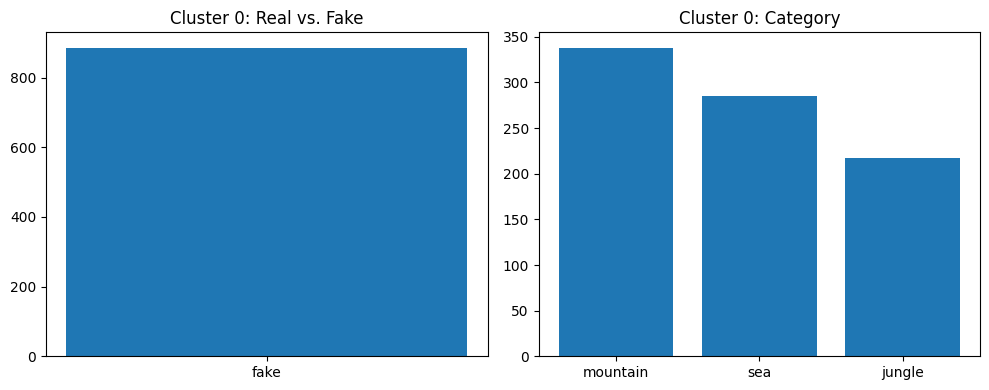


Cluster 1:
Real vs. Fake:
real    673
fake    167
Name: Real_Fake, dtype: int64

Category:
sea         403
mountain    263
jungle      141
Name: Category, dtype: int64


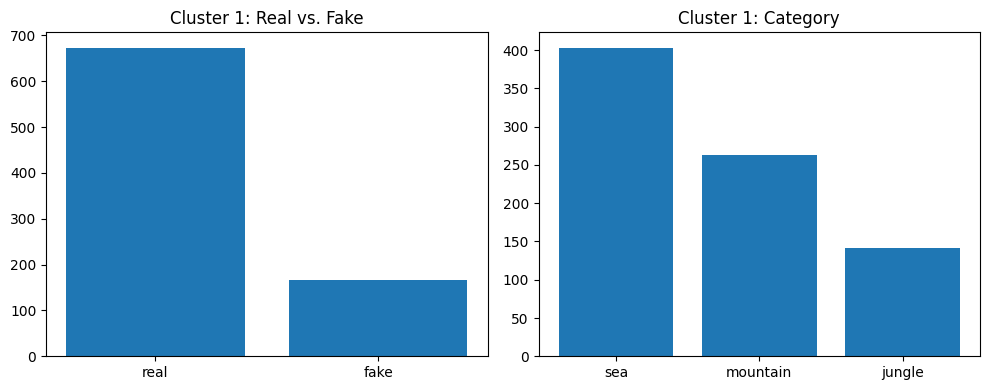


Cluster 2:
Real vs. Fake:
fake    411
Name: Real_Fake, dtype: int64

Category:
jungle      165
sea         120
mountain    116
Name: Category, dtype: int64


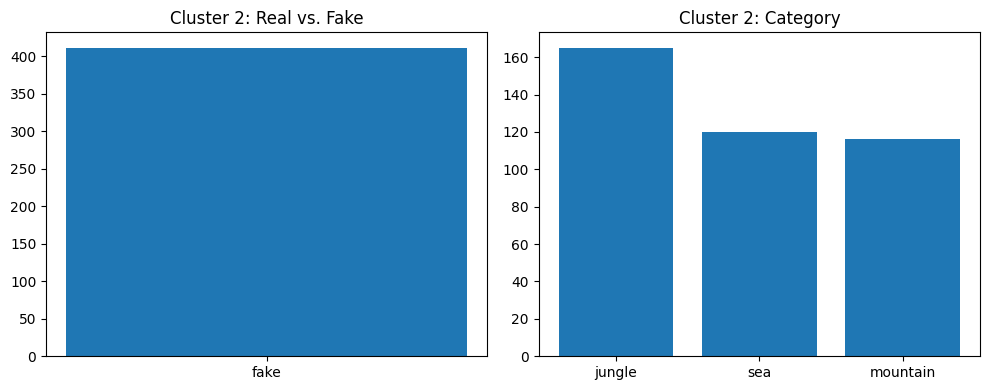


Cluster 3:
Real vs. Fake:
fake    256
Name: Real_Fake, dtype: int64

Category:
sea         102
jungle       84
mountain     67
Name: Category, dtype: int64


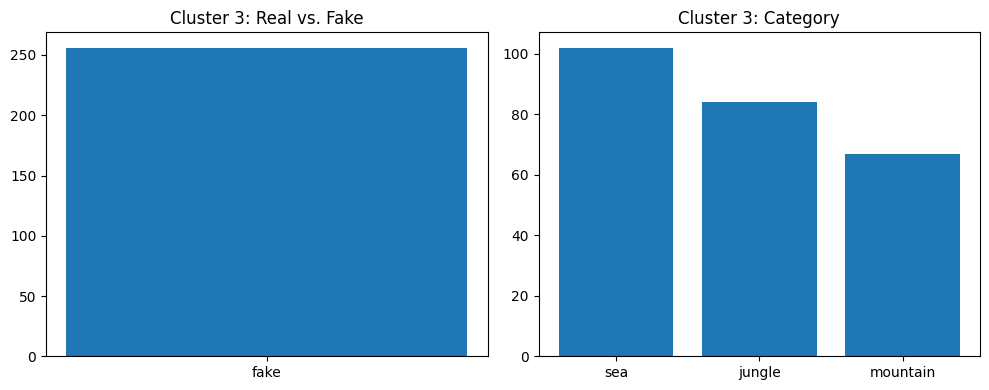


Cluster 4:
Real vs. Fake:
real    282
fake     10
Name: Real_Fake, dtype: int64

Category:
jungle      211
mountain     41
sea          20
Name: Category, dtype: int64


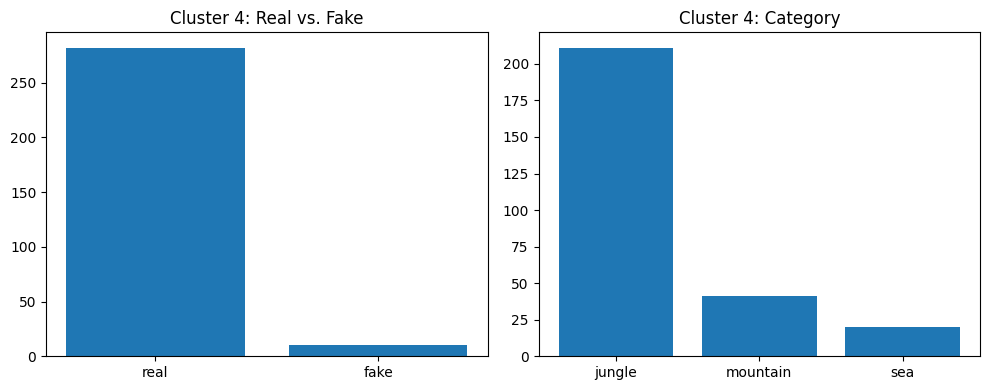


Cluster 5:
Real vs. Fake:
real    723
fake     10
Name: Real_Fake, dtype: int64

Category:
mountain    295
jungle      239
sea         170
Name: Category, dtype: int64


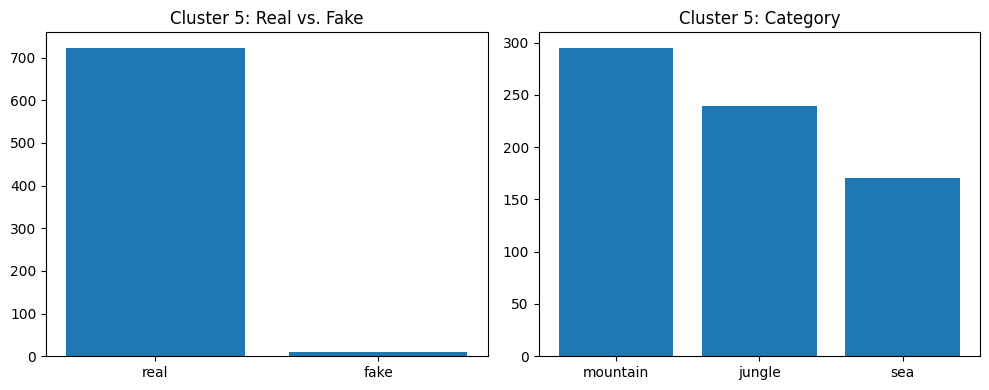

In [ ]:
perform_kmeans_clustering(features_df, labels_df, 6)


Silhouette Score for 9 Clusters: 0.20507248791953347

Cluster 0:
Real vs. Fake:
fake    249
Name: Real_Fake, dtype: int64

Category:
sea         100
jungle       82
mountain     63
Name: Category, dtype: int64


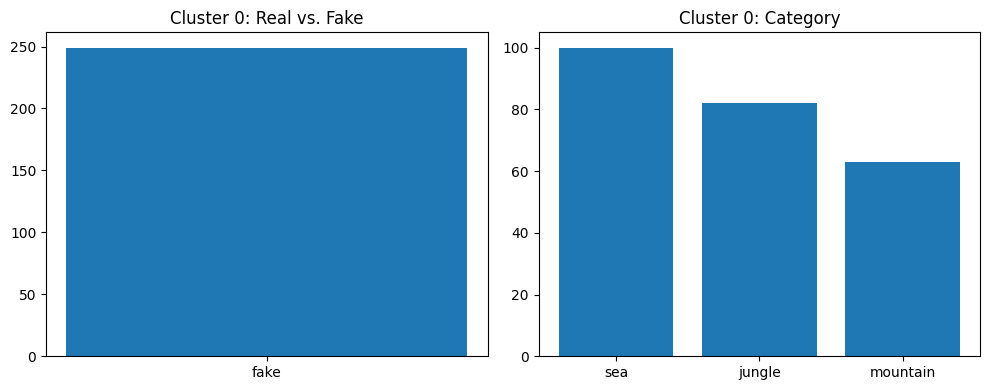


Cluster 1:
Real vs. Fake:
real    237
Name: Real_Fake, dtype: int64

Category:
mountain    180
sea          35
jungle       19
Name: Category, dtype: int64


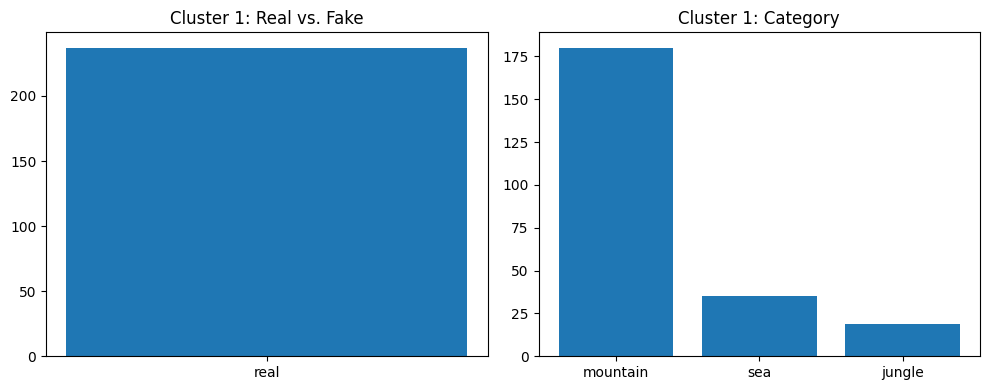


Cluster 2:
Real vs. Fake:
fake    341
Name: Real_Fake, dtype: int64

Category:
jungle      158
sea         101
mountain     74
Name: Category, dtype: int64


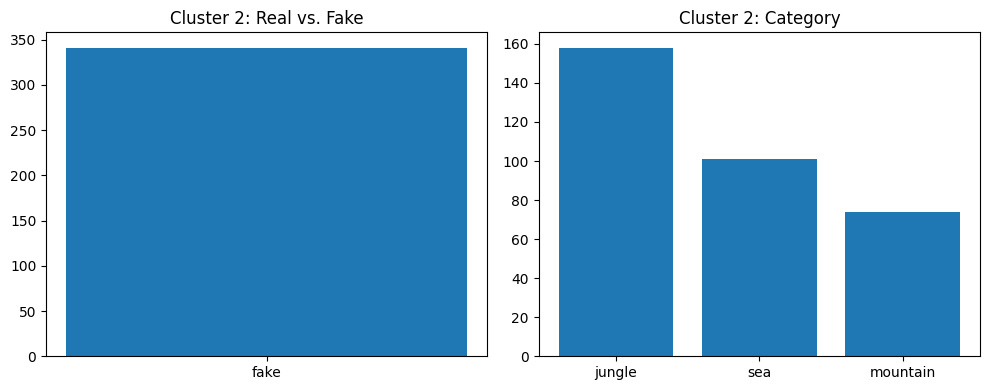


Cluster 3:
Real vs. Fake:
real    479
fake     10
Name: Real_Fake, dtype: int64

Category:
jungle      272
sea         113
mountain     78
Name: Category, dtype: int64


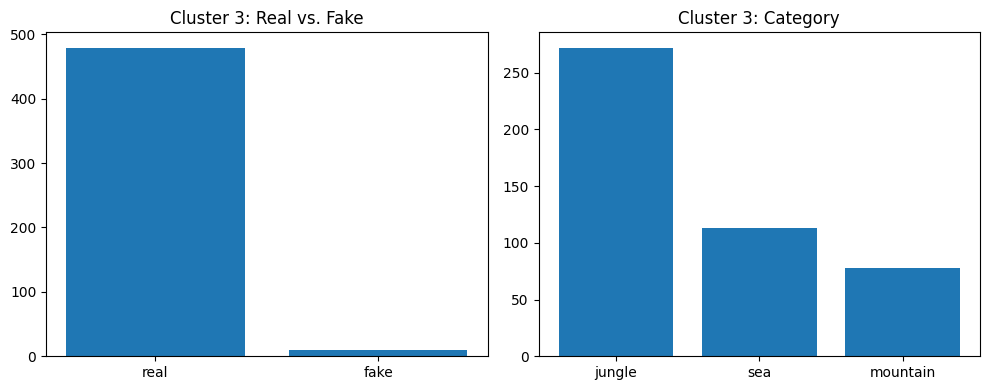


Cluster 4:
Real vs. Fake:
fake    565
real      3
Name: Real_Fake, dtype: int64

Category:
jungle      204
mountain    178
sea         151
Name: Category, dtype: int64


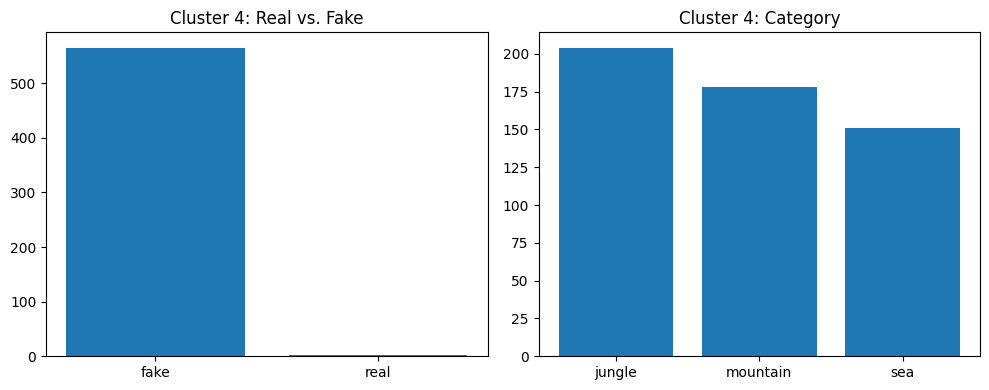


Cluster 5:
Real vs. Fake:
fake    111
Name: Real_Fake, dtype: int64

Category:
mountain    47
sea         33
jungle      28
Name: Category, dtype: int64


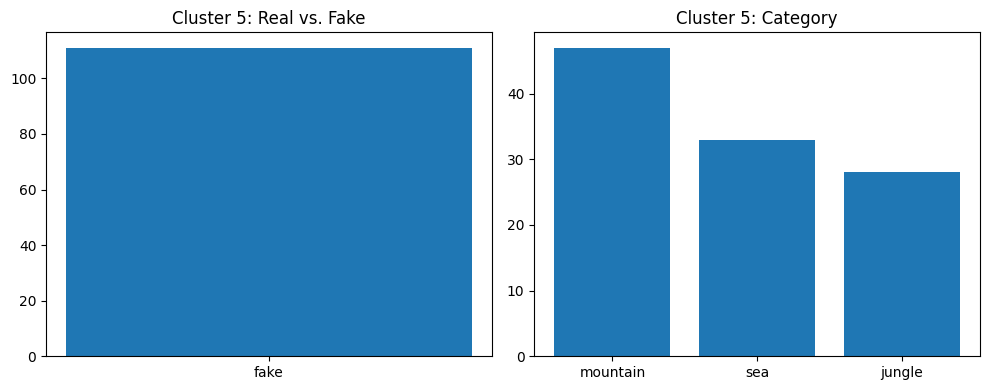


Cluster 6:
Real vs. Fake:
real    173
fake      6
Name: Real_Fake, dtype: int64

Category:
jungle      142
mountain     18
sea           4
Name: Category, dtype: int64


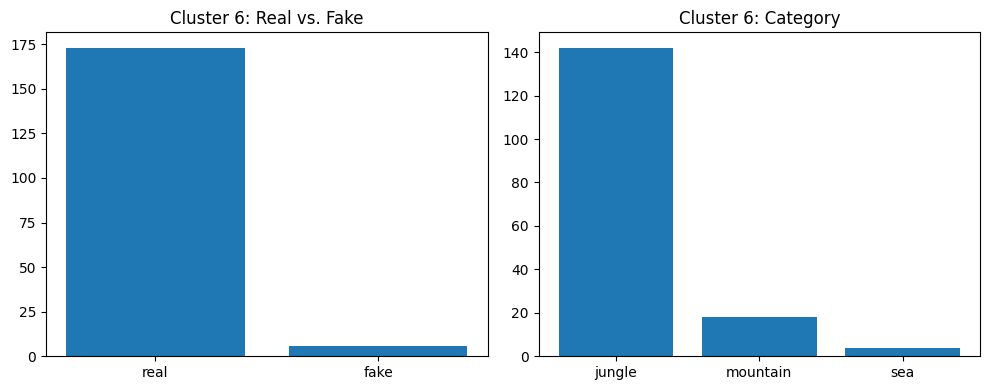


Cluster 7:
Real vs. Fake:
fake    393
Name: Real_Fake, dtype: int64

Category:
mountain    186
sea         151
jungle       37
Name: Category, dtype: int64


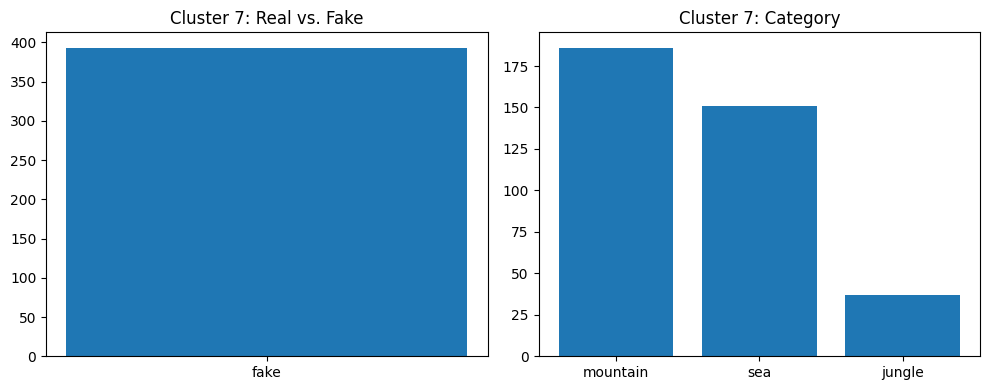


Cluster 8:
Real vs. Fake:
real    786
fake     65
Name: Real_Fake, dtype: int64

Category:
sea         412
mountain    296
jungle      115
Name: Category, dtype: int64


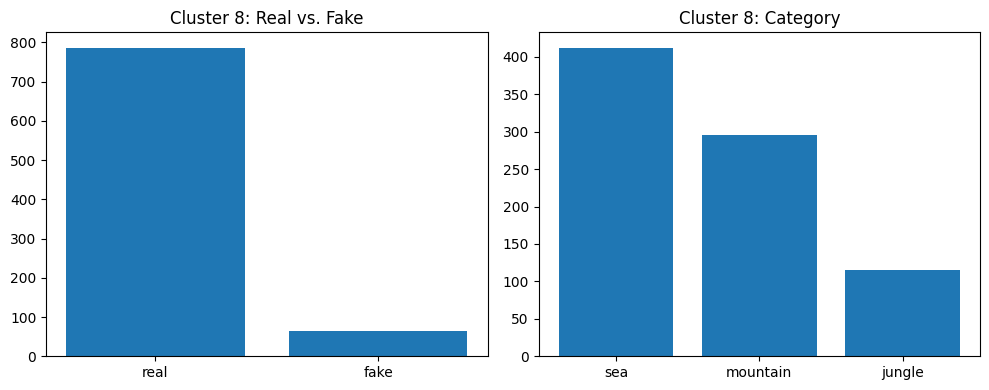

In [ ]:
perform_kmeans_clustering(features_df, labels_df, 9)


In [ ]:
perform_kmeans_clustering(features_df, labels_df, 50, plot=False)

Silhouette Score for 50 Clusters: 0.11294932852955

Cluster 0:
Real vs. Fake:
fake    121
Name: Real_Fake, dtype: int64

Category:
jungle      71
sea         24
mountain    22
Name: Category, dtype: int64

Cluster 1:
Real vs. Fake:
real    36
Name: Real_Fake, dtype: int64

Category:
sea         23
mountain    11
jungle       2
Name: Category, dtype: int64

Cluster 2:
Real vs. Fake:
fake    163
real      4
Name: Real_Fake, dtype: int64

Category:
jungle      73
mountain    42
sea         39
Name: Category, dtype: int64

Cluster 3:
Real vs. Fake:
real    67
fake     1
Name: Real_Fake, dtype: int64

Category:
jungle      48
mountain    14
sea          3
Name: Category, dtype: int64

Cluster 4:
Real vs. Fake:
real    117
Name: Real_Fake, dtype: int64

Category:
jungle      103
mountain      3
sea           2
Name: Category, dtype: int64

Cluster 5:
Real vs. Fake:
fake    67
Name: Real_Fake, dtype: int64

Category:
mountain    34
sea         28
jungle       3
Name: Category, dtype: int64

C

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

def perform_gmm_clustering(features_df, labels_df, num_clusters, plot=True):
    # Step 1: Merge the features and labels dataframes
    merged_df = pd.merge(features_df, labels_df, left_index=True, right_index=True)

    # Step 2: Extract relevant columns
    real_fake = merged_df['real_fake']
    category = merged_df['category']

    # Step 3: Preprocess the feature data - Normalize the features
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features_df)

    # Step 4: Perform GMM clustering
    gmm = GaussianMixture(n_components=num_clusters)
    gmm.fit(scaled_features)

    # Step 5: Analyze the clusters
    cluster_labels = gmm.predict(scaled_features)

    # Calculate Silhouette score
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)

    # Create a new dataframe with cluster labels and original labels
    clustered_data = pd.DataFrame({'Cluster': cluster_labels, 'Real_Fake': real_fake, 'Category': category})

    # Print Silhouette score
    print(f"Silhouette Score for {num_clusters} Clusters: {silhouette_avg}")

    # Iterate over clusters
    for i in range(num_clusters):
        print(f"\nCluster {i}:")
        cluster_data = clustered_data[clustered_data['Cluster'] == i]

        # Count the occurrences of each unique value in 'Real_Fake' column
        real_fake_counts = cluster_data['Real_Fake'].value_counts()
        print("Real vs. Fake:")
        print(real_fake_counts)

        # Count the occurrences of each unique value in 'Category' column
        category_counts = cluster_data['Category'].value_counts()
        print("\nCategory:")
        print(category_counts)

        # Plot bar charts for label counts within the cluster if plot=True
        if plot:
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].bar(real_fake_counts.index.astype(str), real_fake_counts.values)
            axes[0].set_title(f'Cluster {i}: Real vs. Fake')

            axes[1].bar(category_counts.index.astype(str), category_counts.values)
            axes[1].set_title(f'Cluster {i}: Category')

            plt.tight_layout()
            plt.show()



Silhouette Score for 2 Clusters: 0.3401770154797122

Cluster 0:
Real vs. Fake:
fake    1642
real       3
Name: Real_Fake, dtype: int64

Category:
mountain    545
sea         533
jungle      498
Name: Category, dtype: int64


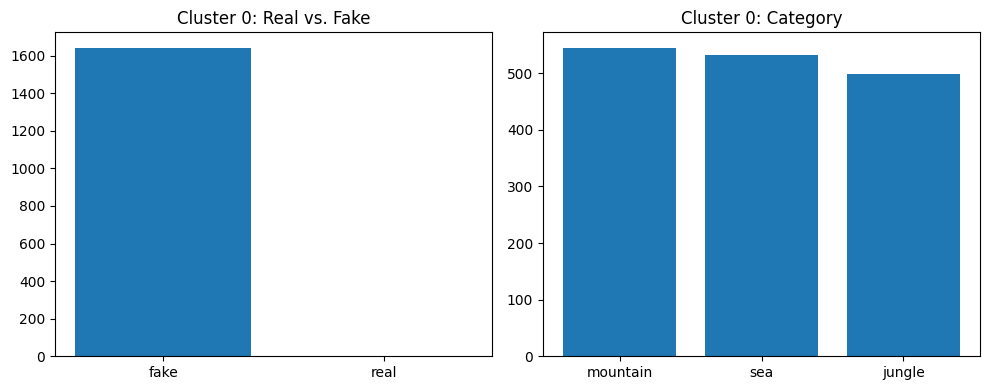


Cluster 1:
Real vs. Fake:
real    1675
fake      98
Name: Real_Fake, dtype: int64

Category:
mountain    575
sea         567
jungle      559
Name: Category, dtype: int64


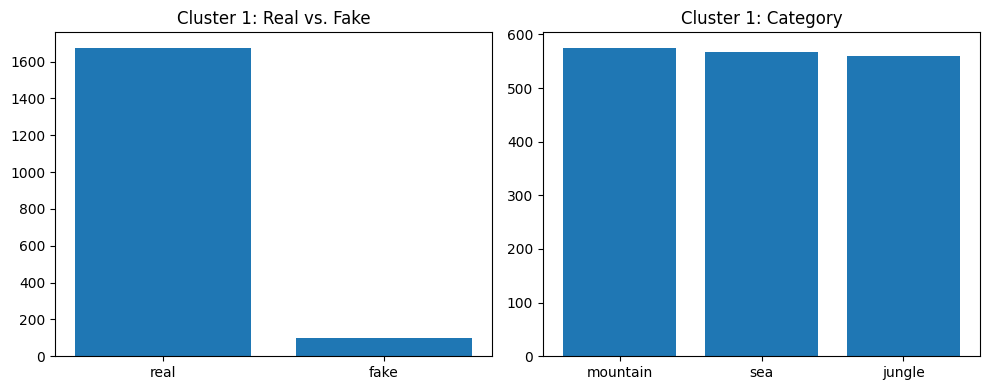

In [ ]:
perform_gmm_clustering(features_df, labels_df, 2)


Silhouette Score for 3 Clusters: 0.2668786857219711

Cluster 0:
Real vs. Fake:
real    724
fake     14
Name: Real_Fake, dtype: int64

Category:
jungle      391
mountain    195
sea         115
Name: Category, dtype: int64


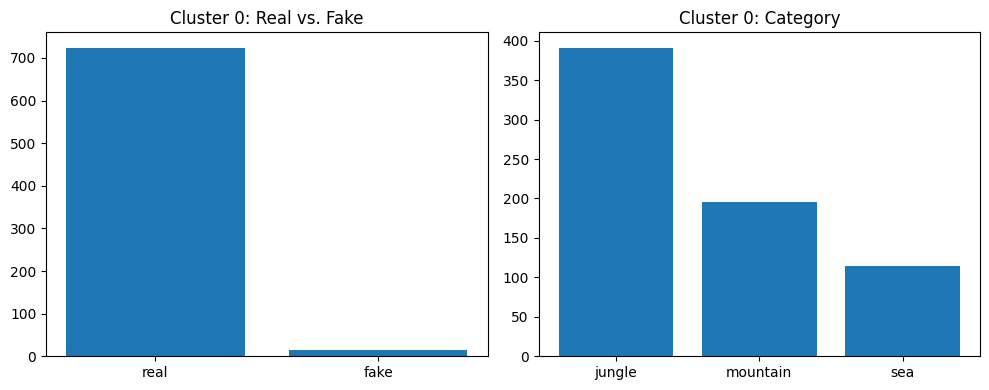


Cluster 1:
Real vs. Fake:
real    954
fake    345
Name: Real_Fake, dtype: int64

Category:
sea         541
mountain    447
jungle      262
Name: Category, dtype: int64


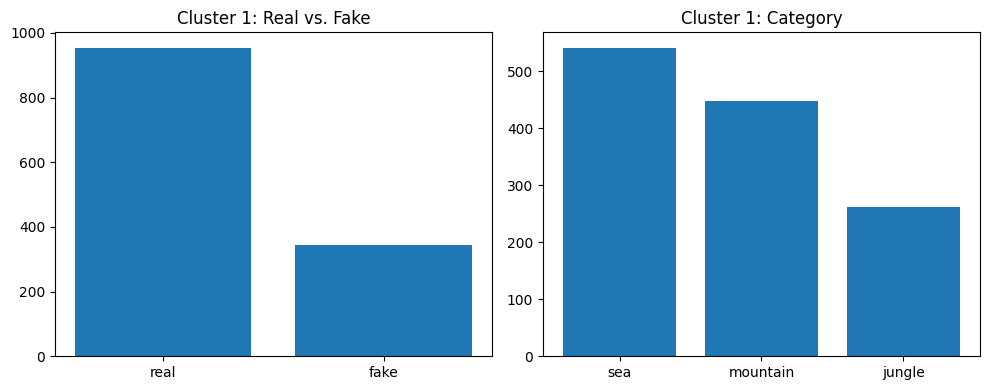


Cluster 2:
Real vs. Fake:
fake    1381
Name: Real_Fake, dtype: int64

Category:
mountain    478
sea         444
jungle      404
Name: Category, dtype: int64


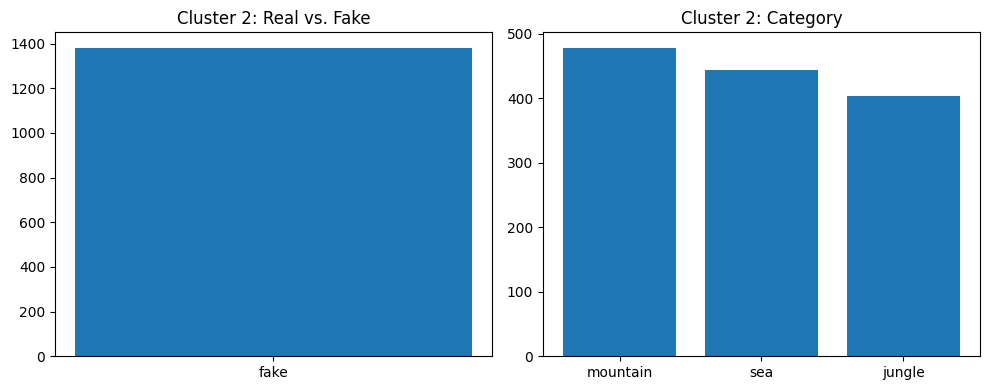

In [ ]:
perform_gmm_clustering(features_df, labels_df, 3)

Silhouette Score for 6 Clusters: 0.1868478147777128

Cluster 0:
Real vs. Fake:
real    832
fake     42
Name: Real_Fake, dtype: int64

Category:
sea         408
mountain    301
jungle      133
Name: Category, dtype: int64


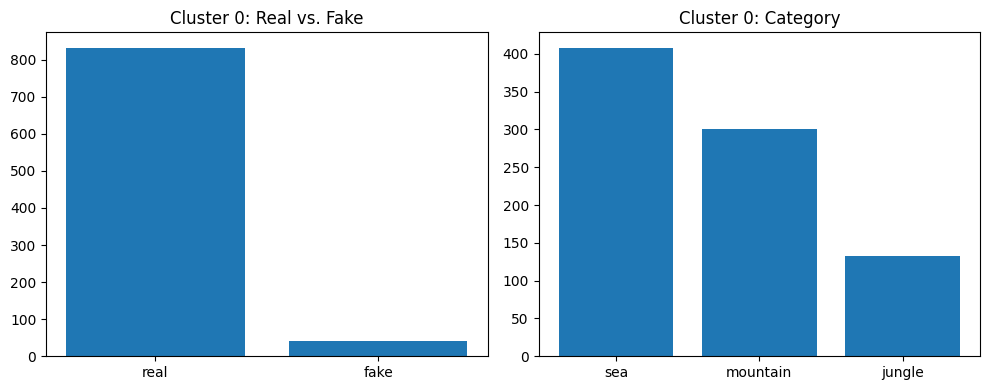


Cluster 1:
Real vs. Fake:
fake    419
Name: Real_Fake, dtype: int64

Category:
jungle      176
sea         119
mountain    115
Name: Category, dtype: int64


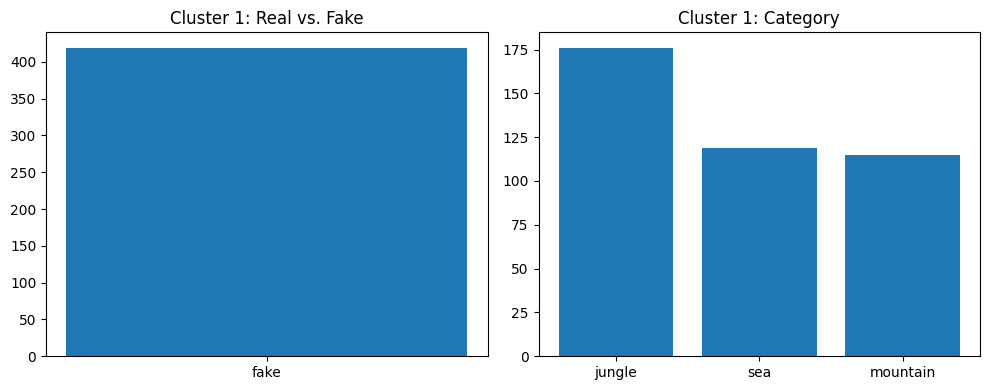


Cluster 2:
Real vs. Fake:
real    198
fake      7
Name: Real_Fake, dtype: int64

Category:
jungle      166
mountain     19
sea           4
Name: Category, dtype: int64


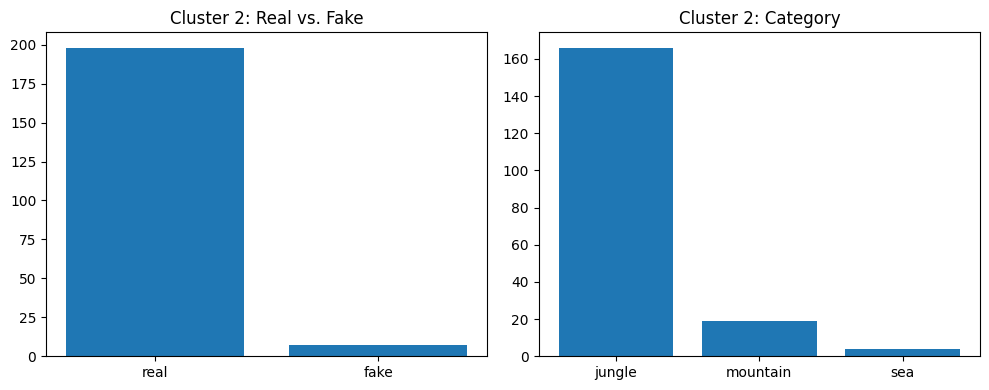


Cluster 3:
Real vs. Fake:
fake    724
Name: Real_Fake, dtype: int64

Category:
mountain    297
sea         245
jungle      146
Name: Category, dtype: int64


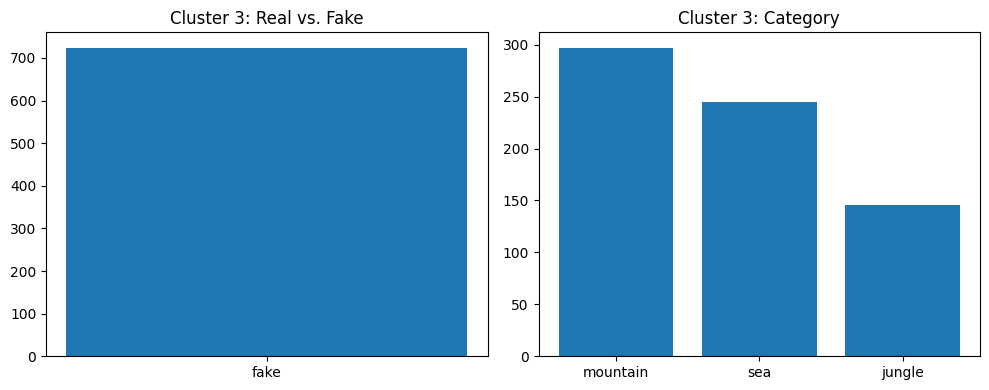


Cluster 4:
Real vs. Fake:
real    645
fake      7
Name: Real_Fake, dtype: int64

Category:
mountain    245
jungle      242
sea         141
Name: Category, dtype: int64


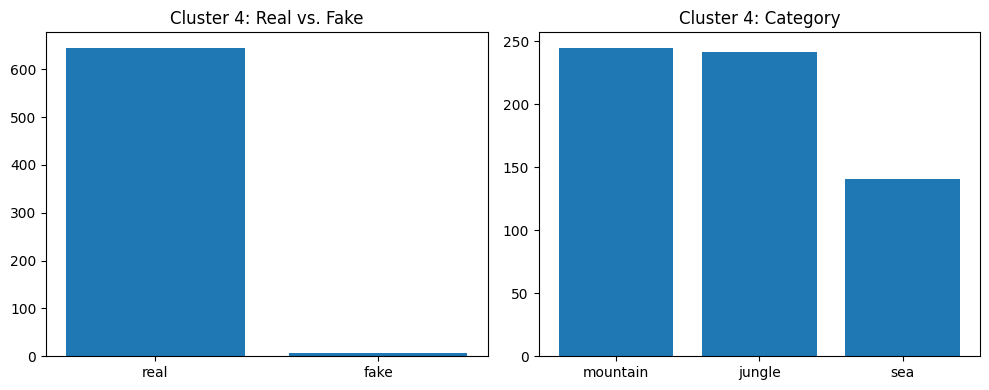


Cluster 5:
Real vs. Fake:
fake    541
real      3
Name: Real_Fake, dtype: int64

Category:
jungle      194
sea         183
mountain    143
Name: Category, dtype: int64


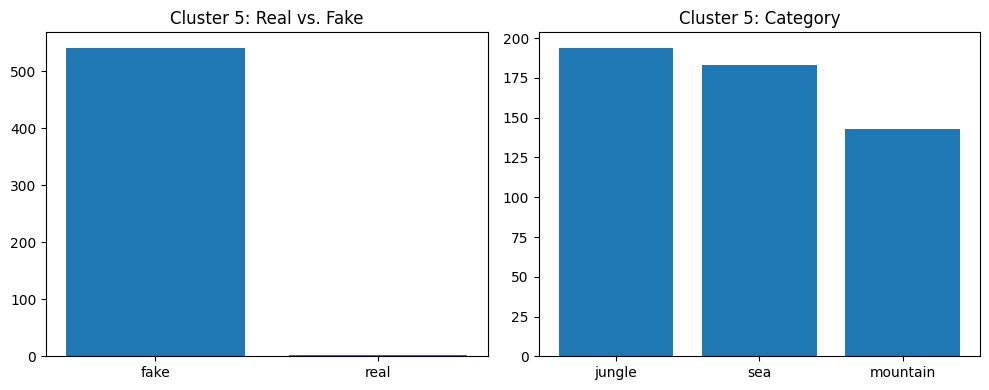

In [ ]:
perform_gmm_clustering(features_df, labels_df, 6)



Silhouette Score for 9 Clusters: 0.18240541678837072

Cluster 0:
Real vs. Fake:
fake    246
Name: Real_Fake, dtype: int64

Category:
sea         99
jungle      81
mountain    63
Name: Category, dtype: int64


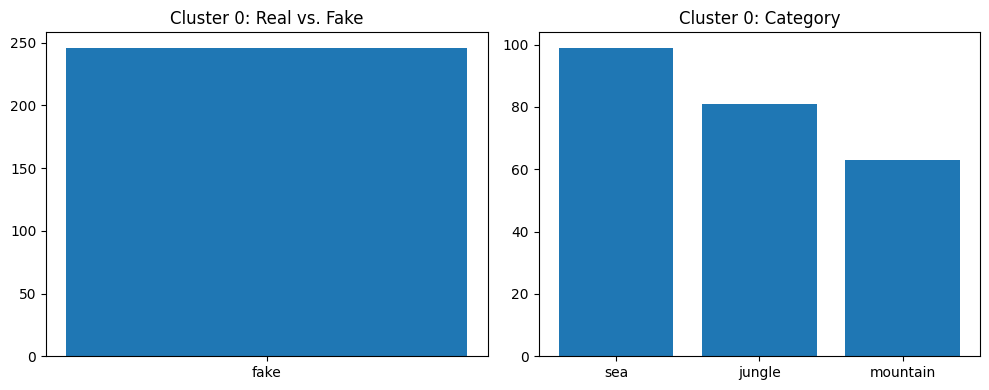


Cluster 1:
Real vs. Fake:
real    566
fake      7
Name: Real_Fake, dtype: int64

Category:
mountain    302
sea         136
jungle      120
Name: Category, dtype: int64


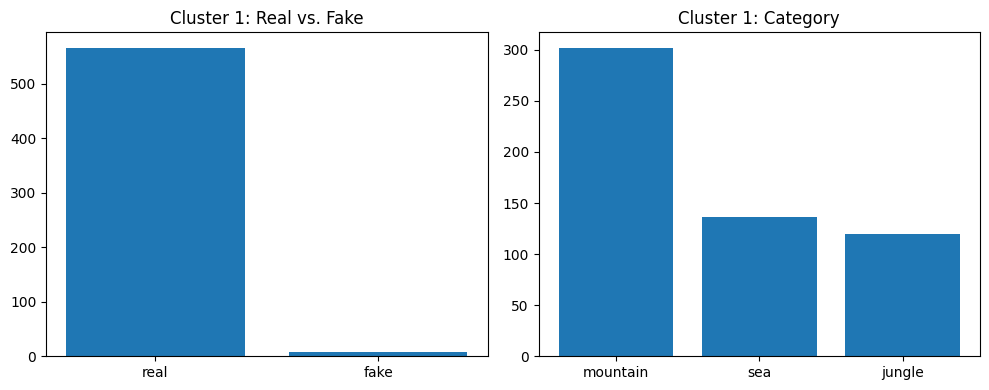


Cluster 2:
Real vs. Fake:
fake    410
Name: Real_Fake, dtype: int64

Category:
mountain    191
sea         159
jungle       41
Name: Category, dtype: int64


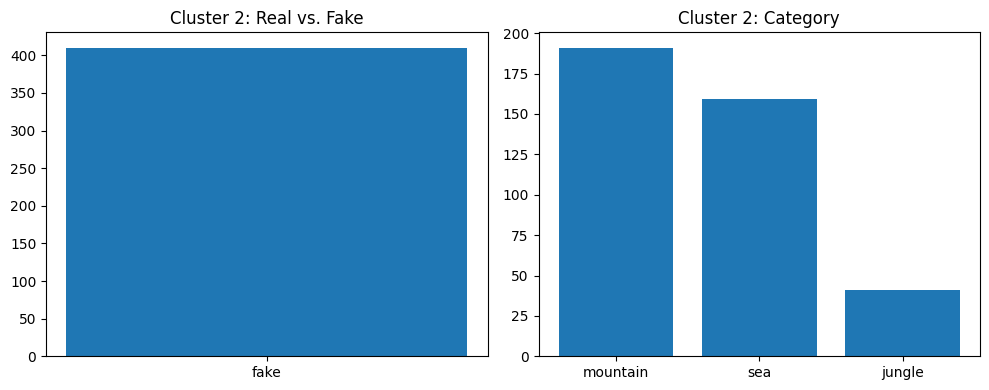


Cluster 3:
Real vs. Fake:
fake    312
Name: Real_Fake, dtype: int64

Category:
jungle      143
sea          98
mountain     64
Name: Category, dtype: int64


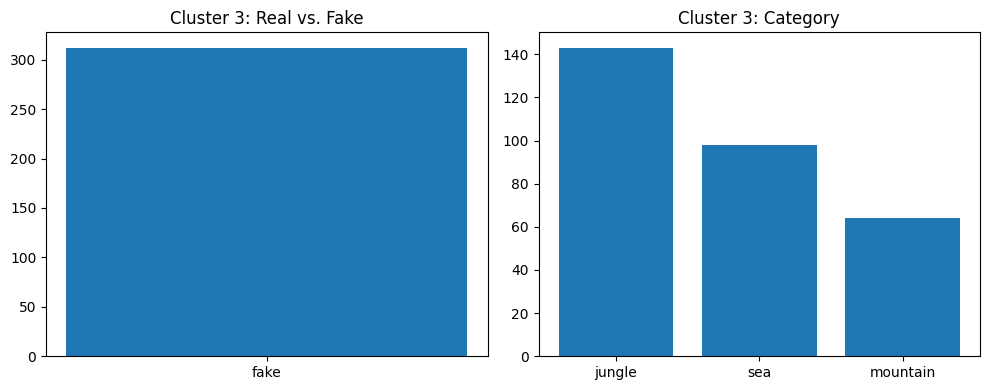


Cluster 4:
Real vs. Fake:
real    401
fake      9
Name: Real_Fake, dtype: int64

Category:
jungle      256
mountain     63
sea          63
Name: Category, dtype: int64


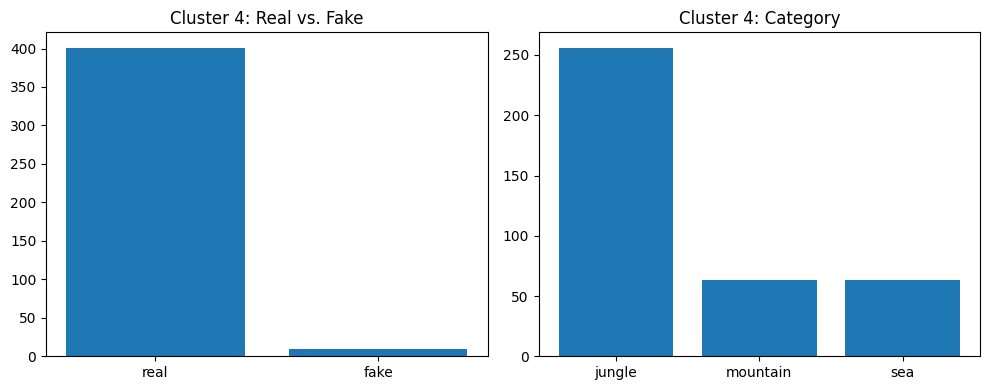


Cluster 5:
Real vs. Fake:
real    609
fake     78
Name: Real_Fake, dtype: int64

Category:
sea         368
mountain    198
jungle       95
Name: Category, dtype: int64


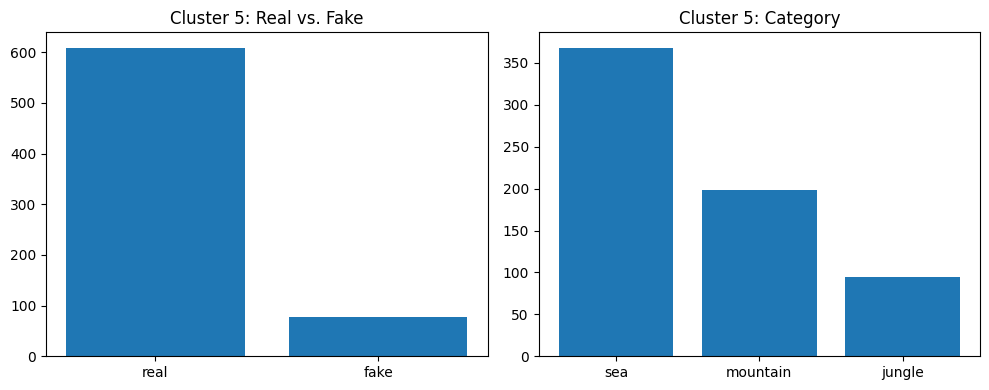


Cluster 6:
Real vs. Fake:
fake    582
real      2
Name: Real_Fake, dtype: int64

Category:
jungle      221
mountain    179
sea         150
Name: Category, dtype: int64


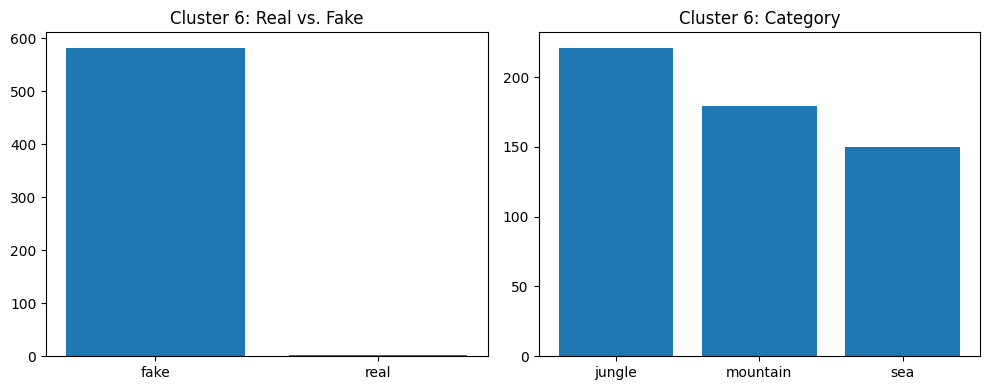


Cluster 7:
Real vs. Fake:
real    100
fake      4
Name: Real_Fake, dtype: int64

Category:
jungle      81
mountain    13
sea          4
Name: Category, dtype: int64


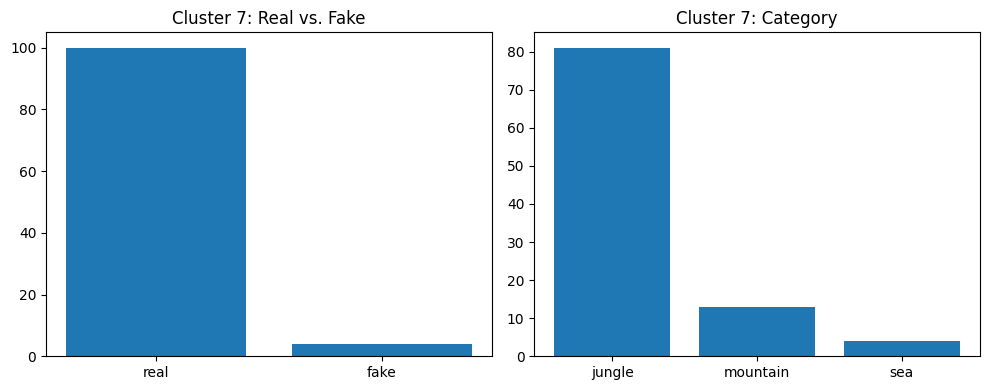


Cluster 8:
Real vs. Fake:
fake    92
Name: Real_Fake, dtype: int64

Category:
mountain    47
sea         23
jungle      19
Name: Category, dtype: int64


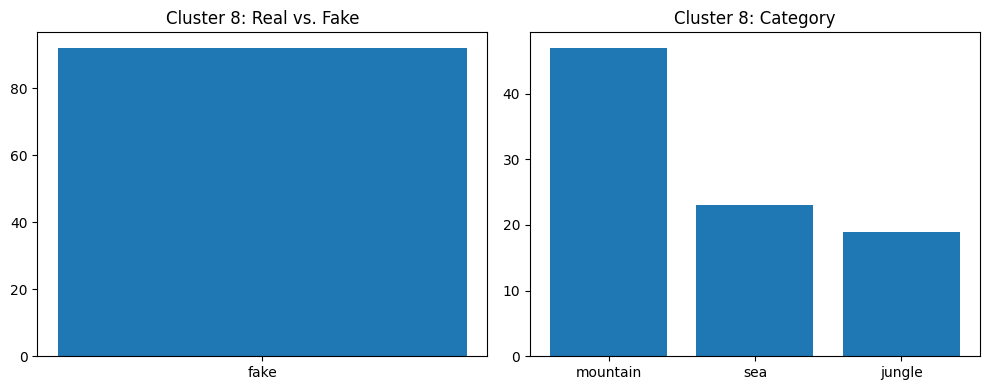

In [ ]:
perform_gmm_clustering(features_df, labels_df, 9)

In [ ]:
perform_gmm_clustering(features_df, labels_df, 50, plot=False)

Silhouette Score for 50 Clusters: 0.11160562176000884

Cluster 0:
Real vs. Fake:
fake    125
Name: Real_Fake, dtype: int64

Category:
mountain    61
sea         43
jungle      14
Name: Category, dtype: int64

Cluster 1:
Real vs. Fake:
real    200
fake     26
Name: Real_Fake, dtype: int64

Category:
sea         136
mountain     61
jungle       17
Name: Category, dtype: int64

Cluster 2:
Real vs. Fake:
real    24
fake     3
Name: Real_Fake, dtype: int64

Category:
jungle      20
mountain     2
sea          1
Name: Category, dtype: int64

Cluster 3:
Real vs. Fake:
real    70
Name: Real_Fake, dtype: int64

Category:
mountain    49
sea         12
jungle       9
Name: Category, dtype: int64

Cluster 4:
Real vs. Fake:
fake    87
Name: Real_Fake, dtype: int64

Category:
sea         38
mountain    30
jungle      15
Name: Category, dtype: int64

Cluster 5:
Real vs. Fake:
fake    147
Name: Real_Fake, dtype: int64

Category:
jungle      92
mountain    26
sea         24
Name: Category, dtype: int64

**Cluster k-Means on every Features**

In [ ]:

df = pd.read_csv('hist_features_64_64.csv')
df.rename(columns={'Label':'real_fake', 'Category':'category'}, inplace=True)
df1 = df.drop(['real_fake', 'category'], axis=1)
labels1 = df[['real_fake', 'category']].copy()
labels1['real_fake'] = labels1['real_fake'].str.lower()
df1.name = 'hist_features_64_64'

In [ ]:
df = pd.read_csv('lbp_features_64_64.csv')
df.rename(columns={'Label':'real_fake', 'Category':'category'}, inplace=True)
df2 = df.drop(['real_fake', 'category'], axis=1)
labels2 = df[['real_fake', 'category']].copy()
labels2['real_fake'] = labels1['real_fake'].str.lower()
df2.name = 'lbp_features_64_64'

In [ ]:
df = pd.read_csv('hog_features_64_64.csv')
df.rename(columns={'Label':'real_fake', 'Category':'category'}, inplace=True)
df3 = df.drop(['real_fake', 'category'], axis=1)
labels3 = df[['real_fake', 'category']].copy()
labels3['real_fake'] = labels1['real_fake'].str.lower()
df3.name = 'hog_features_64_64'

In [ ]:
df = pd.read_csv('glcm_features_64_64.csv')
df.rename(columns={'Label':'real_fake', 'Category':'category'}, inplace=True)
df4 = df.drop(['real_fake', 'category'], axis=1)
labels4 = df[['real_fake', 'category']].copy()
labels4['real_fake'] = labels1['real_fake'].str.lower()
df4.name = 'glcm_features_64_64'

In [ ]:
df = pd.read_csv('gabor_features_64_64.csv')
df.rename(columns={'Label':'real_fake', 'Category':'category'}, inplace=True)
df5 = df.drop(['real_fake', 'category'], axis=1)
labels5 = df[['real_fake', 'category']].copy()
labels5['real_fake'] = labels1['real_fake'].str.lower()
df5.name = 'gabor_features_64_64'

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 2 Clusters: 0.09645659911886657

Cluster 0:
Real vs. Fake:
fake    575
real    574
Name: Real_Fake, dtype: int64

Category:
jungle      874
mountain    158
sea          43
Name: Category, dtype: int64


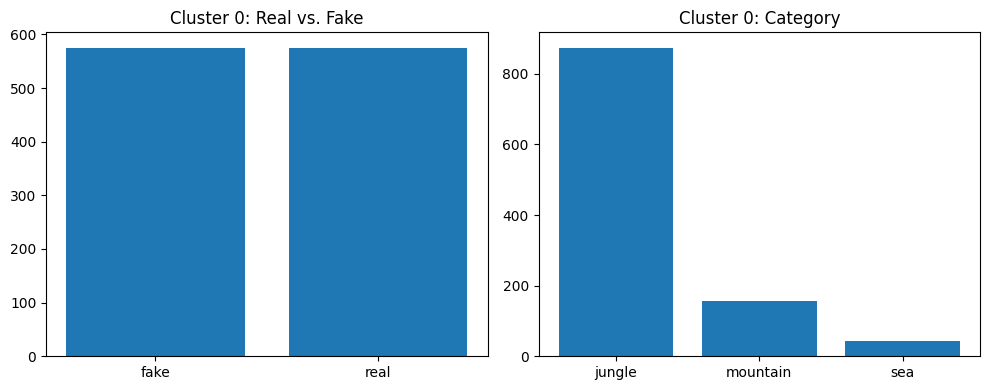


Cluster 1:
Real vs. Fake:
fake    1135
real    1133
Name: Real_Fake, dtype: int64

Category:
sea         1056
mountain     962
jungle       183
Name: Category, dtype: int64


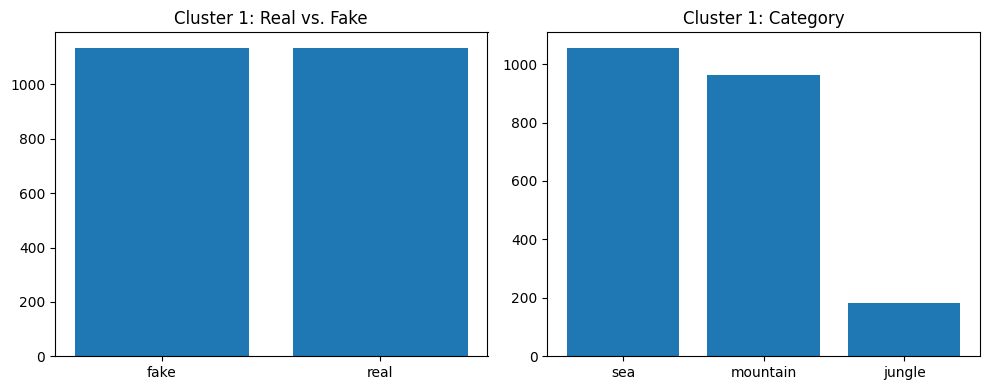

In [ ]:
perform_kmeans_clustering(df1, labels1, 2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 3 Clusters: 0.06392129357709256

Cluster 0:
Real vs. Fake:
fake    536
real    516
Name: Real_Fake, dtype: int64

Category:
mountain    545
sea         287
jungle      187
Name: Category, dtype: int64


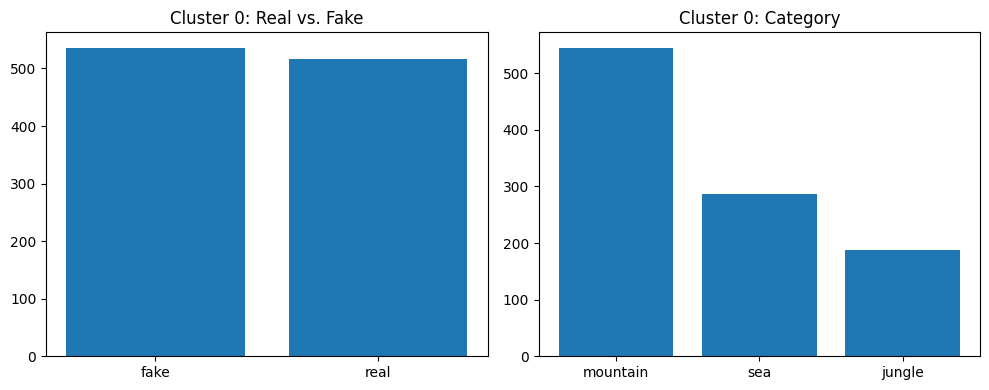


Cluster 1:
Real vs. Fake:
fake    509
real    496
Name: Real_Fake, dtype: int64

Category:
jungle      792
mountain    117
sea          31
Name: Category, dtype: int64


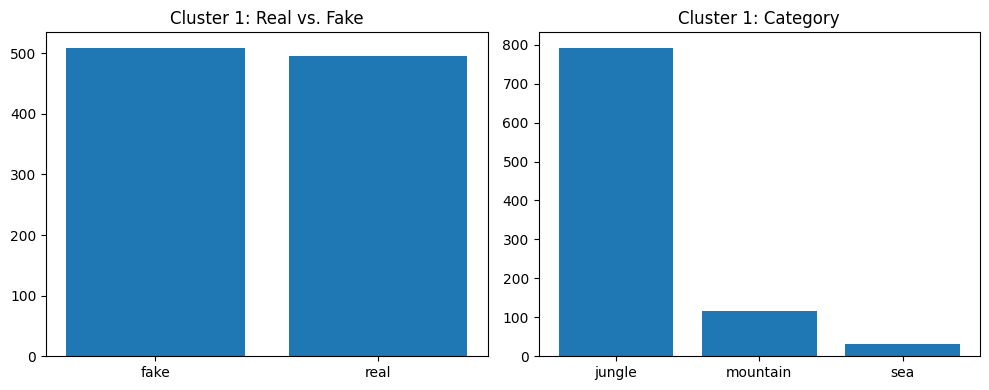


Cluster 2:
Real vs. Fake:
real    695
fake    665
Name: Real_Fake, dtype: int64

Category:
sea         781
mountain    458
jungle       78
Name: Category, dtype: int64


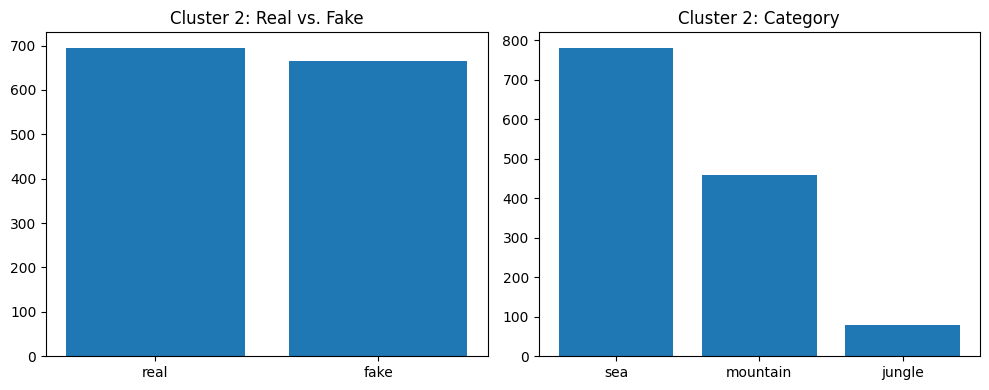

In [ ]:
perform_kmeans_clustering(df1, labels1, 3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 6 Clusters: 0.04059591116169582

Cluster 0:
Real vs. Fake:
fake    180
real    106
Name: Real_Fake, dtype: int64

Category:
jungle      259
mountain      7
Name: Category, dtype: int64


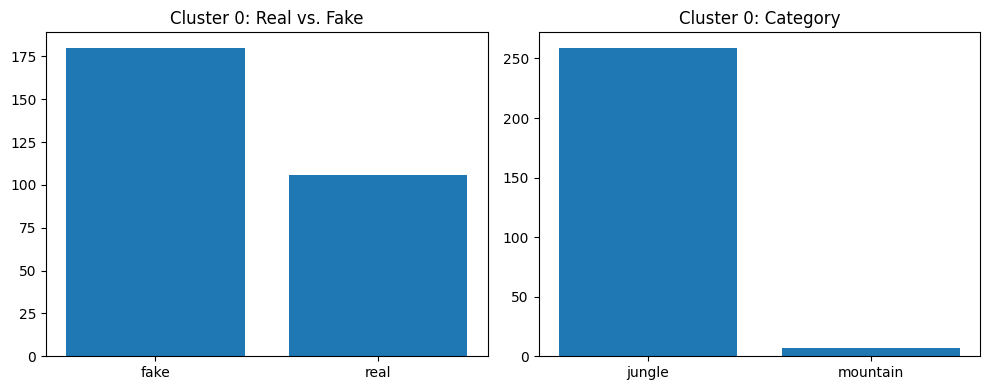


Cluster 1:
Real vs. Fake:
fake    425
real    387
Name: Real_Fake, dtype: int64

Category:
mountain    438
sea         254
jungle      100
Name: Category, dtype: int64


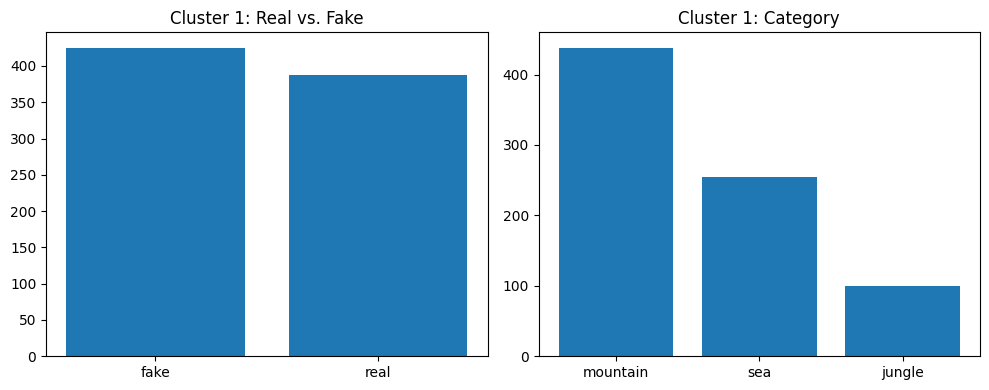


Cluster 2:
Real vs. Fake:
real    254
fake    247
Name: Real_Fake, dtype: int64

Category:
jungle      260
mountain    156
sea          76
Name: Category, dtype: int64


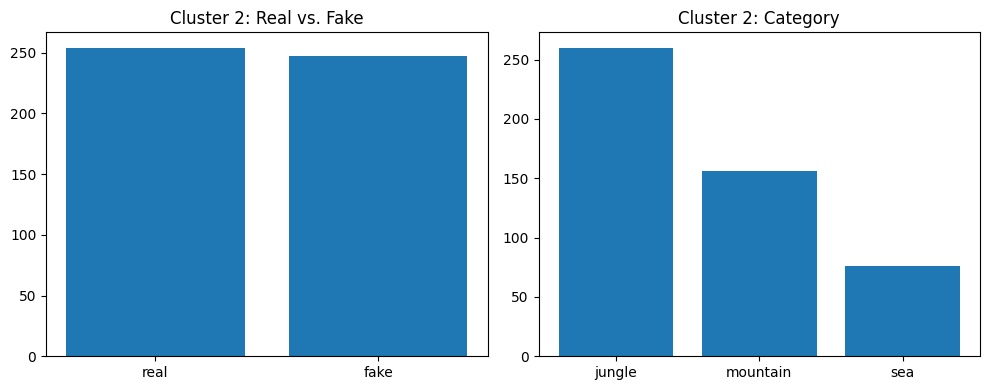


Cluster 3:
Real vs. Fake:
real    245
fake    177
Name: Real_Fake, dtype: int64

Category:
jungle      299
mountain     73
sea          11
Name: Category, dtype: int64


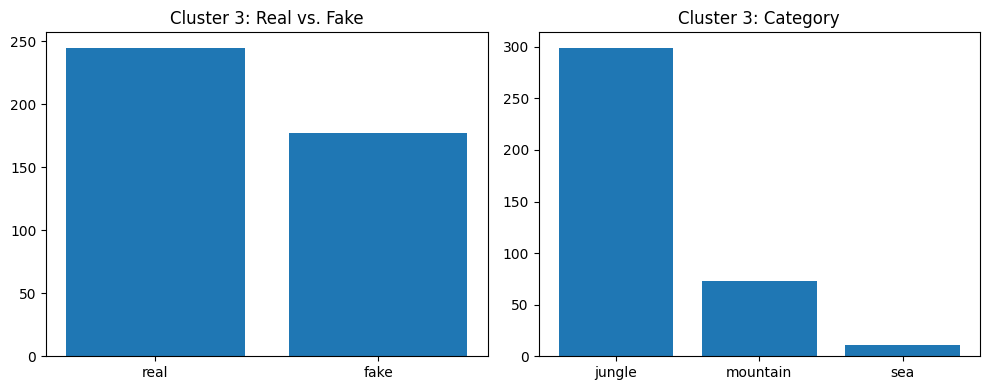


Cluster 4:
Real vs. Fake:
real    632
fake    581
Name: Real_Fake, dtype: int64

Category:
sea         721
mountain    394
jungle       56
Name: Category, dtype: int64


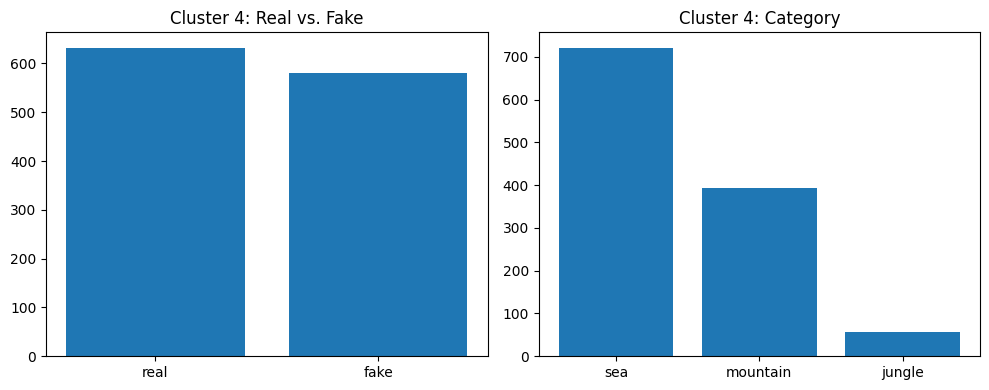


Cluster 5:
Real vs. Fake:
fake    100
real     83
Name: Real_Fake, dtype: int64

Category:
jungle      83
mountain    52
sea         37
Name: Category, dtype: int64


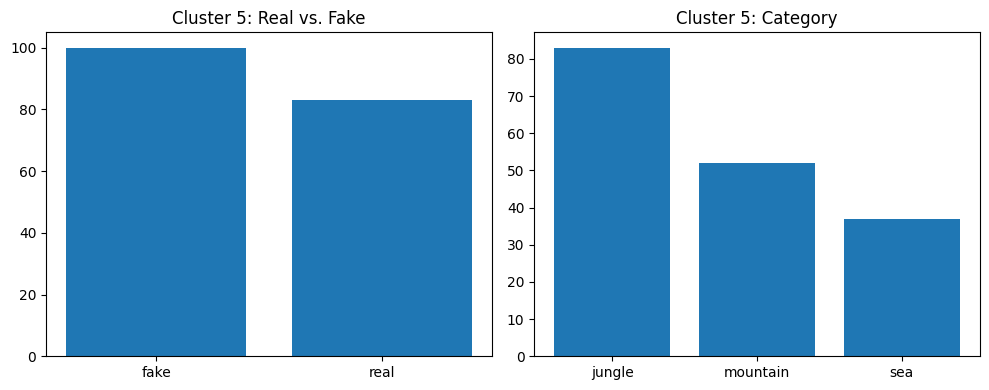

In [ ]:
perform_kmeans_clustering(df1, labels1, 6)

In [ ]:
perform_kmeans_clustering(df1, labels1, 9, plot=False)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 9 Clusters: 0.034950409522224155

Cluster 0:
Real vs. Fake:
fake    114
real     96
Name: Real_Fake, dtype: int64

Category:
sea         100
mountain     98
jungle       10
Name: Category, dtype: int64

Cluster 1:
Real vs. Fake:
real    301
fake    272
Name: Real_Fake, dtype: int64

Category:
sea         397
mountain    135
jungle       19
Name: Category, dtype: int64

Cluster 2:
Real vs. Fake:
real    195
fake    105
Name: Real_Fake, dtype: int64

Category:
mountain    145
sea         111
jungle       34
Name: Category, dtype: int64

Cluster 3:
Real vs. Fake:
real    248
fake    240
Name: Real_Fake, dtype: int64

Category:
jungle      279
mountain    136
sea          58
Name: Category, dtype: int64

Cluster 4:
Real vs. Fake:
fake    301
real    270
Name: Real_Fake, dtype: int64

Category:
sea         289
mountain    236
jungle       30
Name: Category, dtype: int64

Cluster 5:
Real vs. Fake:
fake    108
real     37
Name: Real_Fake, dtype: int64

Category:
jungle   

In [ ]:
perform_kmeans_clustering(df1, labels1, 50, plot=False)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 50 Clusters: 0.03417313898794839

Cluster 0:
Real vs. Fake:
real    46
fake    24
Name: Real_Fake, dtype: int64

Category:
mountain    36
sea         23
jungle       7
Name: Category, dtype: int64

Cluster 1:
Real vs. Fake:
real    29
fake    19
Name: Real_Fake, dtype: int64

Category:
mountain    29
sea         15
jungle       4
Name: Category, dtype: int64

Cluster 2:
Real vs. Fake:
fake    51
real    37
Name: Real_Fake, dtype: int64

Category:
mountain    50
sea         24
jungle      13
Name: Category, dtype: int64

Cluster 3:
Real vs. Fake:
fake    46
real    41
Name: Real_Fake, dtype: int64

Category:
jungle      81
mountain     2
sea          2
Name: Category, dtype: int64

Cluster 4:
Real vs. Fake:
fake    41
real    28
Name: Real_Fake, dtype: int64

Category:
jungle      29
mountain    26
sea         12
Name: Category, dtype: int64

Cluster 5:
Real vs. Fake:
fake    13
real     9
Name: Real_Fake, dtype: int64

Category:
jungle    20
Name: Category, dtype: 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 2 Clusters: 0.3518257575008264

Cluster 0:
Real vs. Fake:
real    1158
fake    1104
Name: Real_Fake, dtype: int64

Category:
jungle      949
mountain    641
sea         561
Name: Category, dtype: int64


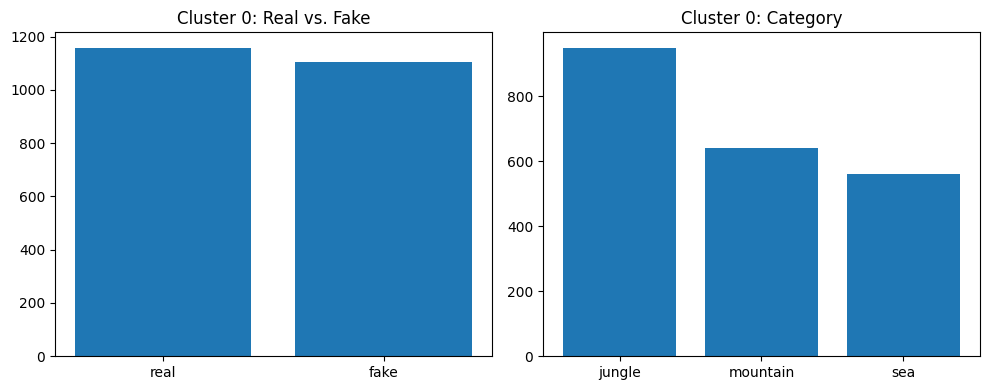


Cluster 1:
Real vs. Fake:
fake    606
real    549
Name: Real_Fake, dtype: int64

Category:
sea         538
mountain    479
jungle      108
Name: Category, dtype: int64


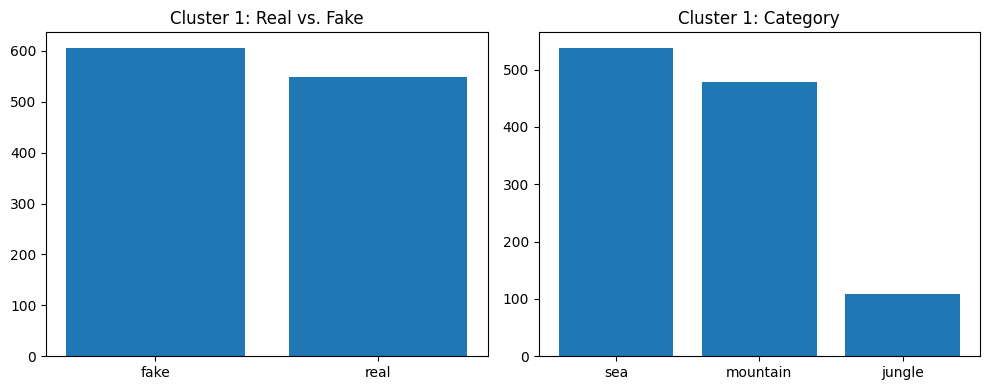

In [ ]:
perform_kmeans_clustering(df2, labels2, 2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 3 Clusters: 0.24348652850204747

Cluster 0:
Real vs. Fake:
real    694
fake    672
Name: Real_Fake, dtype: int64

Category:
mountain    579
sea         528
jungle      223
Name: Category, dtype: int64


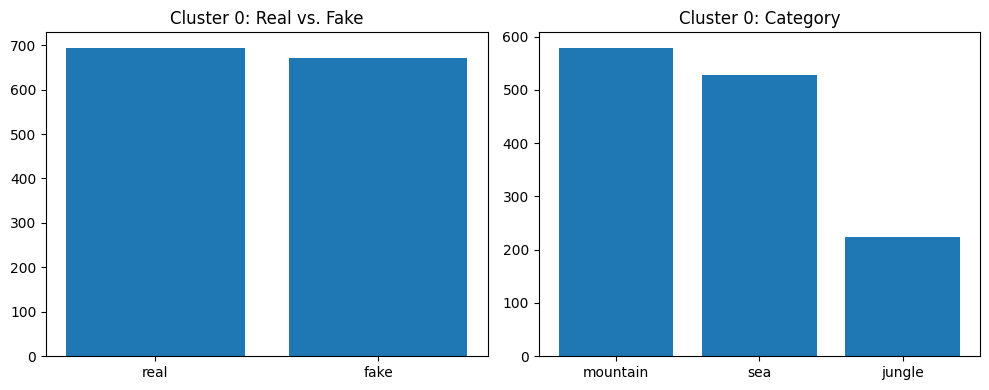


Cluster 1:
Real vs. Fake:
real    780
fake    724
Name: Real_Fake, dtype: int64

Category:
jungle      794
mountain    323
sea         295
Name: Category, dtype: int64


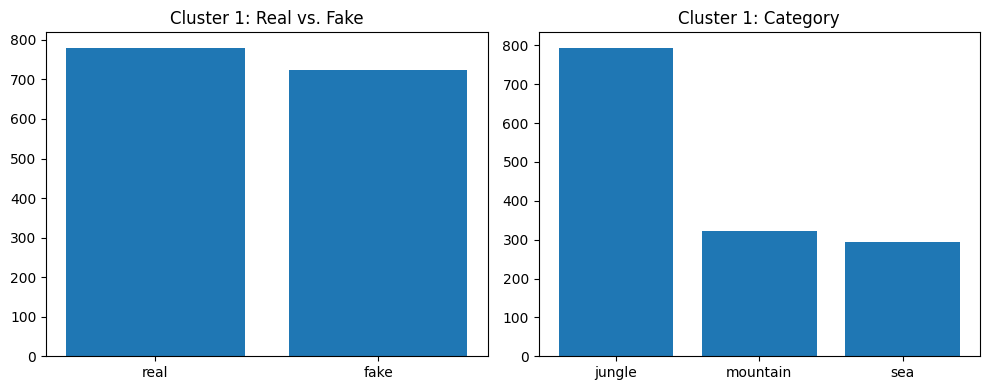


Cluster 2:
Real vs. Fake:
fake    314
real    233
Name: Real_Fake, dtype: int64

Category:
sea         276
mountain    218
jungle       40
Name: Category, dtype: int64


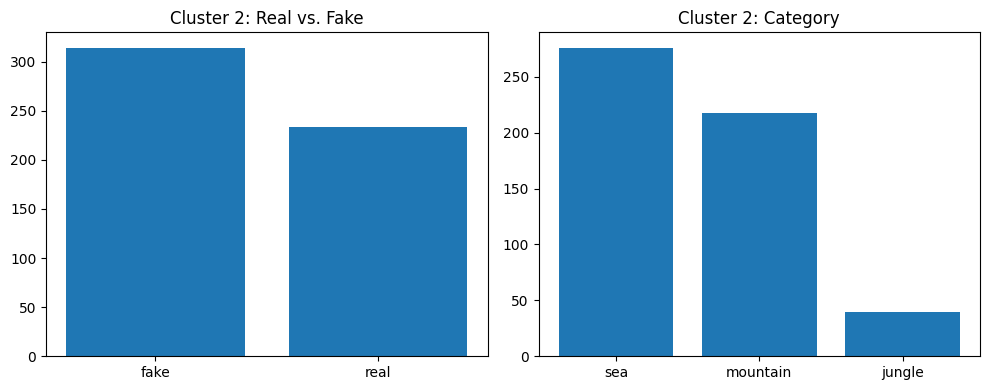

In [ ]:
perform_kmeans_clustering(df2, labels2, 3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 6 Clusters: 0.16556551188348034

Cluster 0:
Real vs. Fake:
fake    303
real    204
Name: Real_Fake, dtype: int64

Category:
mountain    205
sea         201
jungle       90
Name: Category, dtype: int64


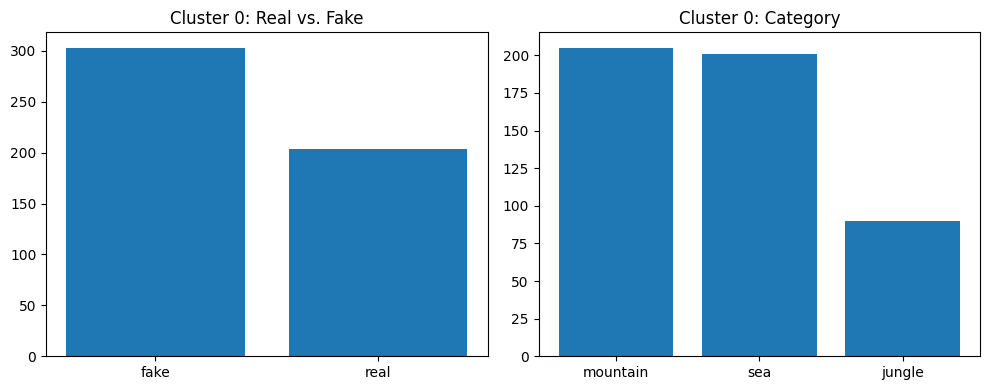


Cluster 1:
Real vs. Fake:
real    567
fake    532
Name: Real_Fake, dtype: int64

Category:
jungle      651
mountain    191
sea         180
Name: Category, dtype: int64


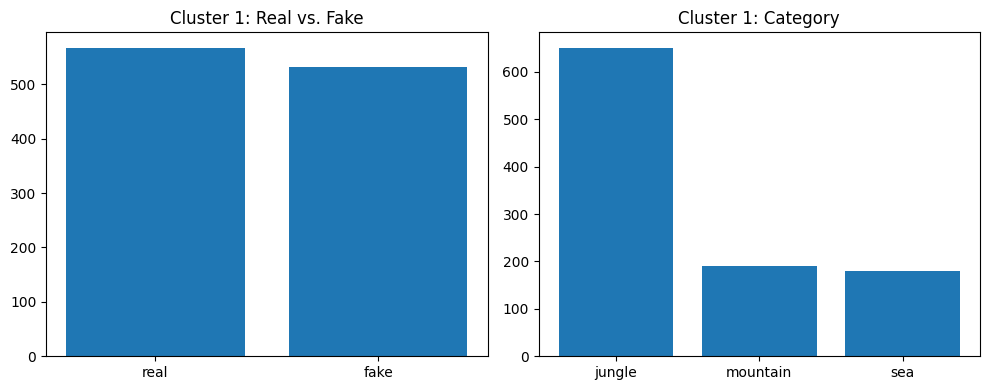


Cluster 2:
Real vs. Fake:
real    337
fake    274
Name: Real_Fake, dtype: int64

Category:
mountain    280
sea         263
jungle       47
Name: Category, dtype: int64


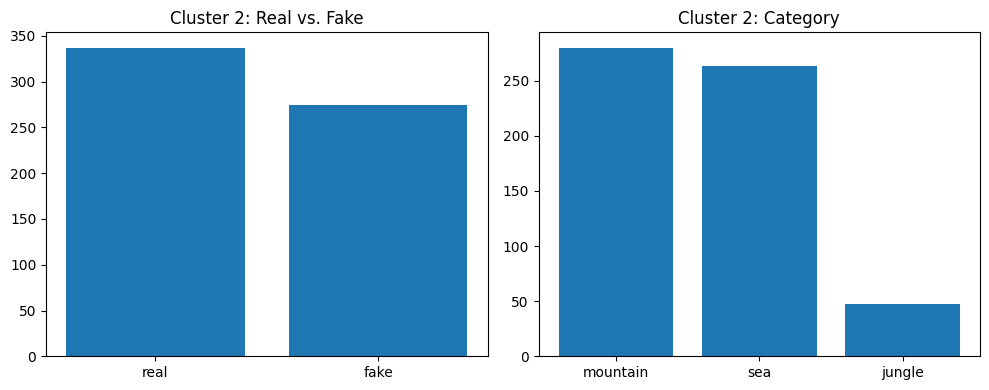


Cluster 3:
Real vs. Fake:
real    470
fake    356
Name: Real_Fake, dtype: int64

Category:
mountain    306
sea         253
jungle      239
Name: Category, dtype: int64


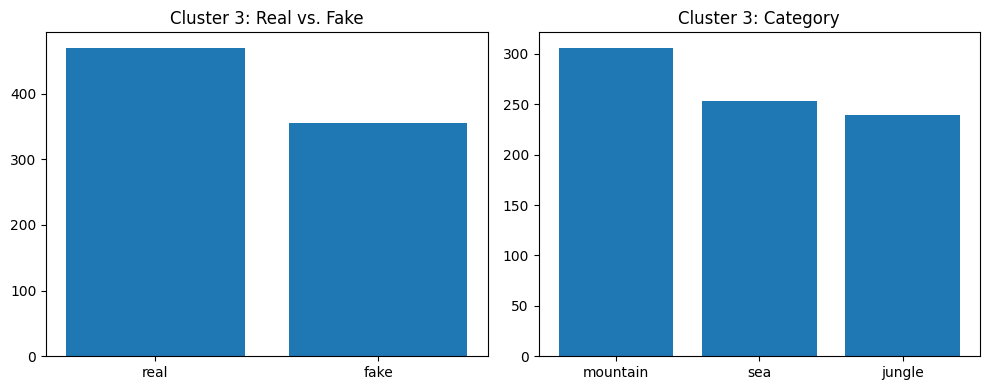


Cluster 4:
Real vs. Fake:
fake    109
real     52
Name: Real_Fake, dtype: int64

Category:
sea         84
mountain    61
jungle      16
Name: Category, dtype: int64


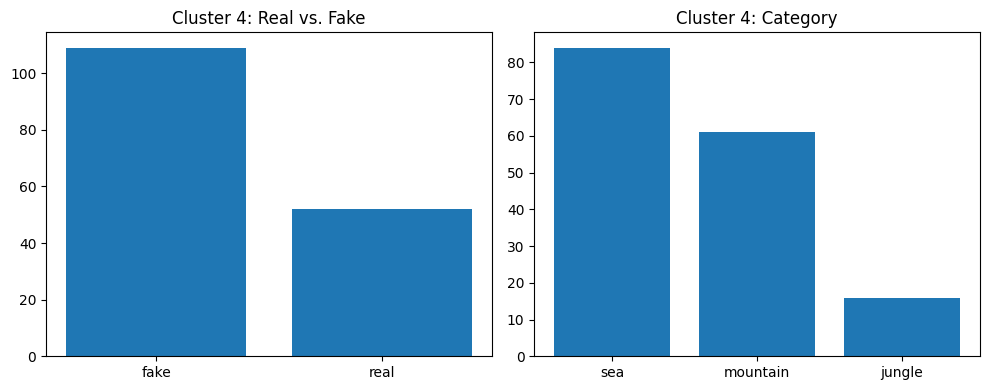


Cluster 5:
Real vs. Fake:
fake    136
real     77
Name: Real_Fake, dtype: int64

Category:
sea         118
mountain     77
jungle       14
Name: Category, dtype: int64


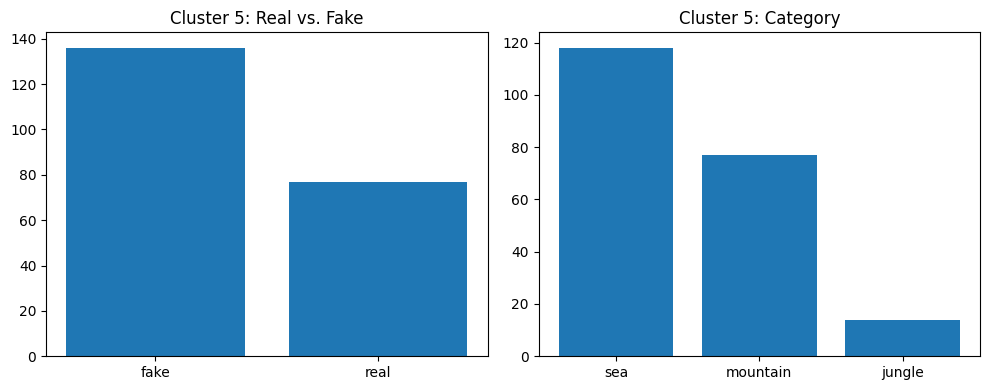

In [ ]:
perform_kmeans_clustering(df2, labels2, 6)

In [ ]:
perform_kmeans_clustering(df2, labels2, 9, plot=False)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 9 Clusters: 0.11750447221235445

Cluster 0:
Real vs. Fake:
real    343
fake    338
Name: Real_Fake, dtype: int64

Category:
jungle      456
sea          95
mountain     70
Name: Category, dtype: int64

Cluster 1:
Real vs. Fake:
fake    83
real    35
Name: Real_Fake, dtype: int64

Category:
sea         61
mountain    39
jungle      17
Name: Category, dtype: int64

Cluster 2:
Real vs. Fake:
real    165
fake    140
Name: Real_Fake, dtype: int64

Category:
mountain    164
sea         117
jungle       13
Name: Category, dtype: int64

Cluster 3:
Real vs. Fake:
fake    85
real    52
Name: Real_Fake, dtype: int64

Category:
sea         71
mountain    50
jungle      15
Name: Category, dtype: int64

Cluster 4:
Real vs. Fake:
fake    247
real    167
Name: Real_Fake, dtype: int64

Category:
sea         168
mountain    167
jungle       69
Name: Category, dtype: int64

Cluster 5:
Real vs. Fake:
fake    86
real    53
Name: Real_Fake, dtype: int64

Category:
sea         82
mountai

In [ ]:
perform_kmeans_clustering(df2, labels2, 50, plot=False)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 50 Clusters: 0.07159944804951085

Cluster 0:
Real vs. Fake:
real    74
fake    49
Name: Real_Fake, dtype: int64

Category:
mountain    74
sea         31
jungle      11
Name: Category, dtype: int64

Cluster 1:
Real vs. Fake:
fake    57
real    42
Name: Real_Fake, dtype: int64

Category:
jungle      42
mountain    26
sea         22
Name: Category, dtype: int64

Cluster 2:
Real vs. Fake:
fake    36
real    27
Name: Real_Fake, dtype: int64

Category:
mountain    25
sea         24
jungle      13
Name: Category, dtype: int64

Cluster 3:
Real vs. Fake:
fake    13
real     1
Name: Real_Fake, dtype: int64

Category:
sea         12
mountain     2
Name: Category, dtype: int64

Cluster 4:
Real vs. Fake:
real    108
fake     60
Name: Real_Fake, dtype: int64

Category:
jungle      103
mountain     42
sea          17
Name: Category, dtype: int64

Cluster 5:
Real vs. Fake:
real    6
fake    5
Name: Real_Fake, dtype: int64

Category:
sea         6
jungle      2
mountain    2
Name: 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 2 Clusters: 0.08640104620198286

Cluster 0:
Real vs. Fake:
real    953
fake    793
Name: Real_Fake, dtype: int64

Category:
jungle      990
mountain    453
sea         210
Name: Category, dtype: int64


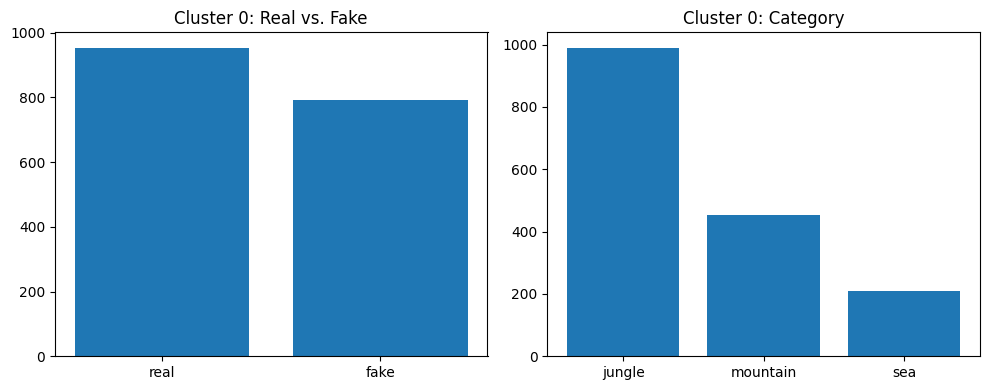


Cluster 1:
Real vs. Fake:
fake    917
real    754
Name: Real_Fake, dtype: int64

Category:
sea         889
mountain    667
jungle       67
Name: Category, dtype: int64


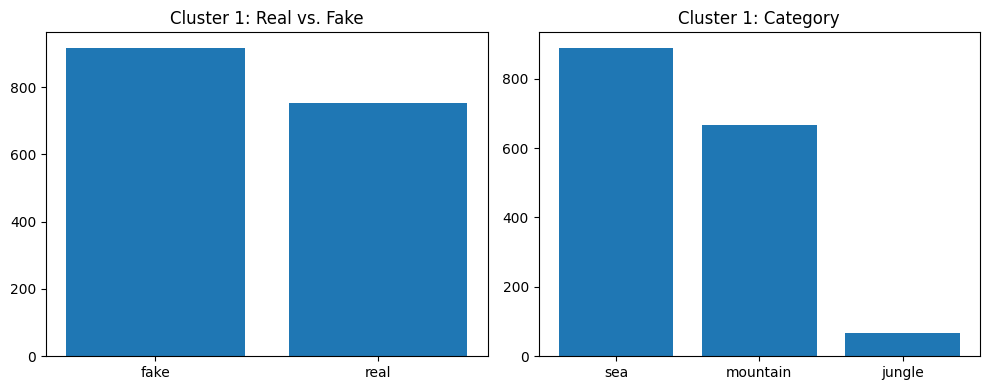

In [ ]:
perform_kmeans_clustering(df3, labels3, 2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 3 Clusters: 0.04700268573469903

Cluster 0:
Real vs. Fake:
real    837
fake    588
Name: Real_Fake, dtype: int64

Category:
mountain    792
sea         433
jungle      153
Name: Category, dtype: int64


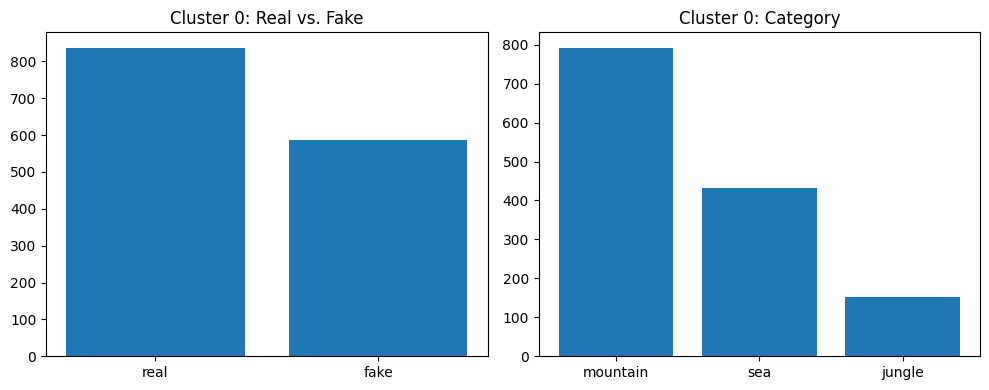


Cluster 1:
Real vs. Fake:
fake    556
real    279
Name: Real_Fake, dtype: int64

Category:
sea         588
mountain    217
jungle       12
Name: Category, dtype: int64


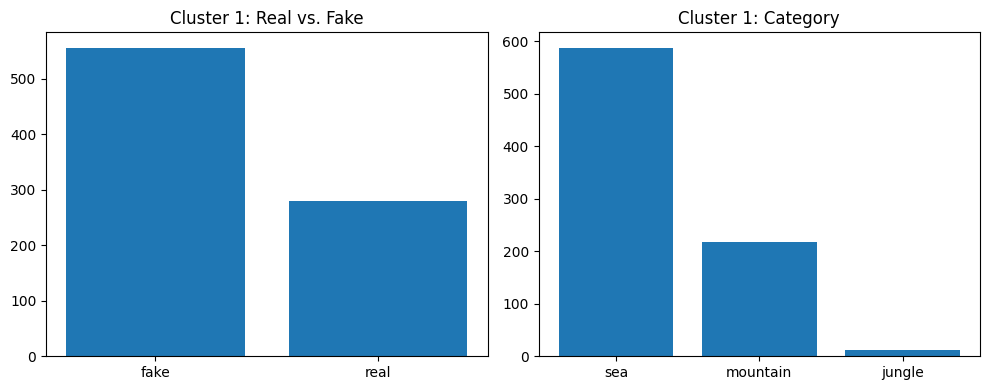


Cluster 2:
Real vs. Fake:
real    591
fake    566
Name: Real_Fake, dtype: int64

Category:
jungle      892
mountain    111
sea          78
Name: Category, dtype: int64


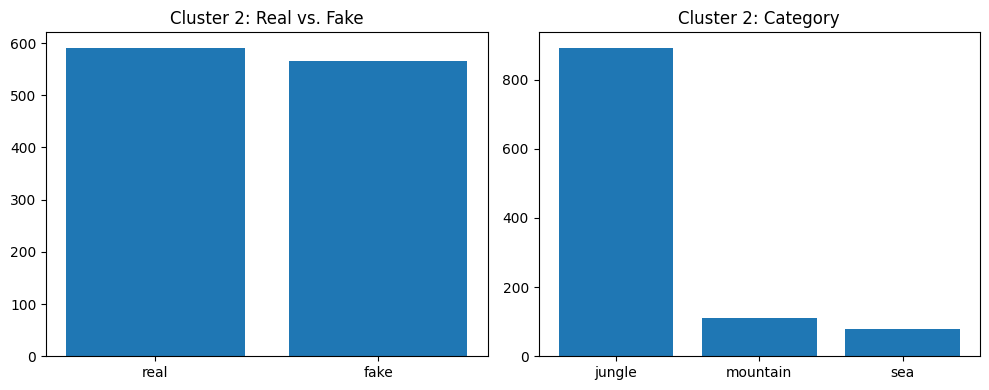

In [ ]:
perform_kmeans_clustering(df3, labels3, 3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 6 Clusters: 0.01842823110907575

Cluster 0:
Real vs. Fake:
real    287
fake    272
Name: Real_Fake, dtype: int64

Category:
mountain    272
sea         237
jungle       31
Name: Category, dtype: int64


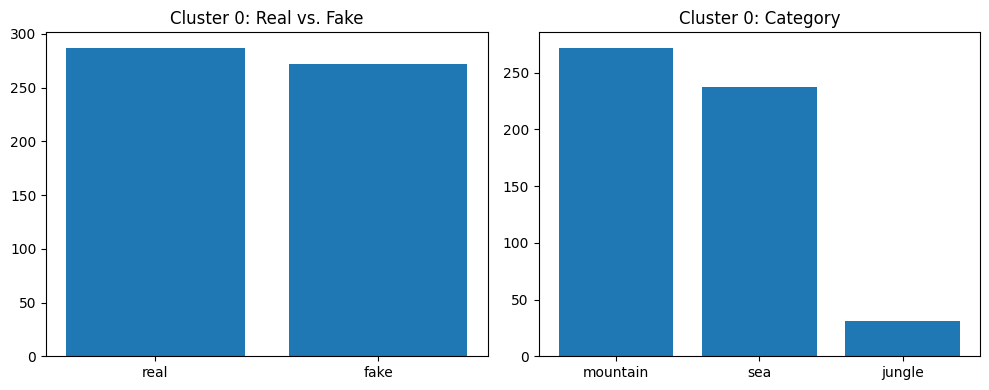


Cluster 1:
Real vs. Fake:
real    490
fake    419
Name: Real_Fake, dtype: int64

Category:
jungle      675
mountain    103
sea          88
Name: Category, dtype: int64


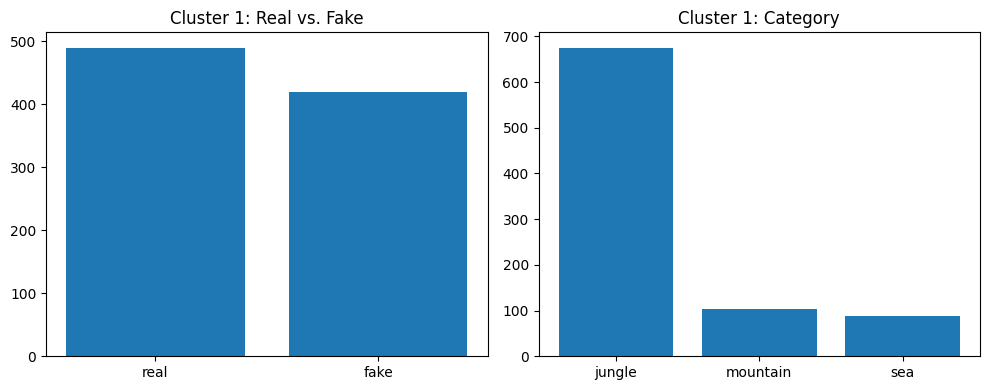


Cluster 2:
Real vs. Fake:
fake    161
real    106
Name: Real_Fake, dtype: int64

Category:
jungle      223
sea           6
mountain      4
Name: Category, dtype: int64


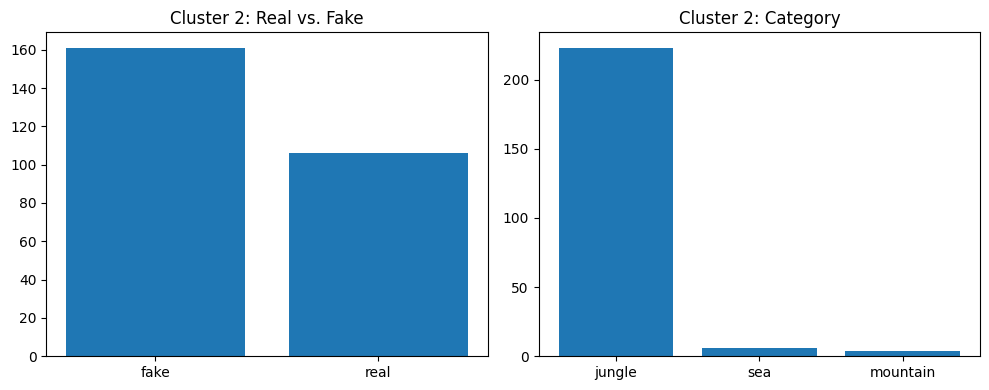


Cluster 3:
Real vs. Fake:
real    463
fake    296
Name: Real_Fake, dtype: int64

Category:
mountain    507
sea         125
jungle      103
Name: Category, dtype: int64


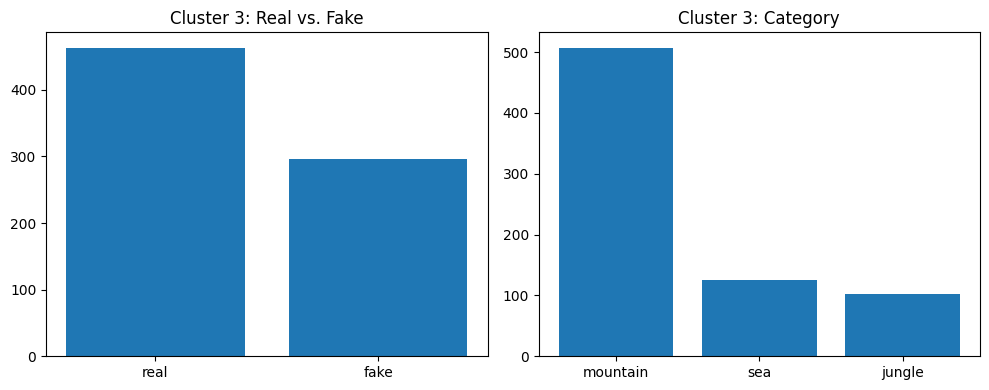


Cluster 4:
Real vs. Fake:
fake    273
real    113
Name: Real_Fake, dtype: int64

Category:
sea         296
mountain     81
jungle        1
Name: Category, dtype: int64


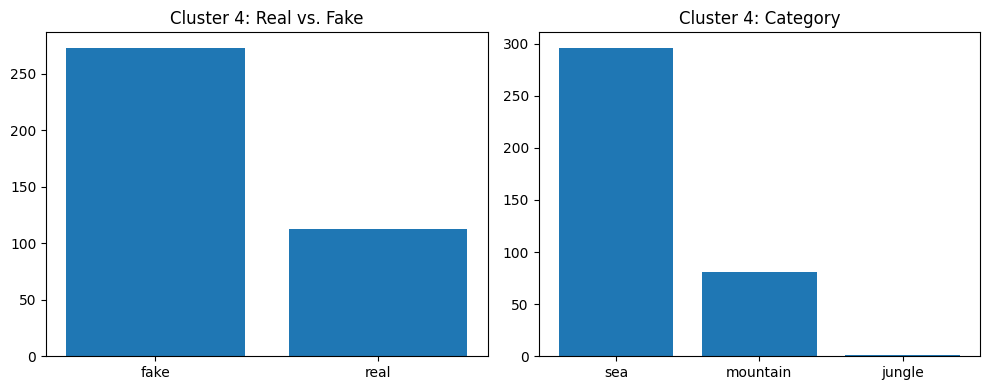


Cluster 5:
Real vs. Fake:
fake    289
real    248
Name: Real_Fake, dtype: int64

Category:
sea         347
mountain    153
jungle       24
Name: Category, dtype: int64


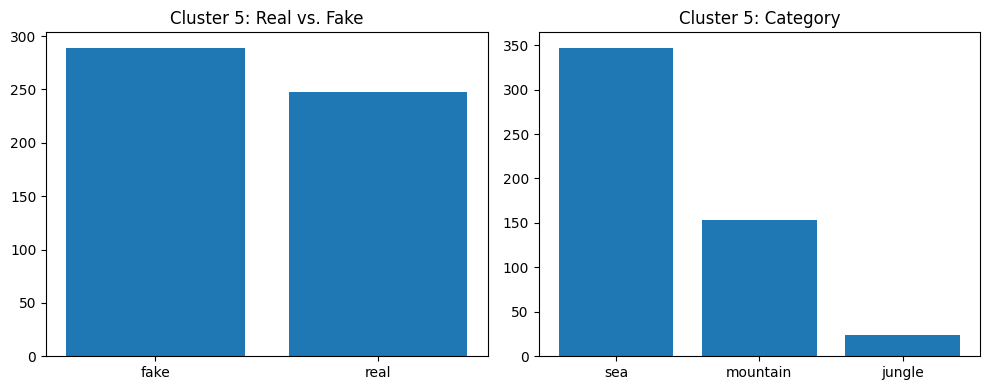

In [ ]:
perform_kmeans_clustering(df3, labels3, 6)

In [ ]:
perform_kmeans_clustering(df3, labels3, 9, plot=False)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 9 Clusters: 0.015022655432040335

Cluster 0:
Real vs. Fake:
real    156
fake    124
Name: Real_Fake, dtype: int64

Category:
mountain    237
sea          24
jungle       10
Name: Category, dtype: int64

Cluster 1:
Real vs. Fake:
real    461
fake    395
Name: Real_Fake, dtype: int64

Category:
jungle      660
sea          79
mountain     74
Name: Category, dtype: int64

Cluster 2:
Real vs. Fake:
fake    212
real    125
Name: Real_Fake, dtype: int64

Category:
sea         236
mountain     80
jungle       12
Name: Category, dtype: int64

Cluster 3:
Real vs. Fake:
fake    148
real    120
Name: Real_Fake, dtype: int64

Category:
sea         215
mountain     43
jungle        4
Name: Category, dtype: int64

Cluster 4:
Real vs. Fake:
fake    161
real     39
Name: Real_Fake, dtype: int64

Category:
sea         127
mountain     68
jungle        1
Name: Category, dtype: int64

Cluster 5:
Real vs. Fake:
real    230
fake    211
Name: Real_Fake, dtype: int64

Category:
mountain 

In [ ]:
perform_kmeans_clustering(df3, labels3, 50, plot=False)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 50 Clusters: -0.011645667180928491

Cluster 0:
Real vs. Fake:
real    1
Name: Real_Fake, dtype: int64

Category:
jungle    1
Name: Category, dtype: int64

Cluster 1:
Real vs. Fake:
fake    32
real    13
Name: Real_Fake, dtype: int64

Category:
mountain    34
sea          8
jungle       1
Name: Category, dtype: int64

Cluster 2:
Real vs. Fake:
real    65
fake    47
Name: Real_Fake, dtype: int64

Category:
mountain    60
sea         41
jungle       8
Name: Category, dtype: int64

Cluster 3:
Real vs. Fake:
fake    77
real    43
Name: Real_Fake, dtype: int64

Category:
sea         60
mountain    48
jungle       7
Name: Category, dtype: int64

Cluster 4:
Real vs. Fake:
real    53
fake    29
Name: Real_Fake, dtype: int64

Category:
mountain    72
sea          5
Name: Category, dtype: int64

Cluster 5:
Real vs. Fake:
real    46
fake    13
Name: Real_Fake, dtype: int64

Category:
mountain    47
sea          9
jungle       3
Name: Category, dtype: int64

Cluster 6:
Real vs.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 2 Clusters: 0.46961800101894896

Cluster 0:
Real vs. Fake:
fake    1175
real    1082
Name: Real_Fake, dtype: int64

Category:
sea         972
mountain    931
jungle      291
Name: Category, dtype: int64


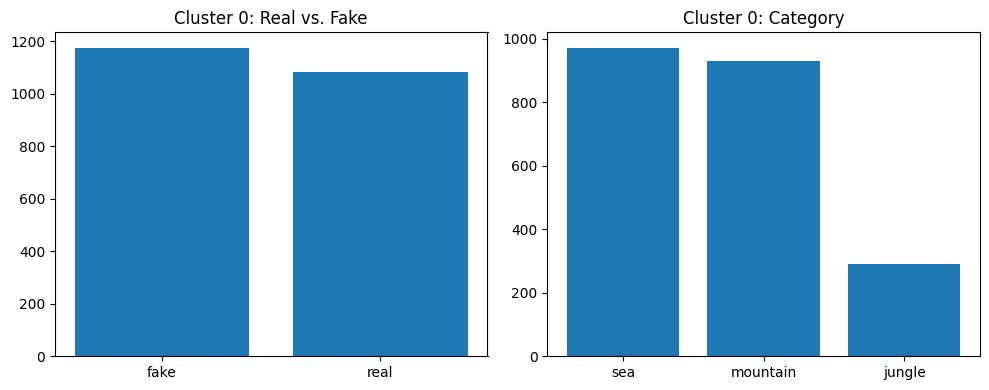


Cluster 1:
Real vs. Fake:
real    625
fake    535
Name: Real_Fake, dtype: int64

Category:
jungle      766
mountain    189
sea         127
Name: Category, dtype: int64


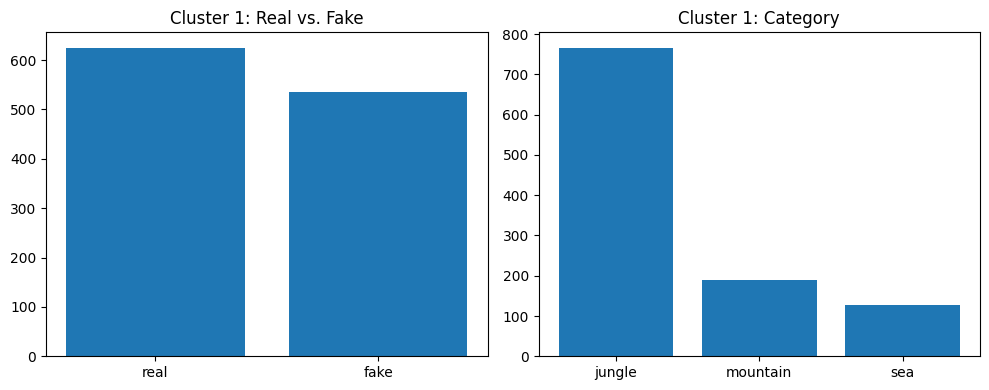

In [ ]:
perform_kmeans_clustering(df4, labels4, 2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 3 Clusters: 0.42145691989716483

Cluster 0:
Real vs. Fake:
real    934
fake    854
Name: Real_Fake, dtype: int64

Category:
sea         675
mountain    666
jungle      392
Name: Category, dtype: int64


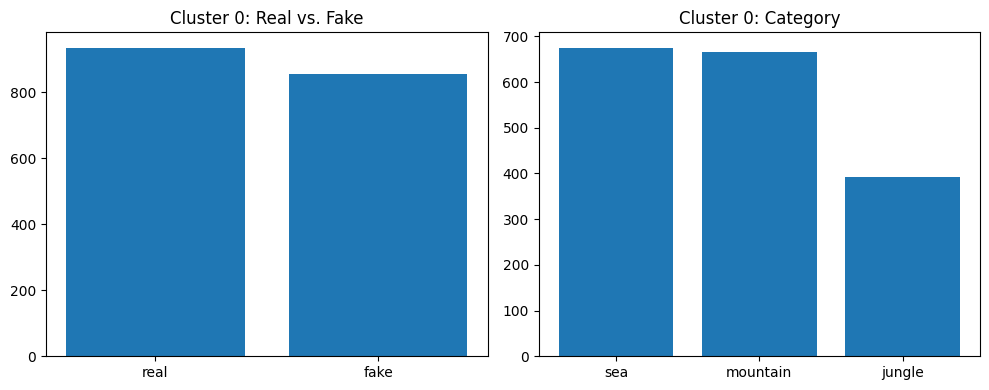


Cluster 1:
Real vs. Fake:
fake    456
real    284
Name: Real_Fake, dtype: int64

Category:
sea         360
mountain    335
jungle       25
Name: Category, dtype: int64


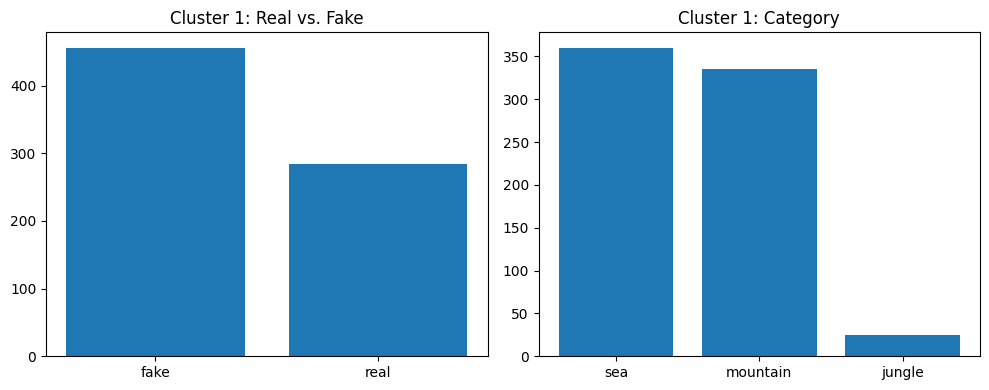


Cluster 2:
Real vs. Fake:
real    489
fake    400
Name: Real_Fake, dtype: int64

Category:
jungle      640
mountain    119
sea          64
Name: Category, dtype: int64


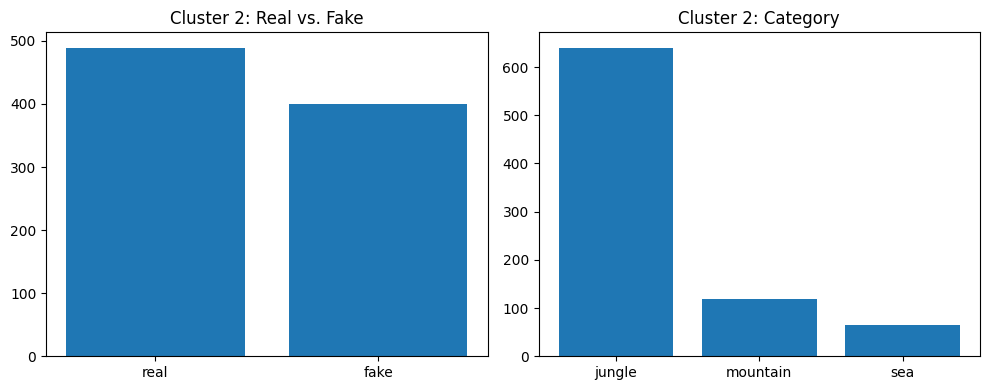

In [ ]:
perform_kmeans_clustering(df4, labels4, 3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 6 Clusters: 0.3583988049489972

Cluster 0:
Real vs. Fake:
real    339
fake    336
Name: Real_Fake, dtype: int64

Category:
jungle      419
mountain    130
sea          91
Name: Category, dtype: int64


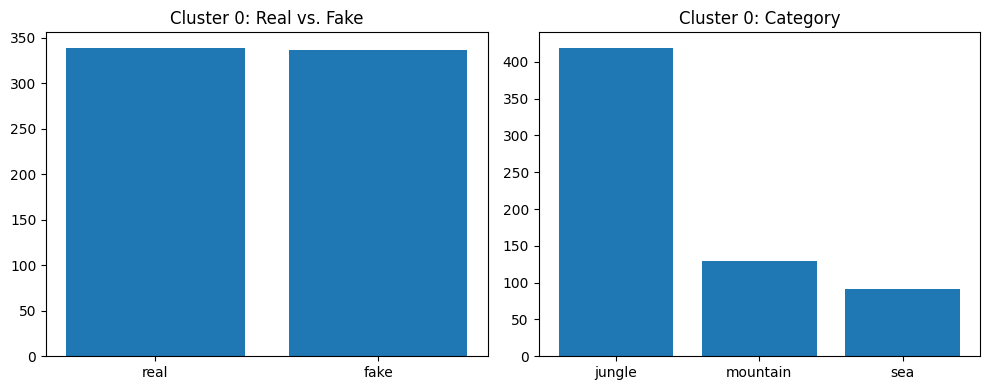


Cluster 1:
Real vs. Fake:
fake    405
real    348
Name: Real_Fake, dtype: int64

Category:
sea         414
mountain    287
jungle       37
Name: Category, dtype: int64


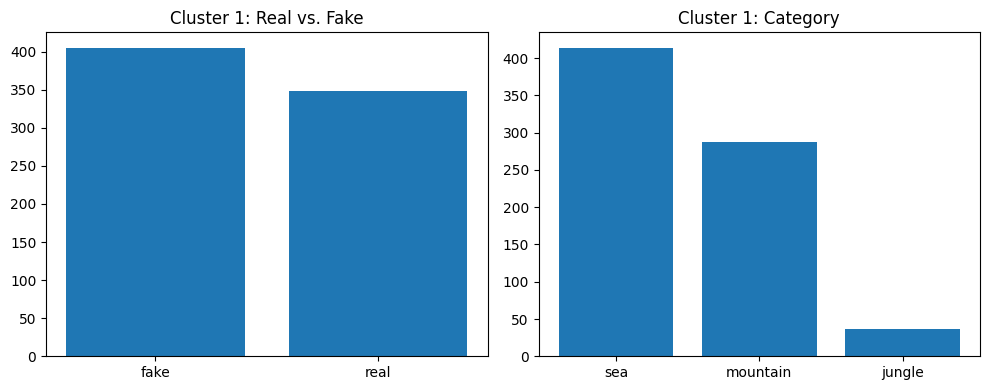


Cluster 2:
Real vs. Fake:
real    504
fake    498
Name: Real_Fake, dtype: int64

Category:
sea         397
mountain    341
jungle      235
Name: Category, dtype: int64


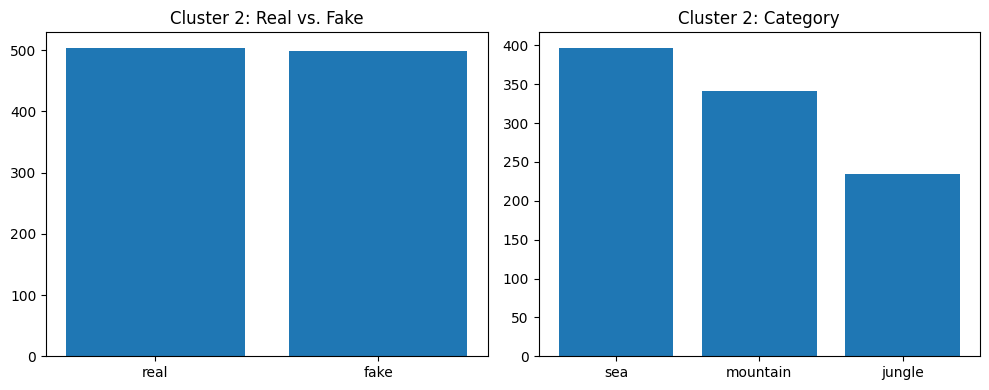


Cluster 3:
Real vs. Fake:
fake    201
real     97
Name: Real_Fake, dtype: int64

Category:
mountain    148
sea         125
jungle       12
Name: Category, dtype: int64


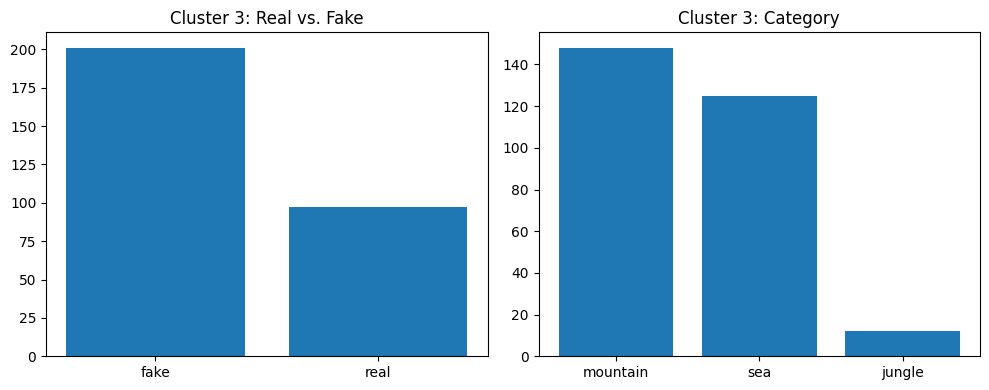


Cluster 4:
Real vs. Fake:
real    233
fake    167
Name: Real_Fake, dtype: int64

Category:
jungle      323
mountain     24
sea          13
Name: Category, dtype: int64


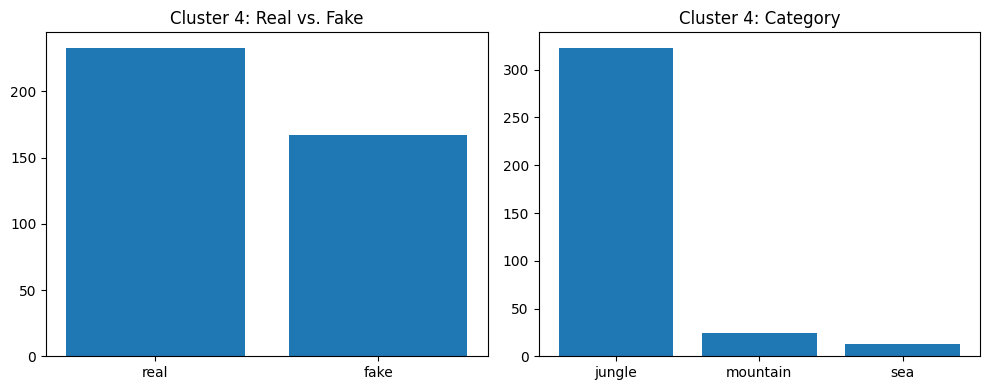


Cluster 5:
Real vs. Fake:
real    186
fake    103
Name: Real_Fake, dtype: int64

Category:
mountain    190
sea          59
jungle       31
Name: Category, dtype: int64


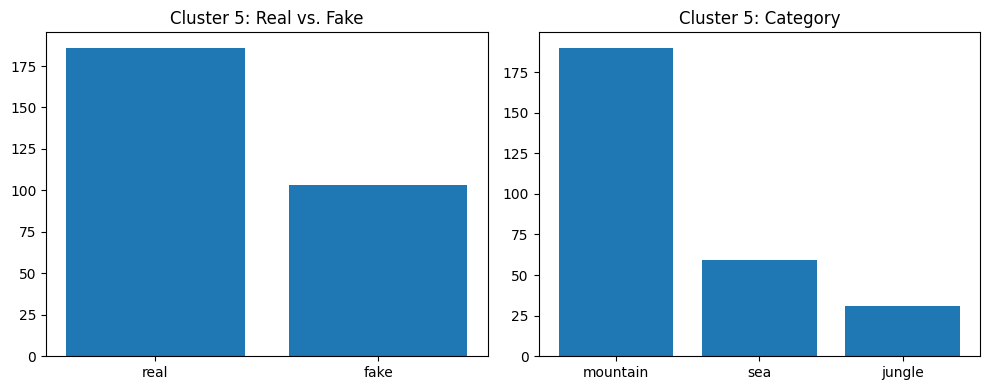

In [ ]:
perform_kmeans_clustering(df4, labels4, 6)

In [ ]:
perform_kmeans_clustering(df4, labels4, 9, plot=False)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 9 Clusters: 0.29832651512477726

Cluster 0:
Real vs. Fake:
real    123
fake     78
Name: Real_Fake, dtype: int64

Category:
jungle      172
mountain      4
sea           3
Name: Category, dtype: int64

Cluster 1:
Real vs. Fake:
real    351
fake    345
Name: Real_Fake, dtype: int64

Category:
sea         341
mountain    245
jungle       96
Name: Category, dtype: int64

Cluster 2:
Real vs. Fake:
fake    56
real    12
Name: Real_Fake, dtype: int64

Category:
mountain    40
sea         22
jungle       2
Name: Category, dtype: int64

Cluster 3:
Real vs. Fake:
real    194
fake    152
Name: Real_Fake, dtype: int64

Category:
jungle      253
mountain     41
sea          26
Name: Category, dtype: int64

Cluster 4:
Real vs. Fake:
fake    190
real    125
Name: Real_Fake, dtype: int64

Category:
sea         151
mountain    144
jungle       10
Name: Category, dtype: int64

Cluster 5:
Real vs. Fake:
real    174
fake     90
Name: Real_Fake, dtype: int64

Category:
mountain    178

In [ ]:
perform_kmeans_clustering(df4, labels4, 50, plot=False)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 50 Clusters: 0.2532546209328367

Cluster 0:
Real vs. Fake:
fake    86
real    78
Name: Real_Fake, dtype: int64

Category:
jungle      76
sea         48
mountain    36
Name: Category, dtype: int64

Cluster 1:
Real vs. Fake:
real    61
fake    58
Name: Real_Fake, dtype: int64

Category:
mountain    55
sea         53
jungle       6
Name: Category, dtype: int64

Cluster 2:
Real vs. Fake:
real    40
fake    35
Name: Real_Fake, dtype: int64

Category:
jungle      68
mountain     2
Name: Category, dtype: int64

Cluster 3:
Real vs. Fake:
fake    33
real     4
Name: Real_Fake, dtype: int64

Category:
mountain    20
sea         15
Name: Category, dtype: int64

Cluster 4:
Real vs. Fake:
real    36
fake    15
Name: Real_Fake, dtype: int64

Category:
mountain    24
sea         16
jungle       9
Name: Category, dtype: int64

Cluster 5:
Real vs. Fake:
fake    66
real    40
Name: Real_Fake, dtype: int64

Category:
sea         59
mountain    41
jungle       3
Name: Category, dtype:

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 2 Clusters: 0.19120959550978847

Cluster 0:
Real vs. Fake:
real    863
fake    823
Name: Real_Fake, dtype: int64

Category:
sea         787
mountain    656
jungle      186
Name: Category, dtype: int64


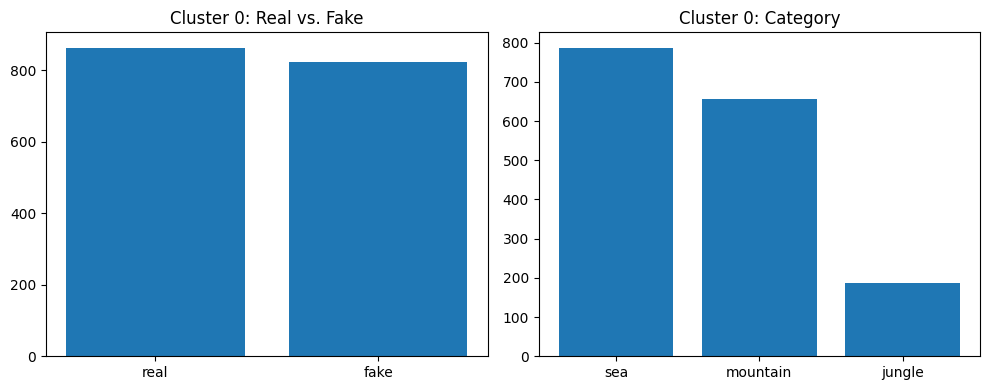


Cluster 1:
Real vs. Fake:
fake    887
real    844
Name: Real_Fake, dtype: int64

Category:
jungle      871
mountain    464
sea         312
Name: Category, dtype: int64


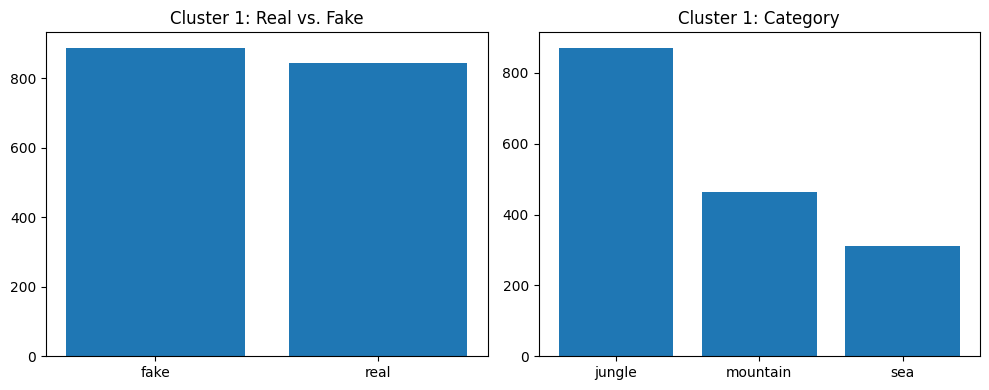

In [ ]:
perform_kmeans_clustering(df5, labels5, 2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 3 Clusters: 0.16389254824634925

Cluster 0:
Real vs. Fake:
fake    720
real    677
Name: Real_Fake, dtype: int64

Category:
jungle      784
mountain    300
sea         237
Name: Category, dtype: int64


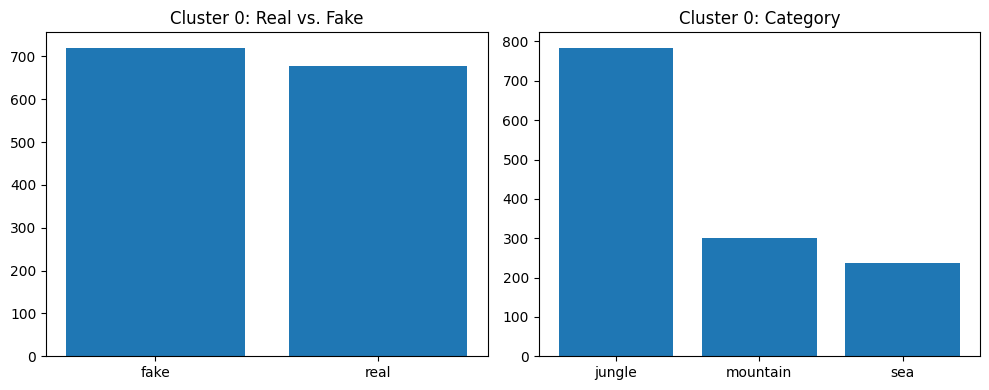


Cluster 1:
Real vs. Fake:
real    615
fake    504
Name: Real_Fake, dtype: int64

Category:
mountain    561
sea         345
jungle      183
Name: Category, dtype: int64


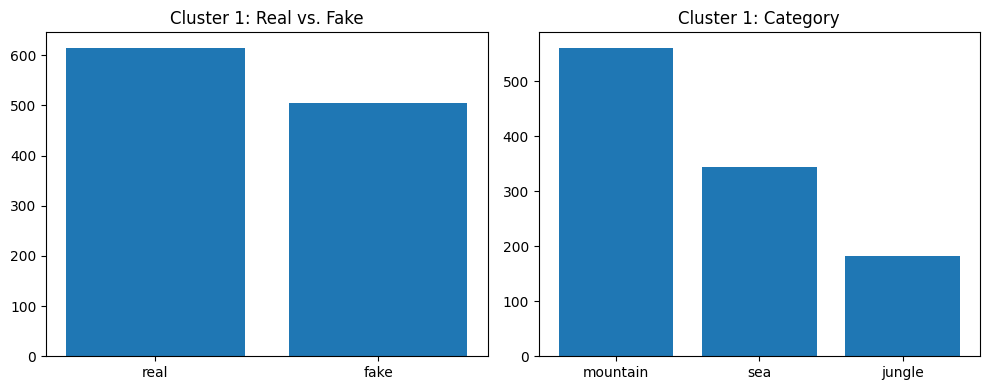


Cluster 2:
Real vs. Fake:
fake    486
real    415
Name: Real_Fake, dtype: int64

Category:
sea         517
mountain    259
jungle       90
Name: Category, dtype: int64


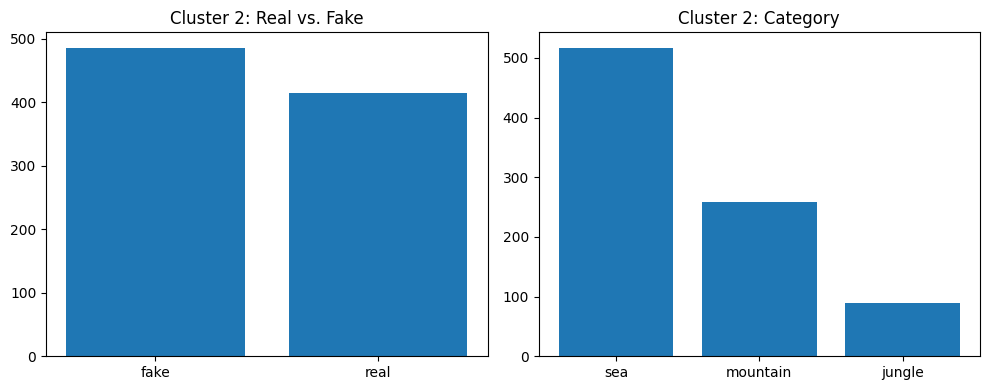

In [ ]:
perform_kmeans_clustering(df5, labels5, 3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 6 Clusters: 0.10116654078352459

Cluster 0:
Real vs. Fake:
real    306
fake    263
Name: Real_Fake, dtype: int64

Category:
mountain    303
jungle      134
sea         115
Name: Category, dtype: int64


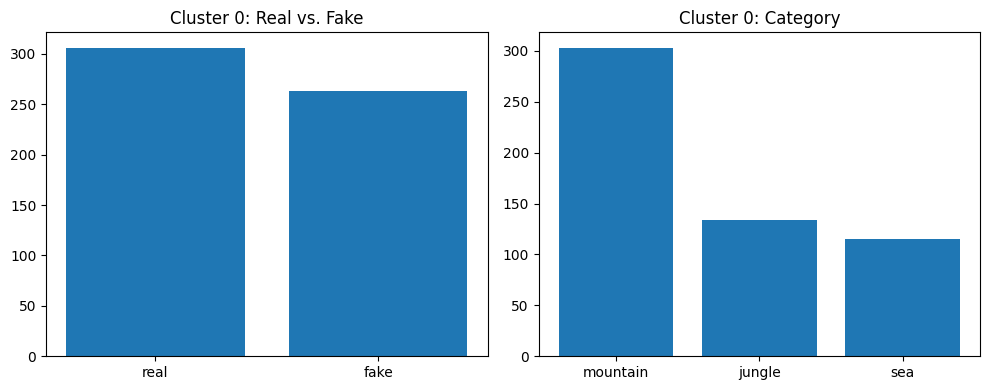


Cluster 1:
Real vs. Fake:
real    306
fake    247
Name: Real_Fake, dtype: int64

Category:
sea         260
mountain    243
jungle       38
Name: Category, dtype: int64


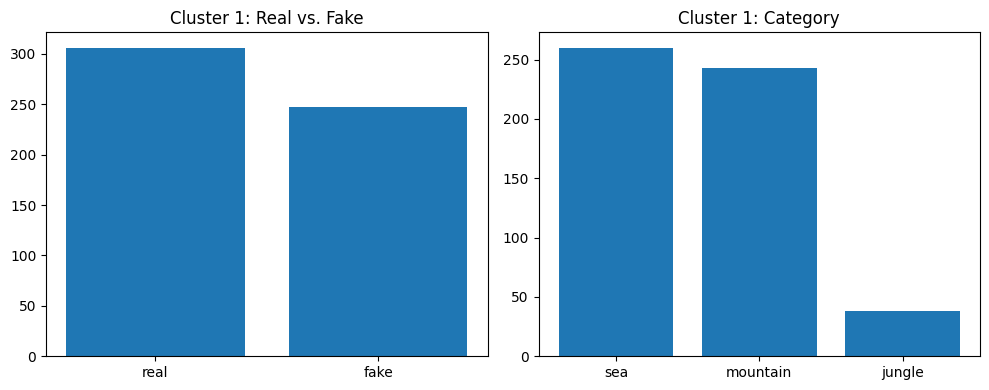


Cluster 2:
Real vs. Fake:
fake    500
real    377
Name: Real_Fake, dtype: int64

Category:
jungle      417
mountain    235
sea         168
Name: Category, dtype: int64


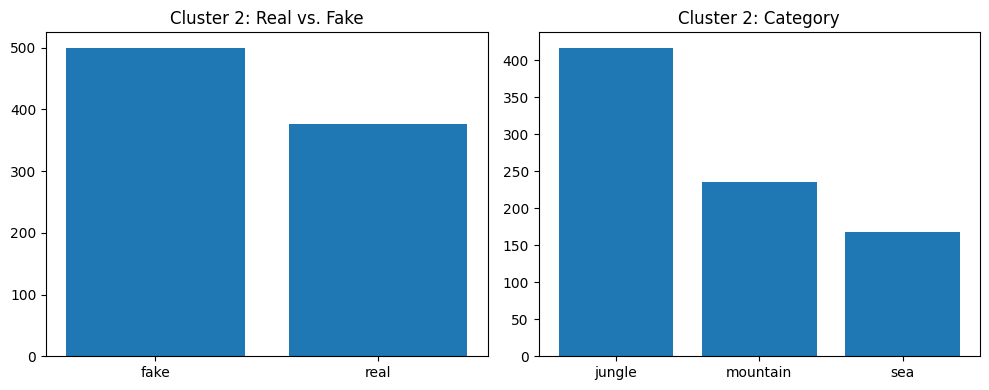


Cluster 3:
Real vs. Fake:
real    292
fake    220
Name: Real_Fake, dtype: int64

Category:
jungle      351
mountain     84
sea          61
Name: Category, dtype: int64


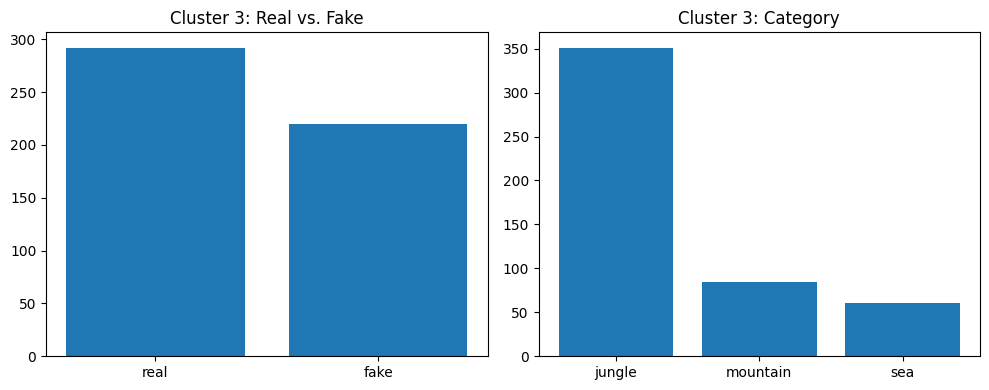


Cluster 4:
Real vs. Fake:
real    182
fake    121
Name: Real_Fake, dtype: int64

Category:
sea         190
mountain     83
jungle       19
Name: Category, dtype: int64


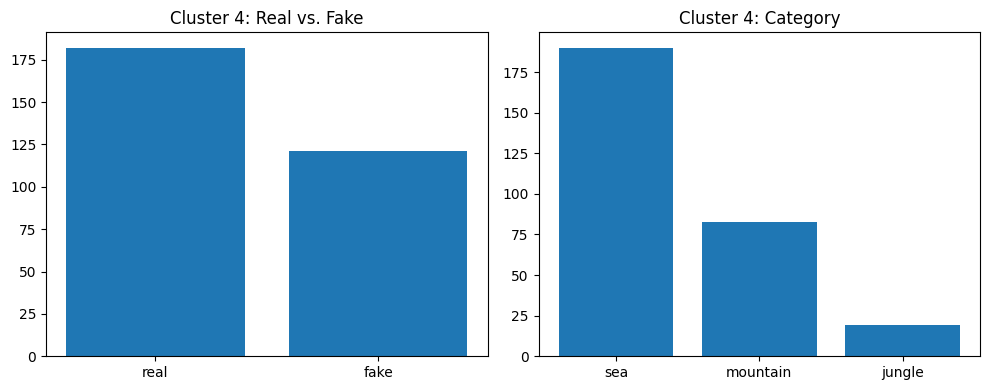


Cluster 5:
Real vs. Fake:
fake    359
real    244
Name: Real_Fake, dtype: int64

Category:
sea         305
mountain    172
jungle       98
Name: Category, dtype: int64


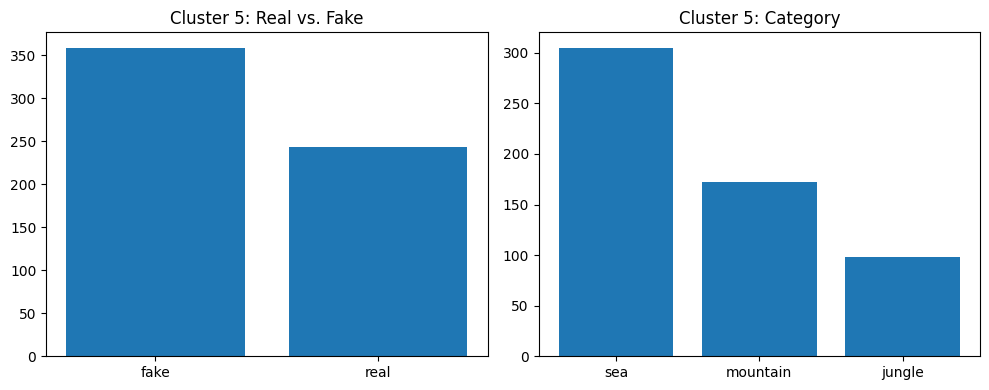

In [ ]:
perform_kmeans_clustering(df5, labels5, 6)

In [ ]:
perform_kmeans_clustering(df5, labels5, 9, plot=False)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 9 Clusters: 0.09694124100502931

Cluster 0:
Real vs. Fake:
fake    234
real    157
Name: Real_Fake, dtype: int64

Category:
mountain    175
sea         132
jungle       73
Name: Category, dtype: int64

Cluster 1:
Real vs. Fake:
fake    328
real    271
Name: Real_Fake, dtype: int64

Category:
jungle      312
mountain    122
sea         117
Name: Category, dtype: int64

Cluster 2:
Real vs. Fake:
fake    271
real    189
Name: Real_Fake, dtype: int64

Category:
sea         242
mountain    158
jungle       46
Name: Category, dtype: int64

Cluster 3:
Real vs. Fake:
fake    156
real    137
Name: Real_Fake, dtype: int64

Category:
sea         154
mountain     83
jungle       41
Name: Category, dtype: int64

Cluster 4:
Real vs. Fake:
real    139
fake     73
Name: Real_Fake, dtype: int64

Category:
sea         133
mountain     58
jungle       12
Name: Category, dtype: int64

Cluster 5:
Real vs. Fake:
fake    229
real    142
Name: Real_Fake, dtype: int64

Category:
jungle    

In [ ]:
perform_kmeans_clustering(df5, labels5, 50, plot=False)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 50 Clusters: 0.04808519231724763

Cluster 0:
Real vs. Fake:
fake    12
real     5
Name: Real_Fake, dtype: int64

Category:
mountain    8
sea         7
jungle      2
Name: Category, dtype: int64

Cluster 1:
Real vs. Fake:
fake    41
real    16
Name: Real_Fake, dtype: int64

Category:
sea         36
mountain    14
jungle       4
Name: Category, dtype: int64

Cluster 2:
Real vs. Fake:
fake    38
real    24
Name: Real_Fake, dtype: int64

Category:
mountain    26
sea         20
jungle      14
Name: Category, dtype: int64

Cluster 3:
Real vs. Fake:
real    39
fake    33
Name: Real_Fake, dtype: int64

Category:
mountain    44
sea         24
jungle       1
Name: Category, dtype: int64

Cluster 4:
Real vs. Fake:
real    32
fake    29
Name: Real_Fake, dtype: int64

Category:
sea         37
mountain    20
jungle       3
Name: Category, dtype: int64

Cluster 5:
Real vs. Fake:
real    37
fake    19
Name: Real_Fake, dtype: int64

Category:
jungle      27
mountain    21
sea      

Silhouette Score for 2 Clusters: 0.041366374429497595

Cluster 0:
Real vs. Fake:
fake    936
real    894
Name: Real_Fake, dtype: int64

Category:
jungle      963
mountain    431
sea         347
Name: Category, dtype: int64


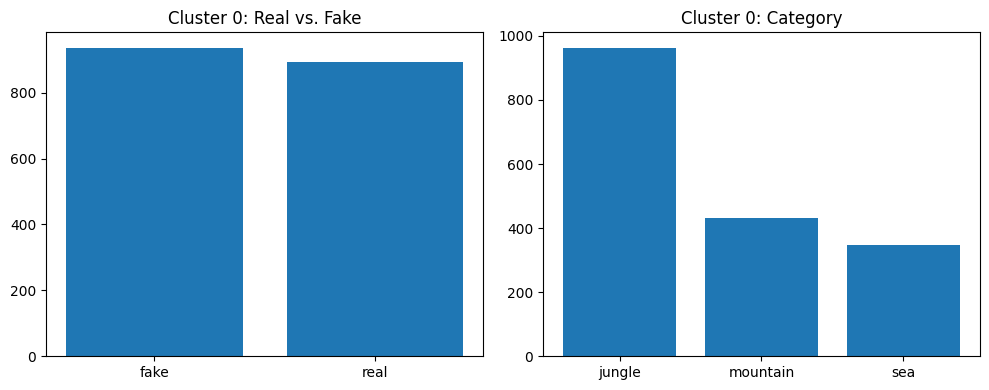


Cluster 1:
Real vs. Fake:
real    813
fake    774
Name: Real_Fake, dtype: int64

Category:
sea         752
mountain    689
jungle       94
Name: Category, dtype: int64


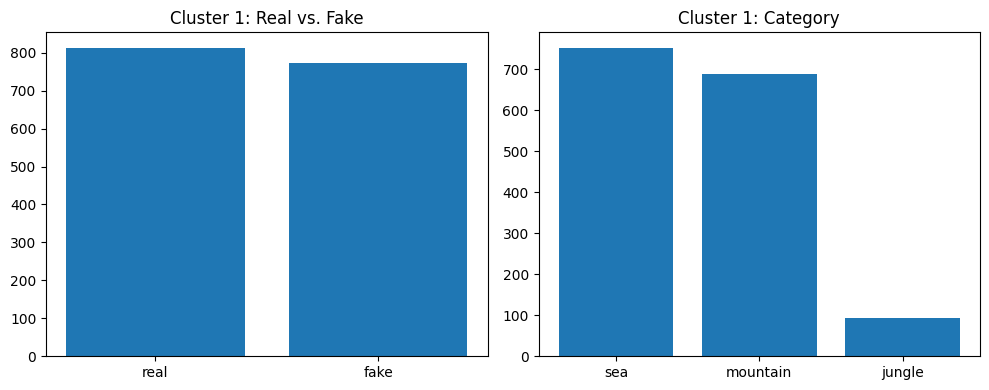

Silhouette Score for 3 Clusters: 0.07079839326965266

Cluster 0:
Real vs. Fake:
real    990
fake    988
Name: Real_Fake, dtype: int64

Category:
mountain    911
sea         694
jungle      304
Name: Category, dtype: int64


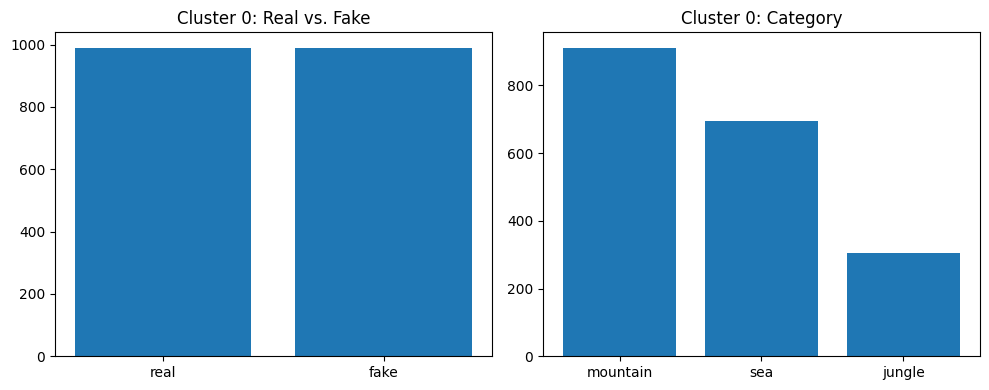


Cluster 1:
Real vs. Fake:
fake    427
real    388
Name: Real_Fake, dtype: int64

Category:
jungle      710
mountain     44
sea           8
Name: Category, dtype: int64


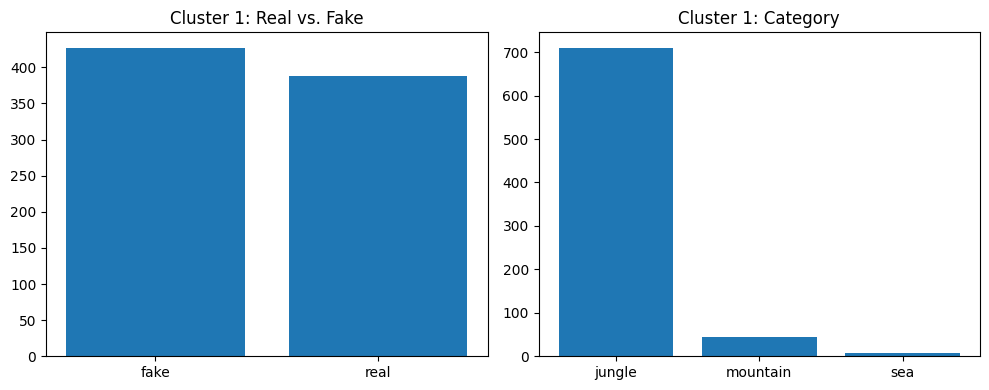


Cluster 2:
Real vs. Fake:
real    329
fake    295
Name: Real_Fake, dtype: int64

Category:
sea         397
mountain    165
jungle       43
Name: Category, dtype: int64


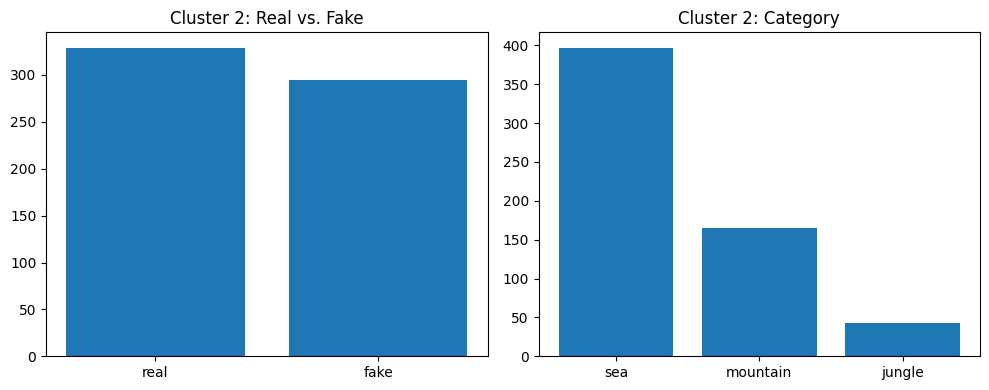

Silhouette Score for 6 Clusters: 0.03868387826342073

Cluster 0:
Real vs. Fake:
real    748
fake    737
Name: Real_Fake, dtype: int64

Category:
mountain    678
sea         592
jungle      170
Name: Category, dtype: int64


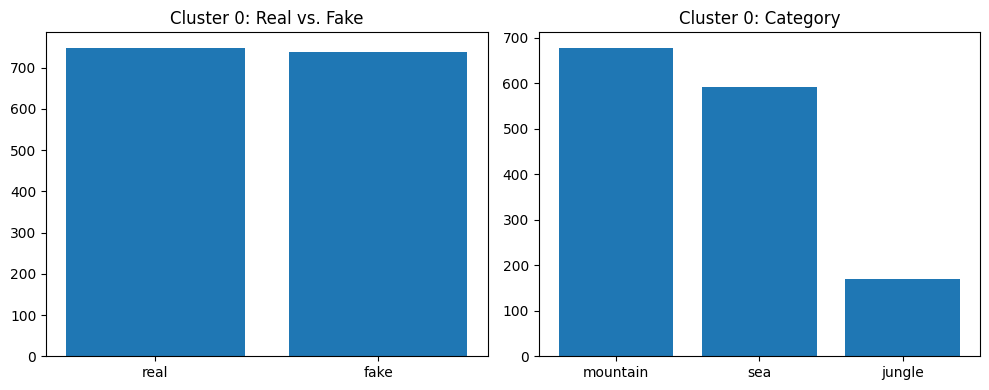


Cluster 1:
Real vs. Fake:
real    264
fake    198
Name: Real_Fake, dtype: int64

Category:
jungle      366
mountain     55
sea           5
Name: Category, dtype: int64


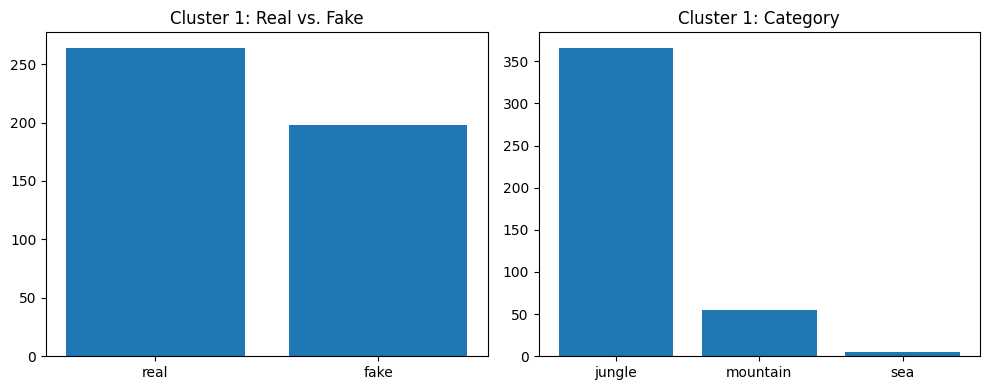


Cluster 2:
Real vs. Fake:
real    269
fake    246
Name: Real_Fake, dtype: int64

Category:
sea         336
mountain    136
jungle       27
Name: Category, dtype: int64


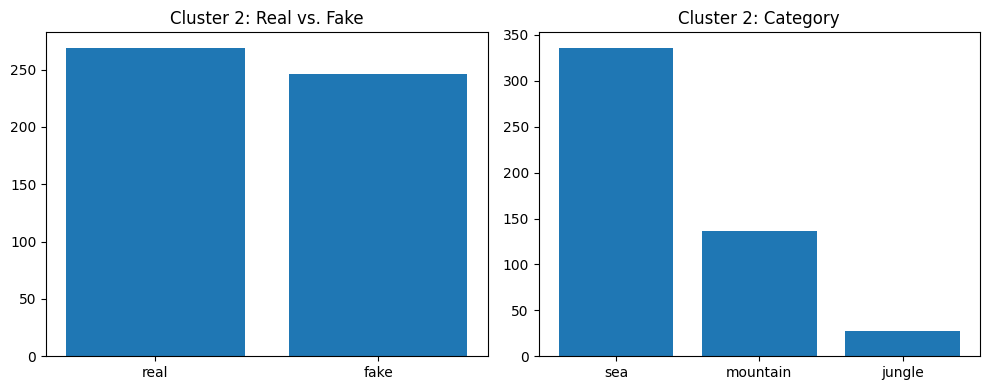


Cluster 3:
Real vs. Fake:
fake    184
real    168
Name: Real_Fake, dtype: int64

Category:
mountain    166
sea         120
jungle       57
Name: Category, dtype: int64


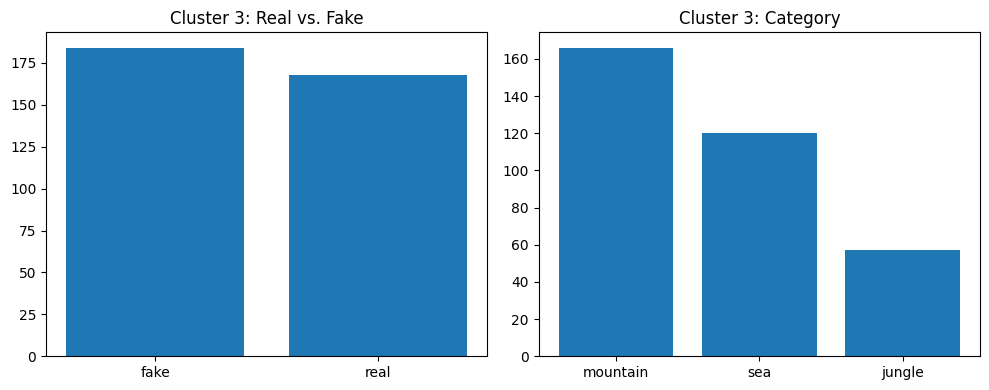


Cluster 4:
Real vs. Fake:
fake    132
real    107
Name: Real_Fake, dtype: int64

Category:
jungle      108
mountain     77
sea          45
Name: Category, dtype: int64


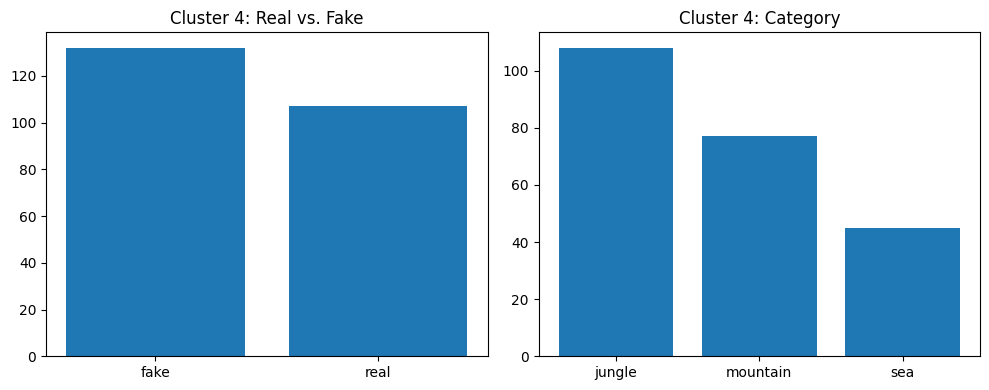


Cluster 5:
Real vs. Fake:
fake    213
real    151
Name: Real_Fake, dtype: int64

Category:
jungle      329
mountain      8
sea           1
Name: Category, dtype: int64


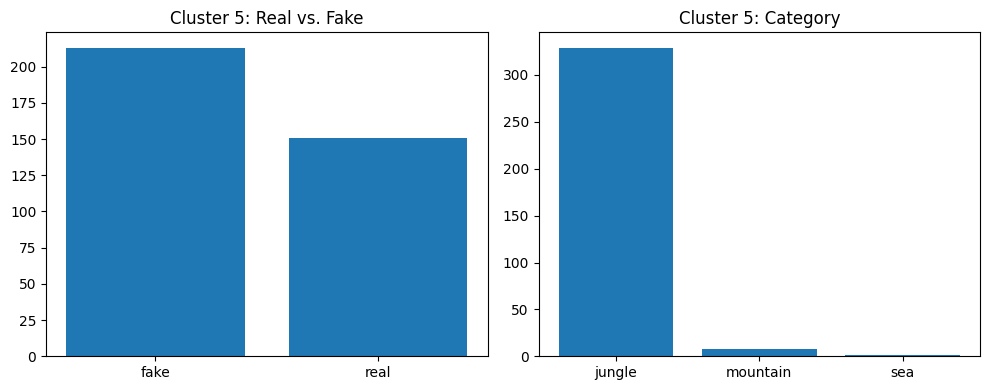

Silhouette Score for 9 Clusters: 0.0017175980276948383

Cluster 0:
Real vs. Fake:
real    158
fake    153
Name: Real_Fake, dtype: int64

Category:
sea         257
mountain     40
jungle        4
Name: Category, dtype: int64

Cluster 1:
Real vs. Fake:
fake    102
real     93
Name: Real_Fake, dtype: int64

Category:
jungle      83
mountain    55
sea         44
Name: Category, dtype: int64

Cluster 2:
Real vs. Fake:
fake    170
real    102
Name: Real_Fake, dtype: int64

Category:
jungle      249
mountain      5
sea           1
Name: Category, dtype: int64

Cluster 3:
Real vs. Fake:
fake    384
real    367
Name: Real_Fake, dtype: int64

Category:
sea         302
mountain    272
jungle      158
Name: Category, dtype: int64

Cluster 4:
Real vs. Fake:
fake    118
real    111
Name: Real_Fake, dtype: int64

Category:
jungle      118
mountain     75
sea          30
Name: Category, dtype: int64

Cluster 5:
Real vs. Fake:
real    265
fake    201
Name: Real_Fake, dtype: int64

Category:
jungle     

In [ ]:
perform_gmm_clustering(df1, labels1, 2)
perform_gmm_clustering(df1, labels1, 3)
perform_gmm_clustering(df1, labels1, 6)
perform_gmm_clustering(df1, labels1, 9, plot=False)
perform_gmm_clustering(df1, labels1, 50, plot=False)

Silhouette Score for 2 Clusters: 0.2575031569834425

Cluster 0:
Real vs. Fake:
real    935
fake    889
Name: Real_Fake, dtype: int64

Category:
jungle      913
mountain    419
sea         391
Name: Category, dtype: int64


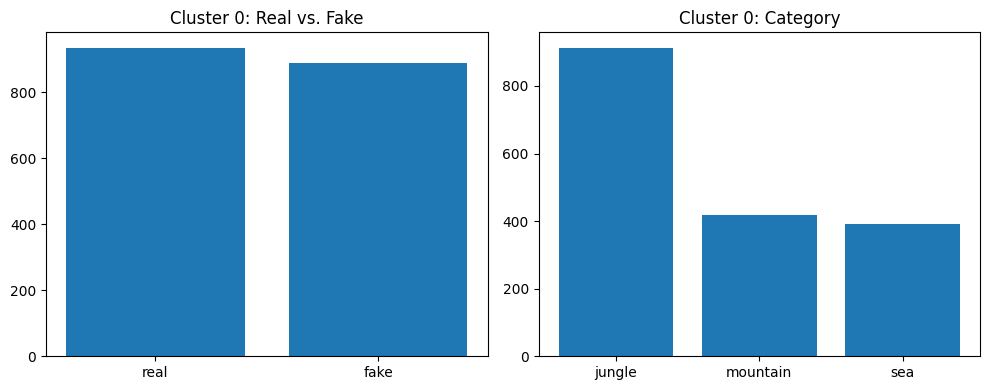


Cluster 1:
Real vs. Fake:
fake    821
real    772
Name: Real_Fake, dtype: int64

Category:
sea         708
mountain    701
jungle      144
Name: Category, dtype: int64


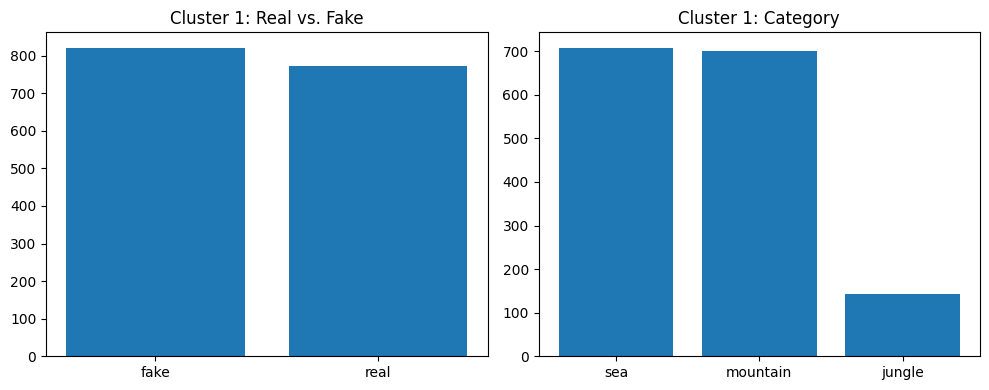

Silhouette Score for 3 Clusters: 0.14266240468916372

Cluster 0:
Real vs. Fake:
real    626
fake    591
Name: Real_Fake, dtype: int64

Category:
jungle      750
sea         199
mountain    188
Name: Category, dtype: int64


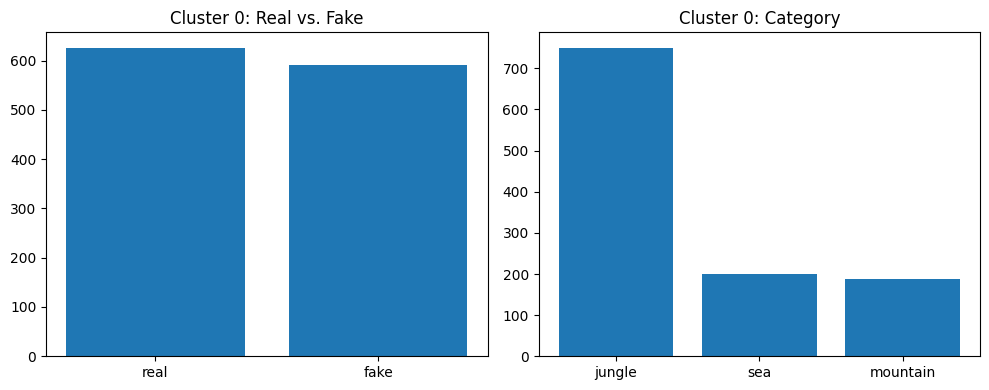


Cluster 1:
Real vs. Fake:
real    659
fake    583
Name: Real_Fake, dtype: int64

Category:
mountain    495
sea         454
jungle      259
Name: Category, dtype: int64


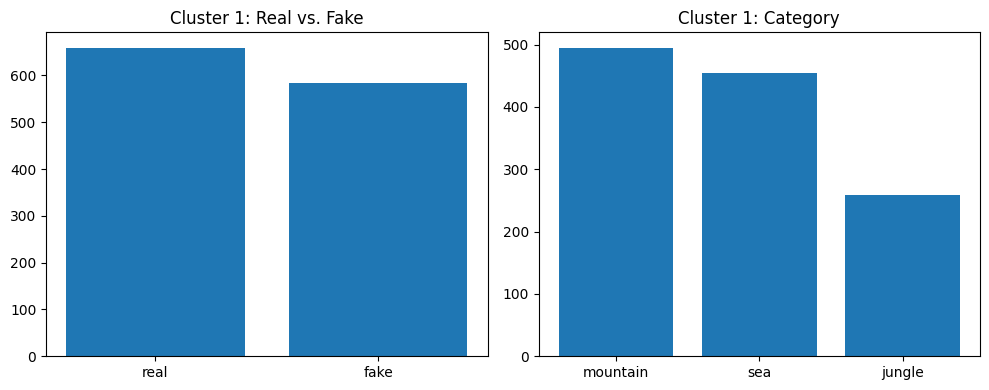


Cluster 2:
Real vs. Fake:
fake    536
real    422
Name: Real_Fake, dtype: int64

Category:
sea         446
mountain    437
jungle       48
Name: Category, dtype: int64


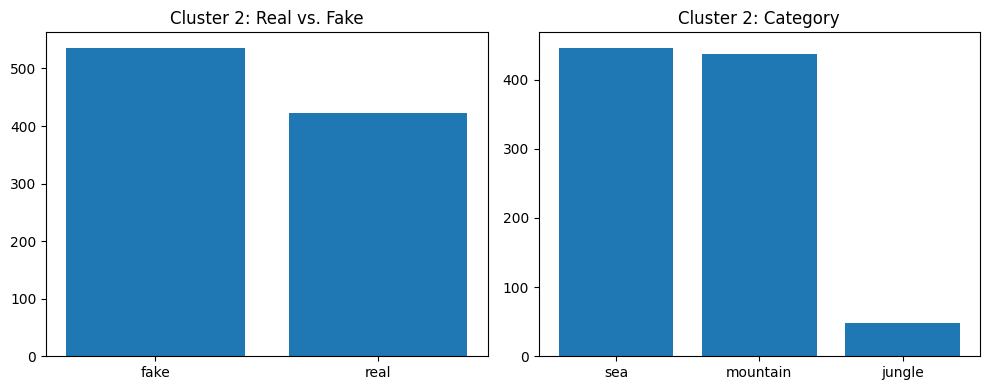

Silhouette Score for 6 Clusters: 0.09511221942623262

Cluster 0:
Real vs. Fake:
real    488
fake    436
Name: Real_Fake, dtype: int64

Category:
jungle      623
sea         130
mountain    103
Name: Category, dtype: int64


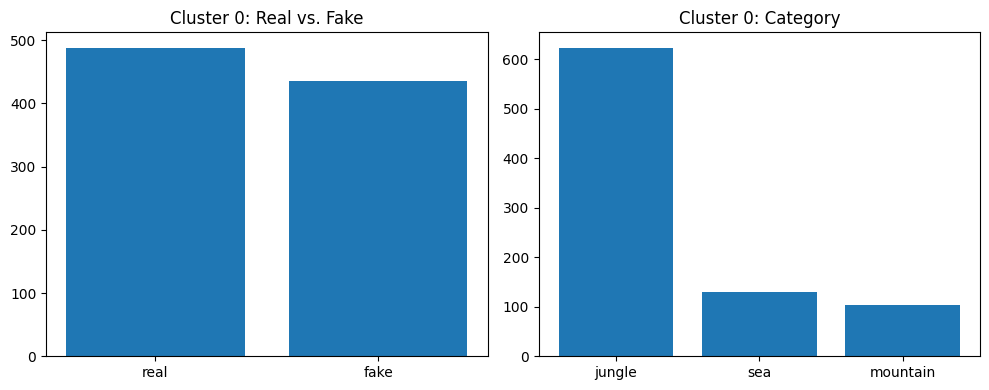


Cluster 1:
Real vs. Fake:
fake    182
real    119
Name: Real_Fake, dtype: int64

Category:
sea         171
mountain     90
jungle       36
Name: Category, dtype: int64


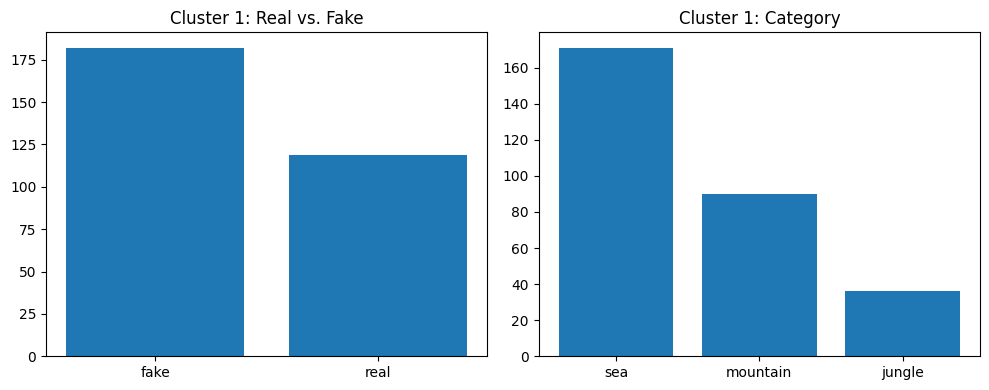


Cluster 2:
Real vs. Fake:
real    380
fake    322
Name: Real_Fake, dtype: int64

Category:
mountain    376
sea         258
jungle       42
Name: Category, dtype: int64


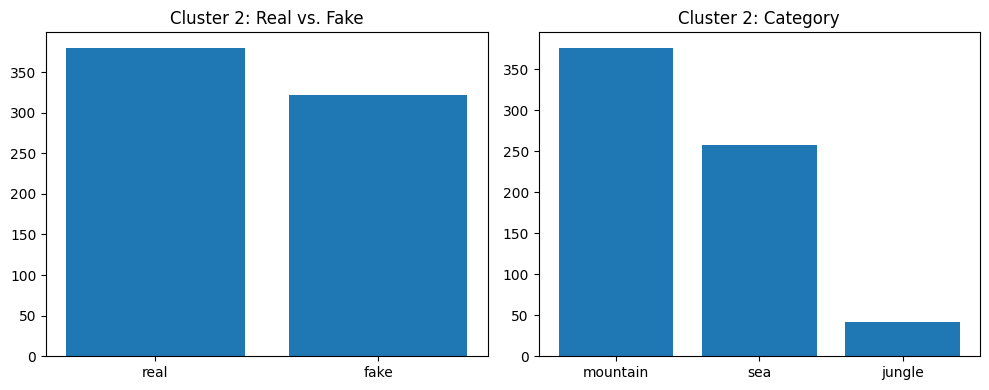


Cluster 3:
Real vs. Fake:
fake    114
real     82
Name: Real_Fake, dtype: int64

Category:
sea         100
mountain     75
jungle       15
Name: Category, dtype: int64


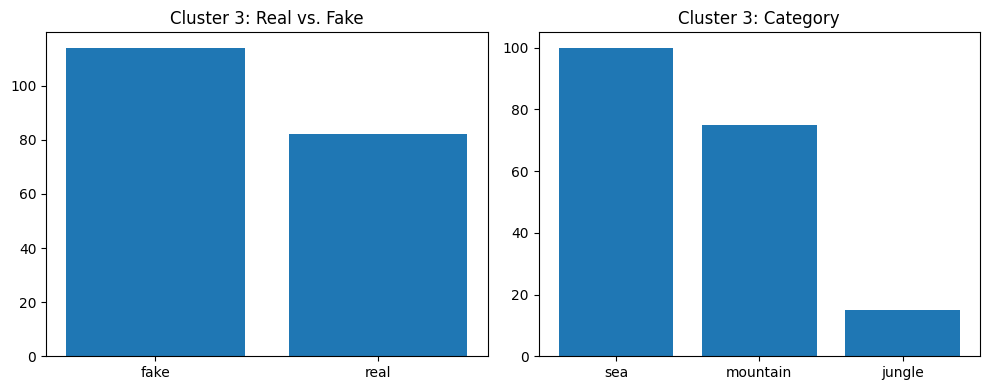


Cluster 4:
Real vs. Fake:
real    534
fake    509
Name: Real_Fake, dtype: int64

Category:
mountain    378
jungle      319
sea         310
Name: Category, dtype: int64


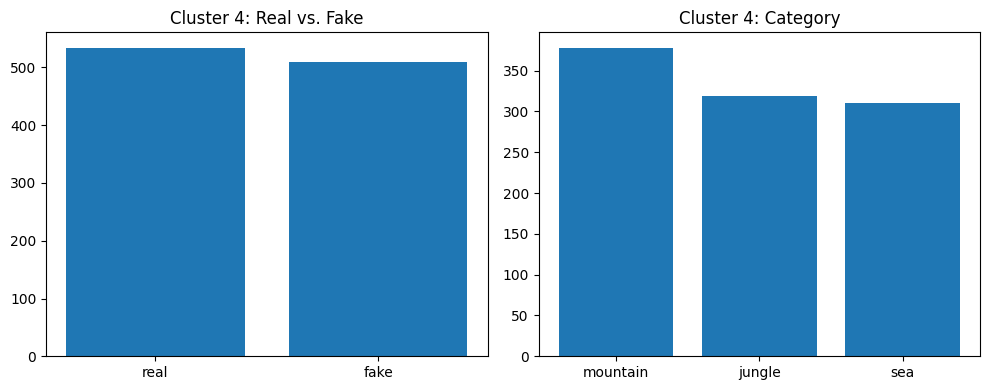


Cluster 5:
Real vs. Fake:
fake    147
real    104
Name: Real_Fake, dtype: int64

Category:
sea         130
mountain     98
jungle       22
Name: Category, dtype: int64


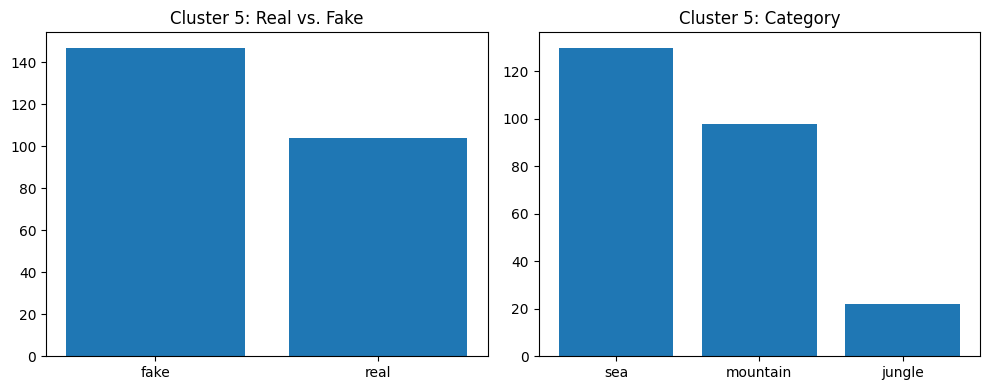

Silhouette Score for 9 Clusters: 0.04445869149677471

Cluster 0:
Real vs. Fake:
fake    69
real    51
Name: Real_Fake, dtype: int64

Category:
mountain    55
sea         48
jungle      17
Name: Category, dtype: int64

Cluster 1:
Real vs. Fake:
real    337
fake    217
Name: Real_Fake, dtype: int64

Category:
mountain    273
sea         185
jungle       78
Name: Category, dtype: int64

Cluster 2:
Real vs. Fake:
fake    379
real    344
Name: Real_Fake, dtype: int64

Category:
jungle      324
mountain    190
sea         176
Name: Category, dtype: int64

Cluster 3:
Real vs. Fake:
real    155
fake    152
Name: Real_Fake, dtype: int64

Category:
mountain    180
sea         106
jungle        7
Name: Category, dtype: int64

Cluster 4:
Real vs. Fake:
fake    237
real    214
Name: Real_Fake, dtype: int64

Category:
sea         184
mountain    159
jungle       97
Name: Category, dtype: int64

Cluster 5:
Real vs. Fake:
fake    73
real    42
Name: Real_Fake, dtype: int64

Category:
sea         57
mo

In [ ]:
perform_gmm_clustering(df2, labels2, 2)
perform_gmm_clustering(df2, labels2, 3)
perform_gmm_clustering(df2, labels2, 6)
perform_gmm_clustering(df2, labels2, 9, plot=False)
perform_gmm_clustering(df2, labels2, 50, plot=False)

Silhouette Score for 2 Clusters: 0.08777901159323775

Cluster 0:
Real vs. Fake:
real    980
fake    808
Name: Real_Fake, dtype: int64

Category:
jungle      993
mountain    482
sea         219
Name: Category, dtype: int64


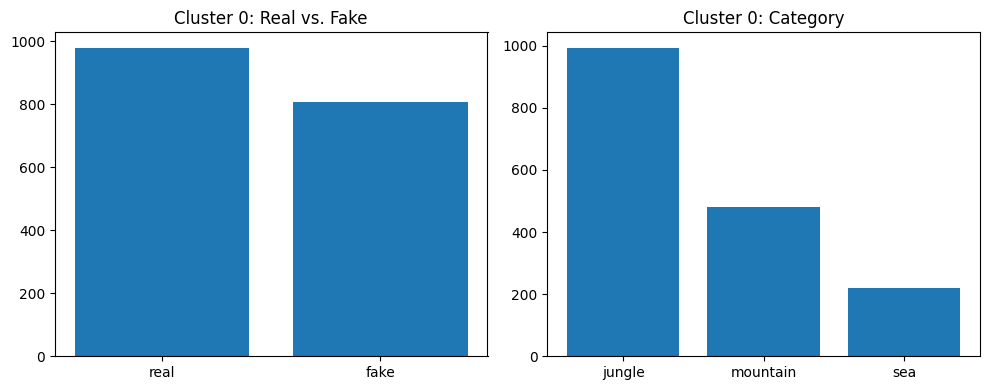


Cluster 1:
Real vs. Fake:
fake    902
real    727
Name: Real_Fake, dtype: int64

Category:
sea         880
mountain    638
jungle       64
Name: Category, dtype: int64


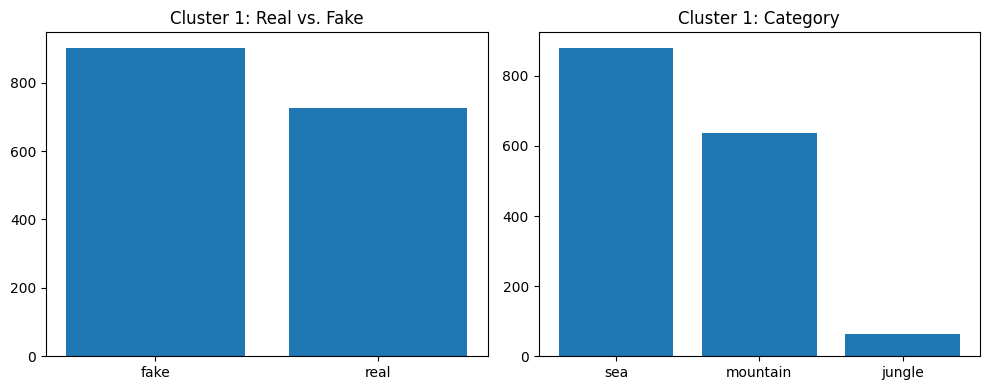

Silhouette Score for 3 Clusters: 0.046119818990912755

Cluster 0:
Real vs. Fake:
real    824
fake    585
Name: Real_Fake, dtype: int64

Category:
mountain    785
sea         420
jungle      158
Name: Category, dtype: int64


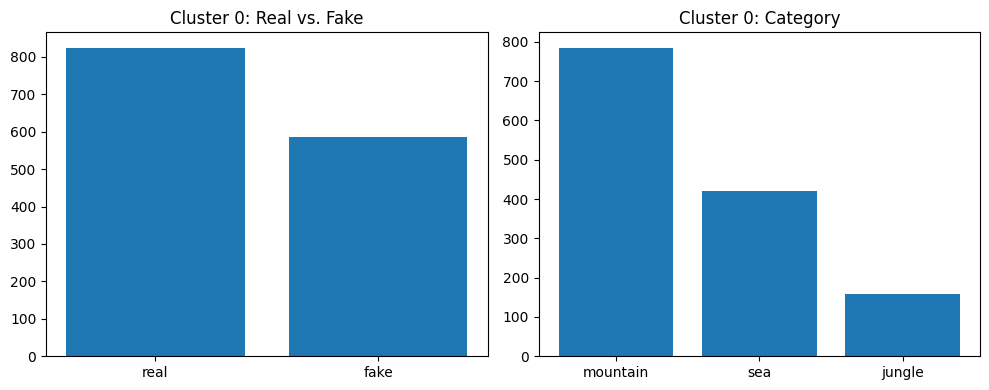


Cluster 1:
Real vs. Fake:
real    586
fake    561
Name: Real_Fake, dtype: int64

Category:
jungle      887
mountain    106
sea          78
Name: Category, dtype: int64


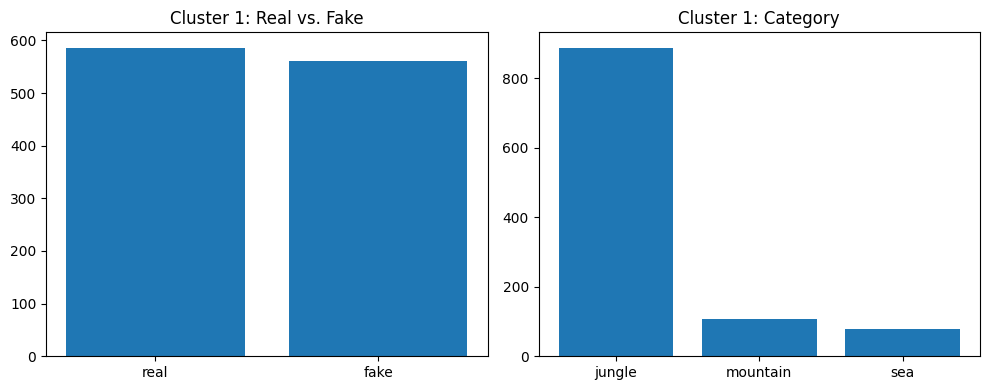


Cluster 2:
Real vs. Fake:
fake    564
real    297
Name: Real_Fake, dtype: int64

Category:
sea         601
mountain    229
jungle       12
Name: Category, dtype: int64


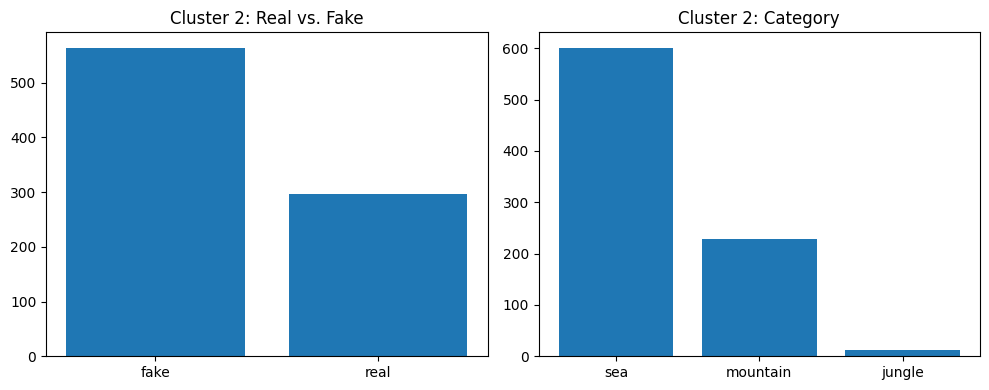

Silhouette Score for 6 Clusters: 0.019418242389404938

Cluster 0:
Real vs. Fake:
fake    288
real    280
Name: Real_Fake, dtype: int64

Category:
sea         330
mountain    186
jungle       39
Name: Category, dtype: int64


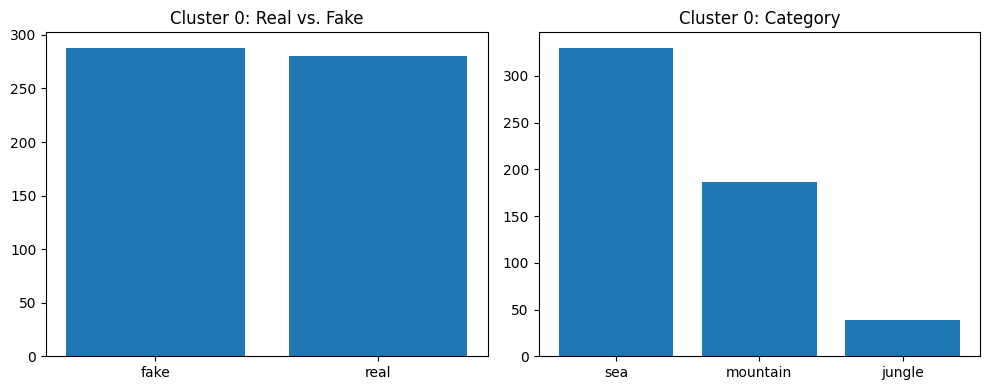


Cluster 1:
Real vs. Fake:
fake    255
real    246
Name: Real_Fake, dtype: int64

Category:
sea         259
mountain    202
jungle       22
Name: Category, dtype: int64


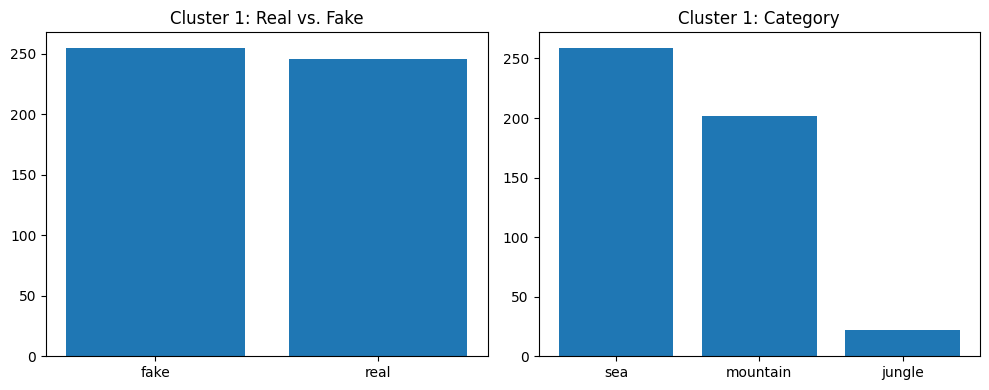


Cluster 2:
Real vs. Fake:
fake    163
real    108
Name: Real_Fake, dtype: int64

Category:
jungle      225
sea           8
mountain      4
Name: Category, dtype: int64


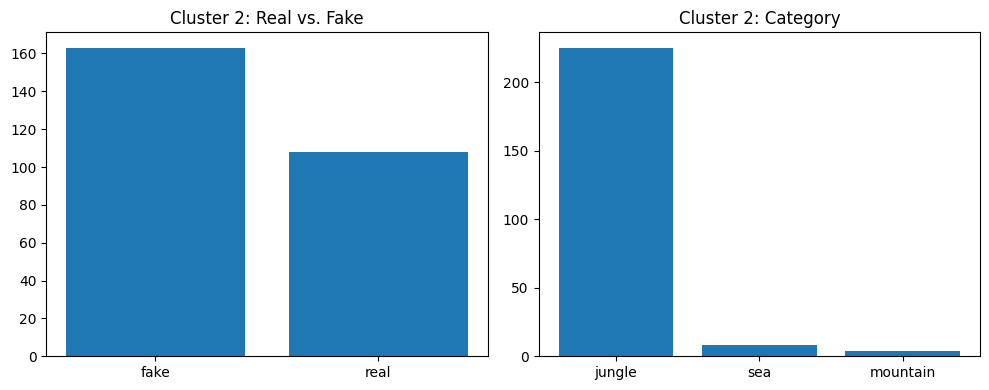


Cluster 3:
Real vs. Fake:
fake    293
real    107
Name: Real_Fake, dtype: int64

Category:
sea         302
mountain     88
jungle        1
Name: Category, dtype: int64


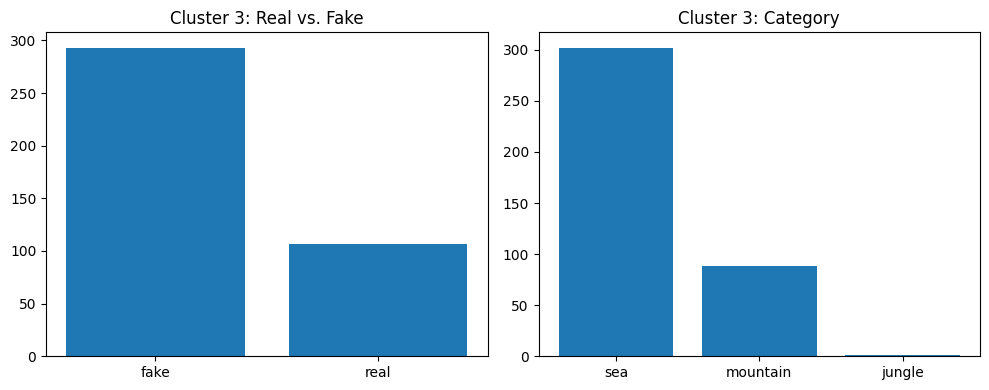


Cluster 4:
Real vs. Fake:
real    525
fake    427
Name: Real_Fake, dtype: int64

Category:
jungle      689
mountain    131
sea          86
Name: Category, dtype: int64


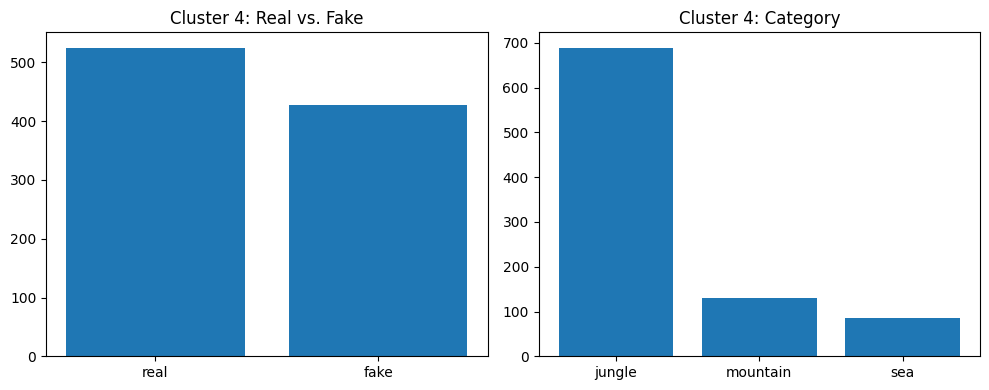


Cluster 5:
Real vs. Fake:
real    441
fake    284
Name: Real_Fake, dtype: int64

Category:
mountain    509
sea         114
jungle       81
Name: Category, dtype: int64


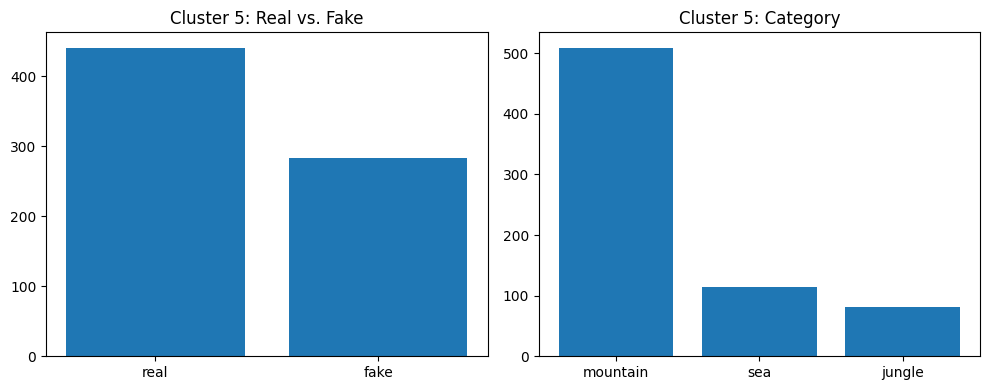

Silhouette Score for 9 Clusters: 0.014535390410559217

Cluster 0:
Real vs. Fake:
fake    146
real     92
Name: Real_Fake, dtype: int64

Category:
sea         121
mountain     83
jungle       27
Name: Category, dtype: int64

Cluster 1:
Real vs. Fake:
real    184
fake    162
Name: Real_Fake, dtype: int64

Category:
sea         249
mountain     78
jungle       13
Name: Category, dtype: int64

Cluster 2:
Real vs. Fake:
real    246
fake    168
Name: Real_Fake, dtype: int64

Category:
mountain    253
sea         117
jungle       28
Name: Category, dtype: int64

Cluster 3:
Real vs. Fake:
fake    170
real    115
Name: Real_Fake, dtype: int64

Category:
sea         213
mountain     61
jungle        3
Name: Category, dtype: int64

Cluster 4:
Real vs. Fake:
fake    146
real    102
Name: Real_Fake, dtype: int64

Category:
jungle      208
sea           5
mountain      3
Name: Category, dtype: int64

Cluster 5:
Real vs. Fake:
real    439
fake    387
Name: Real_Fake, dtype: int64

Category:
jungle   

In [ ]:
perform_gmm_clustering(df3, labels3, 2)
perform_gmm_clustering(df3, labels3, 3)
perform_gmm_clustering(df3, labels3, 6)
perform_gmm_clustering(df3, labels3, 9, plot=False)
perform_gmm_clustering(df3, labels3, 50, plot=False)

Silhouette Score for 2 Clusters: 0.26919016234245446

Cluster 0:
Real vs. Fake:
fake    620
real    570
Name: Real_Fake, dtype: int64

Category:
mountain    553
sea         466
jungle      138
Name: Category, dtype: int64


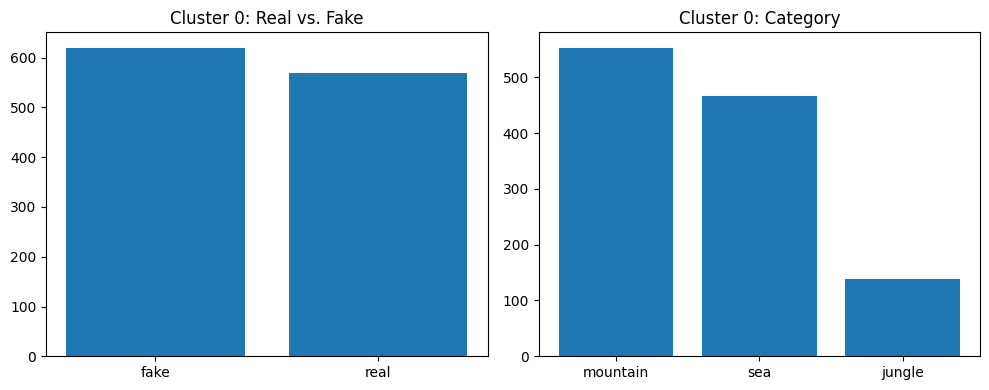


Cluster 1:
Real vs. Fake:
real    1137
fake    1090
Name: Real_Fake, dtype: int64

Category:
jungle      919
sea         633
mountain    567
Name: Category, dtype: int64


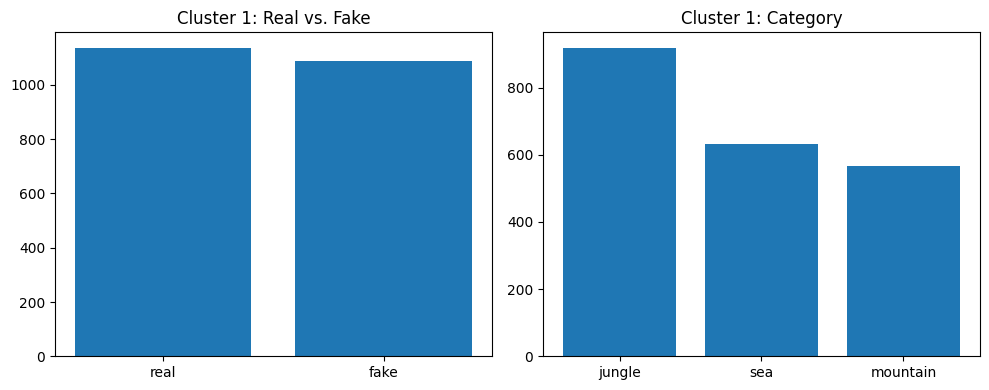

Silhouette Score for 3 Clusters: 0.2841065193992491

Cluster 0:
Real vs. Fake:
real    515
fake    499
Name: Real_Fake, dtype: int64

Category:
jungle      708
mountain    122
sea         109
Name: Category, dtype: int64


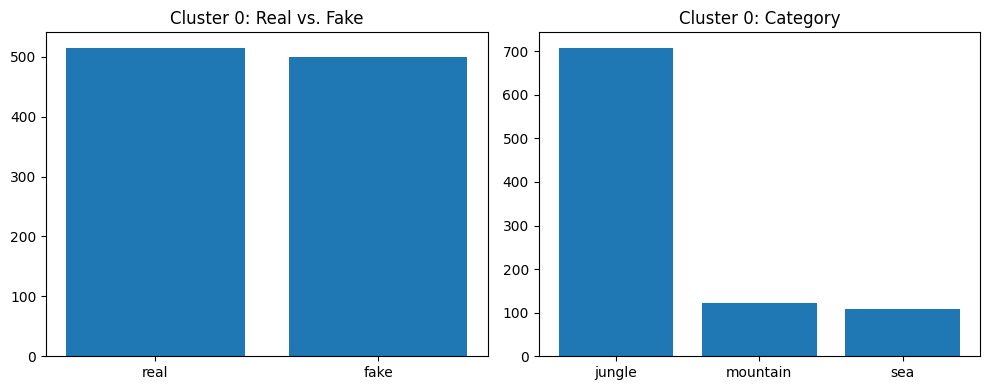


Cluster 1:
Real vs. Fake:
fake    840
real    786
Name: Real_Fake, dtype: int64

Category:
sea         776
mountain    622
jungle      190
Name: Category, dtype: int64


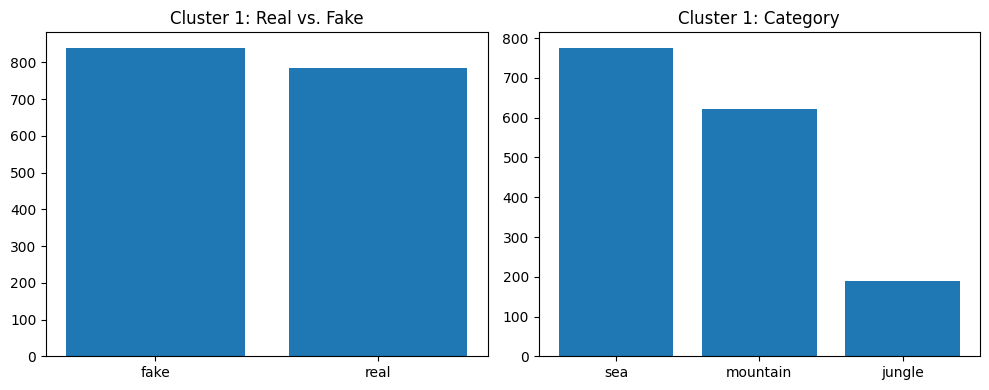


Cluster 2:
Real vs. Fake:
real    406
fake    371
Name: Real_Fake, dtype: int64

Category:
mountain    376
sea         214
jungle      159
Name: Category, dtype: int64


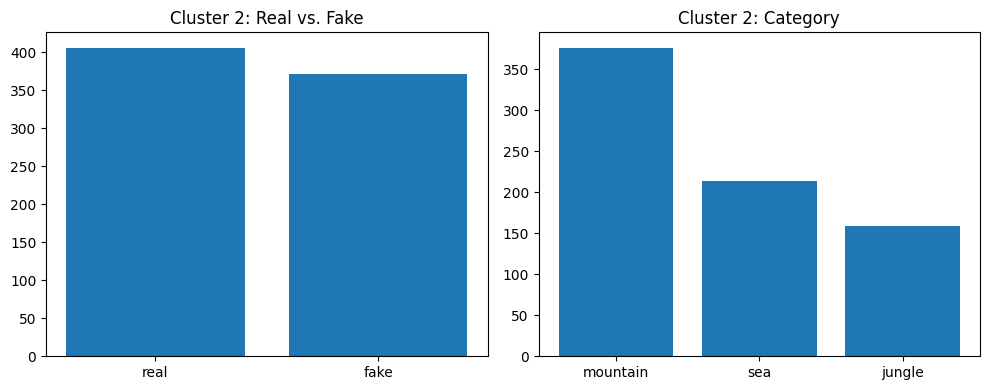

Silhouette Score for 6 Clusters: 0.158631026243213

Cluster 0:
Real vs. Fake:
fake    627
real    586
Name: Real_Fake, dtype: int64

Category:
sea         570
mountain    436
jungle      177
Name: Category, dtype: int64


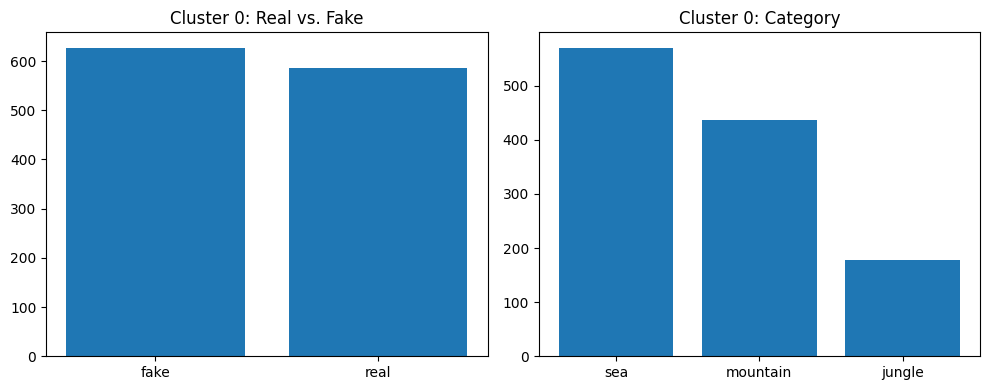


Cluster 1:
Real vs. Fake:
real    357
fake    319
Name: Real_Fake, dtype: int64

Category:
jungle      542
sea          49
mountain     31
Name: Category, dtype: int64


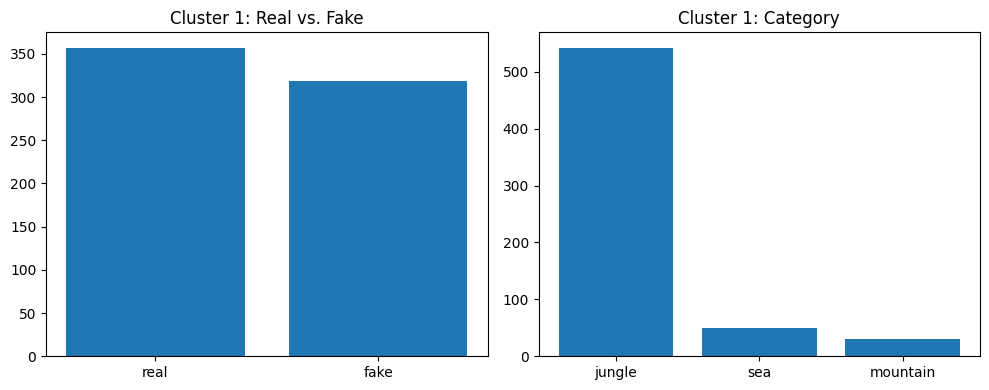


Cluster 2:
Real vs. Fake:
real    94
fake    85
Name: Real_Fake, dtype: int64

Category:
mountain    101
sea          38
jungle       35
Name: Category, dtype: int64


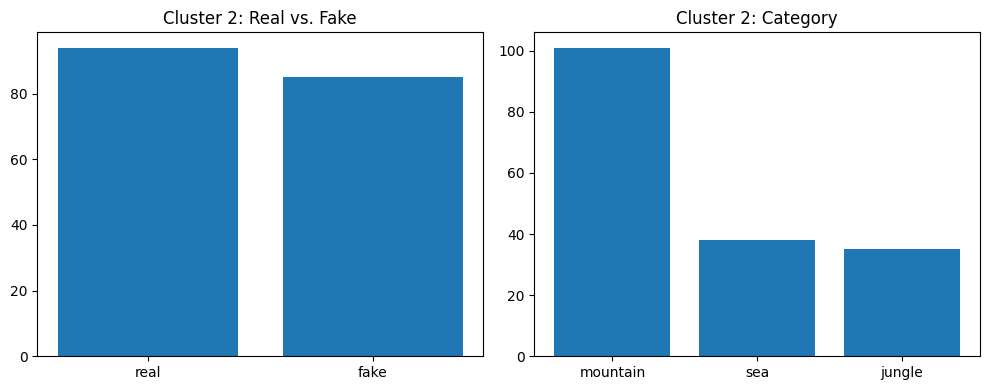


Cluster 3:
Real vs. Fake:
fake    322
real    205
Name: Real_Fake, dtype: int64

Category:
sea         275
mountain    203
jungle       33
Name: Category, dtype: int64


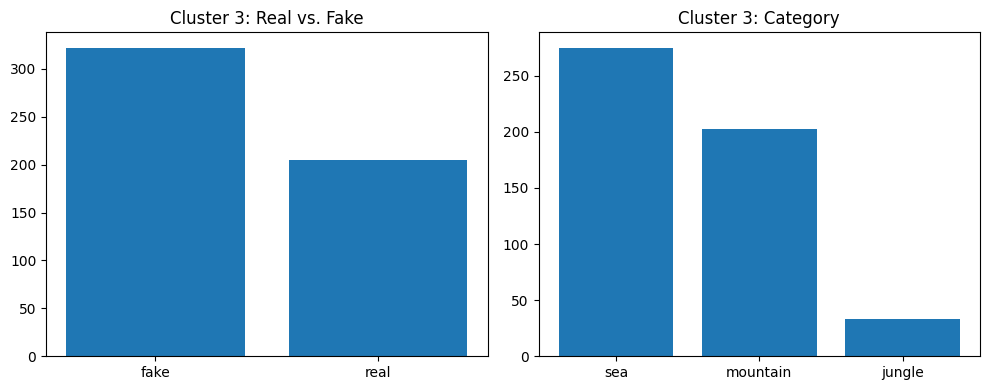


Cluster 4:
Real vs. Fake:
real    307
fake    192
Name: Real_Fake, dtype: int64

Category:
mountain    261
sea         118
jungle      106
Name: Category, dtype: int64


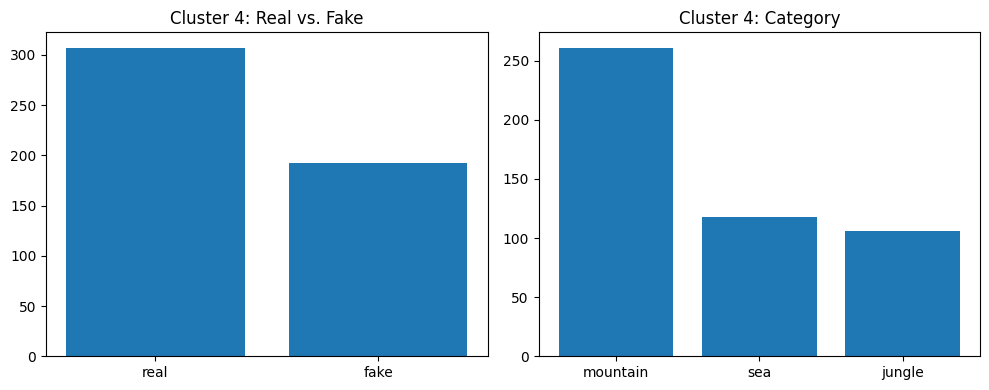


Cluster 5:
Real vs. Fake:
fake    165
real    158
Name: Real_Fake, dtype: int64

Category:
jungle      164
mountain     88
sea          49
Name: Category, dtype: int64


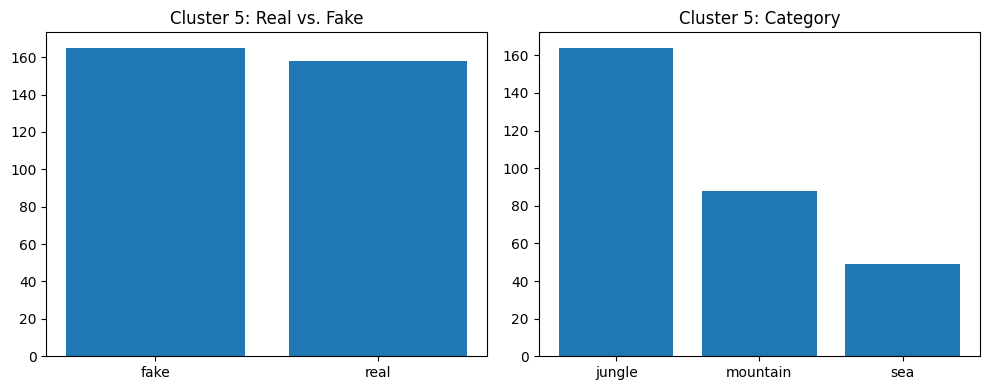

Silhouette Score for 9 Clusters: 0.10892461680239082

Cluster 0:
Real vs. Fake:
fake    272
real    229
Name: Real_Fake, dtype: int64

Category:
sea         289
mountain    184
jungle       20
Name: Category, dtype: int64

Cluster 1:
Real vs. Fake:
real    105
fake     95
Name: Real_Fake, dtype: int64

Category:
jungle      129
sea          30
mountain     27
Name: Category, dtype: int64

Cluster 2:
Real vs. Fake:
fake    27
real    15
Name: Real_Fake, dtype: int64

Category:
mountain    23
sea         14
jungle       5
Name: Category, dtype: int64

Cluster 3:
Real vs. Fake:
fake    383
real    365
Name: Real_Fake, dtype: int64

Category:
sea         349
mountain    276
jungle      105
Name: Category, dtype: int64

Cluster 4:
Real vs. Fake:
real    308
fake    265
Name: Real_Fake, dtype: int64

Category:
jungle      480
sea          27
mountain     17
Name: Category, dtype: int64

Cluster 5:
Real vs. Fake:
real    289
fake    176
Name: Real_Fake, dtype: int64

Category:
mountain    238

In [ ]:
perform_gmm_clustering(df4, labels4, 2)
perform_gmm_clustering(df4, labels4, 3)
perform_gmm_clustering(df4, labels4, 6)
perform_gmm_clustering(df4, labels4, 9, plot=False)
perform_gmm_clustering(df4, labels4, 50, plot=False)

Silhouette Score for 2 Clusters: 0.19030377406239787

Cluster 0:
Real vs. Fake:
real    863
fake    828
Name: Real_Fake, dtype: int64

Category:
sea         788
mountain    658
jungle      186
Name: Category, dtype: int64


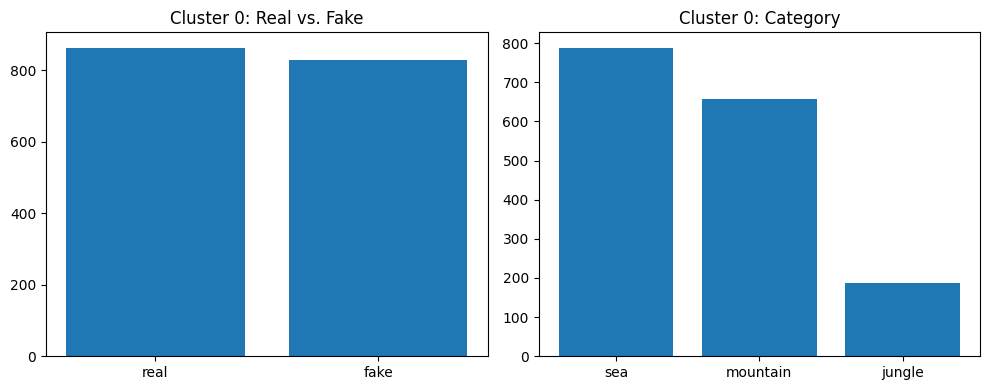


Cluster 1:
Real vs. Fake:
fake    882
real    844
Name: Real_Fake, dtype: int64

Category:
jungle      871
mountain    462
sea         311
Name: Category, dtype: int64


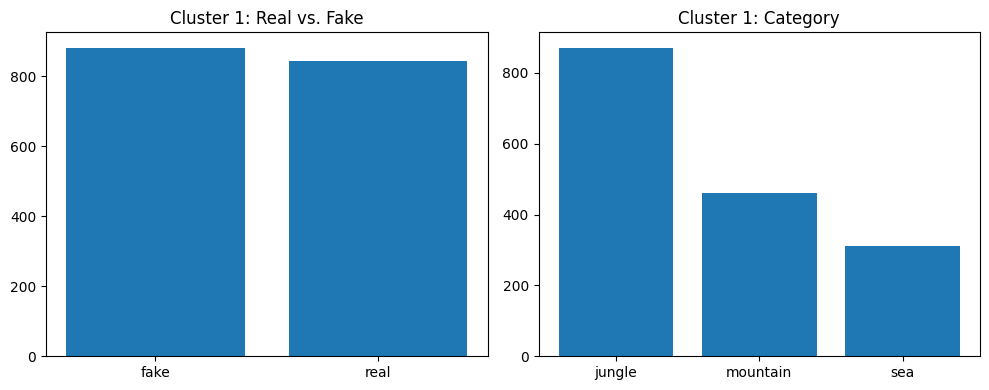

Silhouette Score for 3 Clusters: 0.16385461706909493

Cluster 0:
Real vs. Fake:
fake    720
real    676
Name: Real_Fake, dtype: int64

Category:
jungle      784
mountain    300
sea         236
Name: Category, dtype: int64


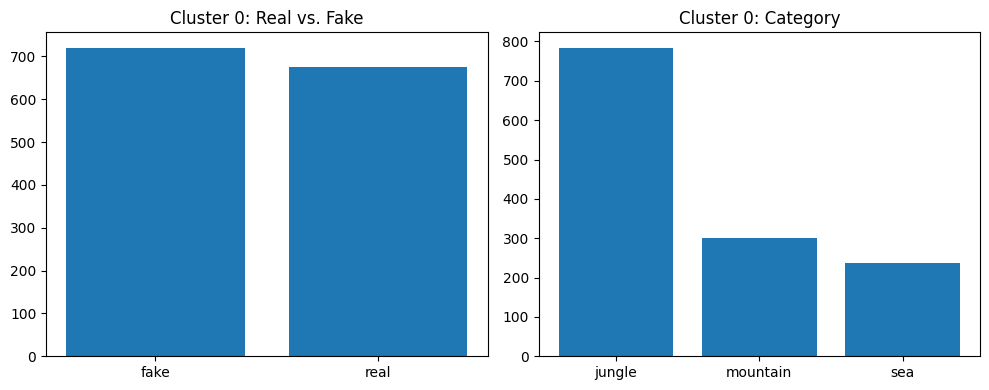


Cluster 1:
Real vs. Fake:
real    616
fake    504
Name: Real_Fake, dtype: int64

Category:
mountain    561
sea         346
jungle      183
Name: Category, dtype: int64


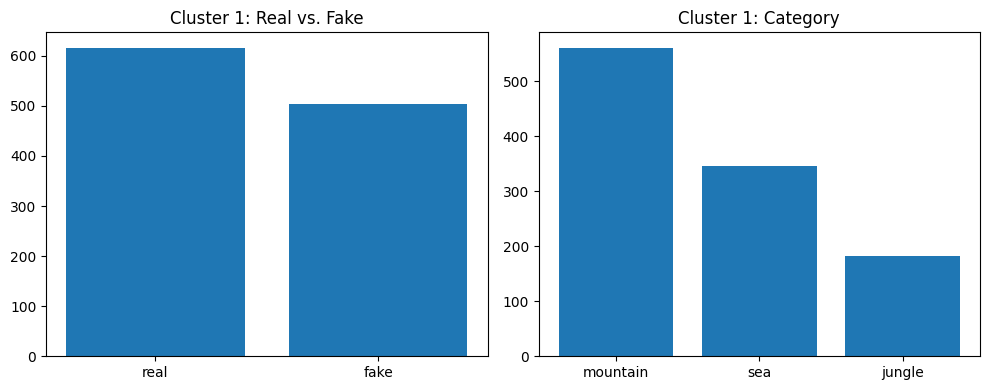


Cluster 2:
Real vs. Fake:
fake    486
real    415
Name: Real_Fake, dtype: int64

Category:
sea         517
mountain    259
jungle       90
Name: Category, dtype: int64


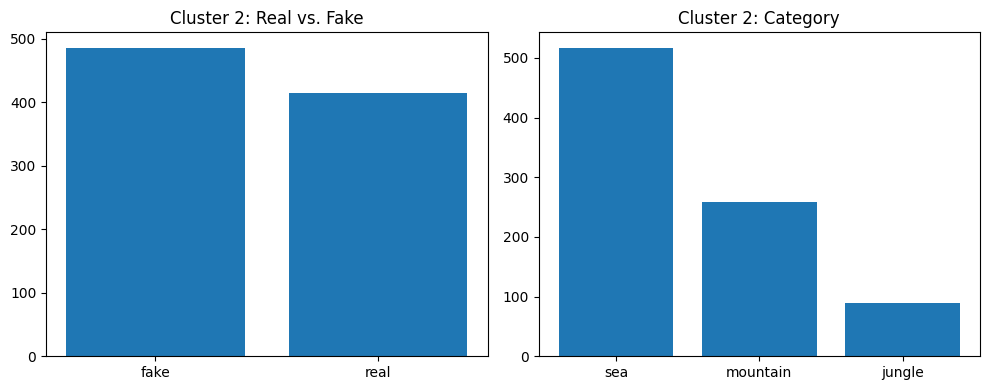

Silhouette Score for 6 Clusters: 0.10144724092037452

Cluster 0:
Real vs. Fake:
fake    339
real    232
Name: Real_Fake, dtype: int64

Category:
sea         260
mountain    209
jungle       79
Name: Category, dtype: int64


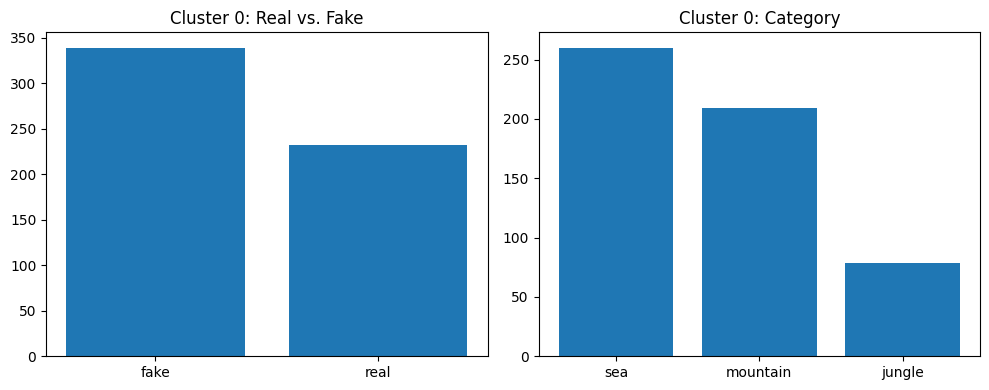


Cluster 1:
Real vs. Fake:
real    285
fake    229
Name: Real_Fake, dtype: int64

Category:
jungle      345
mountain     93
sea          61
Name: Category, dtype: int64


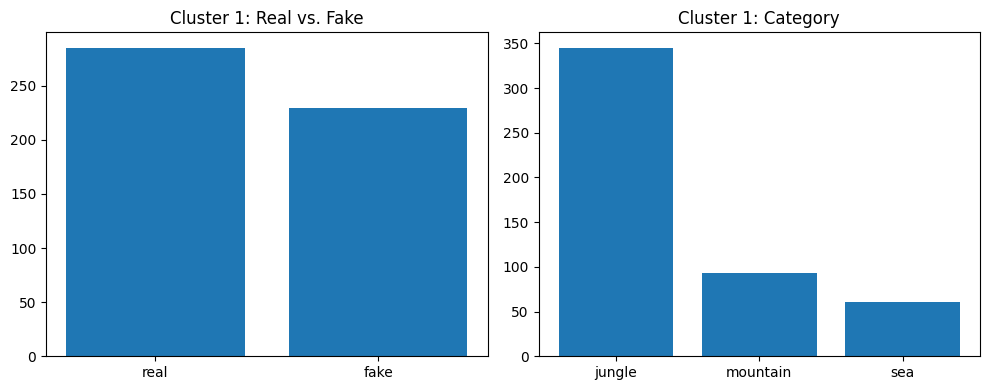


Cluster 2:
Real vs. Fake:
real    244
fake    240
Name: Real_Fake, dtype: int64

Category:
sea         279
mountain    140
jungle       49
Name: Category, dtype: int64


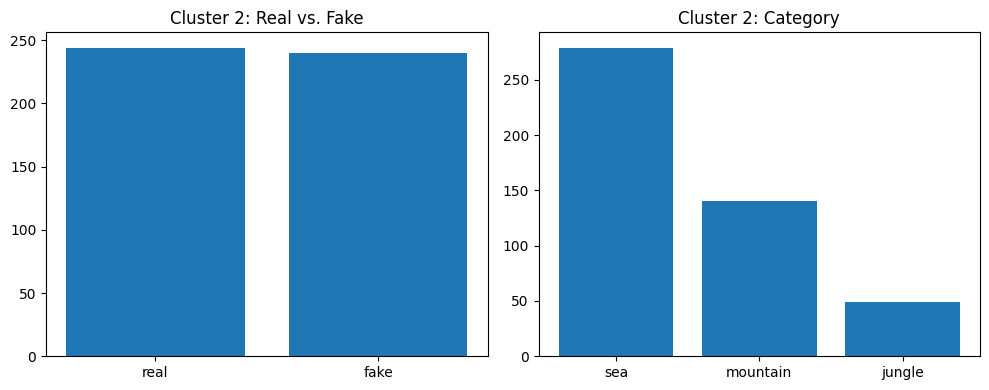


Cluster 3:
Real vs. Fake:
fake    410
real    339
Name: Real_Fake, dtype: int64

Category:
jungle      389
mountain    156
sea         149
Name: Category, dtype: int64


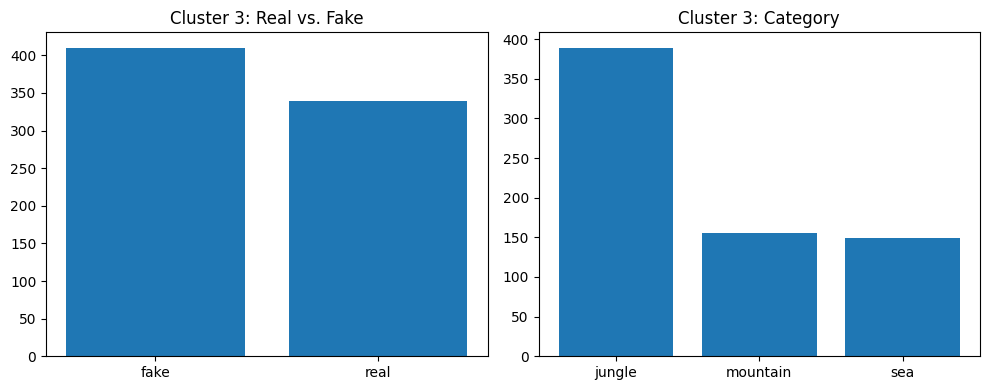


Cluster 4:
Real vs. Fake:
real    282
fake    169
Name: Real_Fake, dtype: int64

Category:
sea         220
mountain    185
jungle       35
Name: Category, dtype: int64


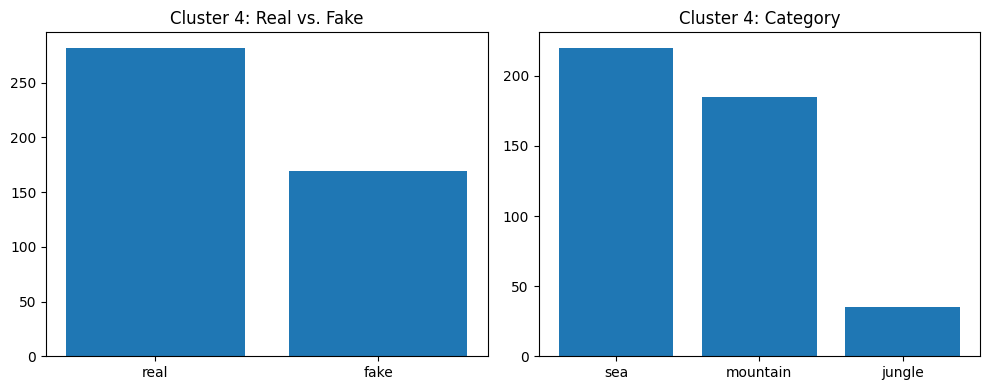


Cluster 5:
Real vs. Fake:
real    325
fake    323
Name: Real_Fake, dtype: int64

Category:
mountain    337
jungle      160
sea         130
Name: Category, dtype: int64


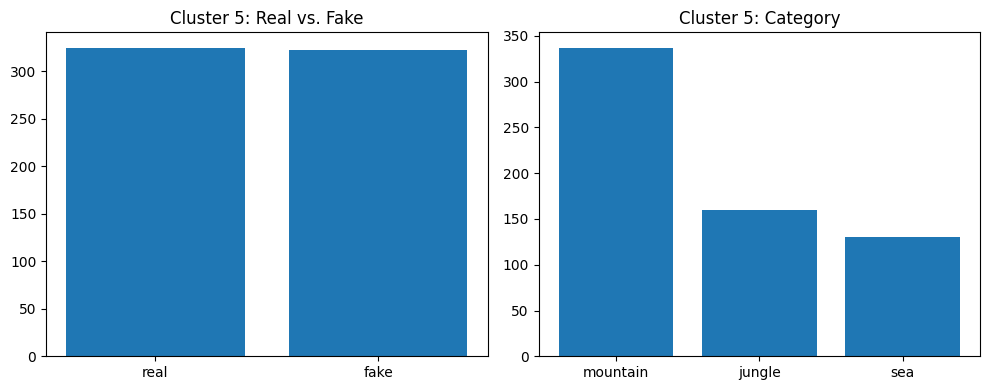

Silhouette Score for 9 Clusters: 0.09150916299342776

Cluster 0:
Real vs. Fake:
real    204
fake    140
Name: Real_Fake, dtype: int64

Category:
mountain    201
jungle       71
sea          64
Name: Category, dtype: int64

Cluster 1:
Real vs. Fake:
fake    238
real    151
Name: Real_Fake, dtype: int64

Category:
mountain    174
sea         133
jungle       71
Name: Category, dtype: int64

Cluster 2:
Real vs. Fake:
real    123
fake     61
Name: Real_Fake, dtype: int64

Category:
sea         115
mountain     50
jungle       10
Name: Category, dtype: int64

Cluster 3:
Real vs. Fake:
fake    257
real    236
Name: Real_Fake, dtype: int64

Category:
mountain    207
sea         169
jungle       95
Name: Category, dtype: int64

Cluster 4:
Real vs. Fake:
fake    279
real    183
Name: Real_Fake, dtype: int64

Category:
jungle      262
mountain    117
sea          66
Name: Category, dtype: int64

Cluster 5:
Real vs. Fake:
fake    228
real    155
Name: Real_Fake, dtype: int64

Category:
sea       

In [ ]:
perform_gmm_clustering(df5, labels5, 2)
perform_gmm_clustering(df5, labels5, 3)
perform_gmm_clustering(df5, labels5, 6)
perform_gmm_clustering(df5, labels5, 9, plot=False)

### HDBSCAN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def best_pca(df, th=0.8):
  # Generate some random high-dimensional data
  np.random.seed(42)
  X = df.iloc[:, :-1].values  # 100 samples, 50 features

  from sklearn.preprocessing import StandardScaler

  scaler = StandardScaler()
  normalized_X = scaler.fit_transform(X)


  # Perform PCA
  pca = PCA()
  pca.fit(normalized_X )

  # Scree plot
  explained_variance_ratio = pca.explained_variance_ratio_
  cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

  # Plot explained variance ratio and cumulative variance ratio
  plt.figure(figsize=(8, 6))
  plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
  plt.plot(np.arange(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
  plt.xlabel('Number of Components')
  plt.ylabel('Explained Variance Ratio')
  plt.title(f'Scree Plot {df.name}')
  plt.legend(['Explained Variance Ratio', 'Cumulative Variance Ratio'])
  plt.grid(True)
  plt.show()

  print(f'\nName of Features: {df.name}')

  # Determine the optimal number of components
  optimal_num_components = np.argmax(cumulative_variance_ratio >= th) + 1
  print("Optimal number of components:", optimal_num_components)

  return optimal_num_components

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from hdbscan import HDBSCAN
from sklearn.metrics import silhouette_score

def reduce_dimensions_and_cluster(data, n_components, min_cluster_size=5):
    # Extract features and labels
    features = data.iloc[:, :-1]
    labels = data.iloc[:, -1]


    # Scale the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Perform PCA dimensionality reduction
    pca = PCA(n_components=n_components, random_state=42)
    reduced_features = pca.fit_transform(scaled_features)

    # Perform clustering using HDBSCAN
    clusterer = HDBSCAN(min_cluster_size=min_cluster_size)
    clusters = clusterer.fit_predict(reduced_features)

    # Compute evaluation metrics
    silhouette = silhouette_score(reduced_features, clusters)

    # Create a new dataframe with reduced features and assigned clusters
    result = pd.DataFrame(reduced_features, columns=[f"Dimension {i+1}" for i in range(n_components)])
    result["Cluster"] = clusters

    return result, silhouette


In [ ]:
import gc
import matplotlib.pyplot as plt
def hdbscan(dataframes):

  for df in dataframes:

    optimal_num_components = best_pca(df, th=0.8)

    n_components = optimal_num_components

    silhouette_scores = []
    for min_cluster_size in range(2, 10):
      _, silhouette = reduce_dimensions_and_cluster(df, n_components, min_cluster_size)
      silhouette_scores.append(silhouette)

    min_cluster_sizes = range(2, 10)

    # Find the maximum silhouette score and its corresponding minimum cluster size
    max_silhouette = max(silhouette_scores)
    max_idx = silhouette_scores.index(max_silhouette)
    best_min_cluster_size = min_cluster_sizes[max_idx]

    plt.plot(min_cluster_sizes, silhouette_scores, marker='o')
    plt.xlabel('Minimum Cluster Size')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Scores for Different Minimum Cluster Sizes {df.name}')
    plt.grid(True)

    # Mark the maximum silhouette score with a red dot
    plt.plot(best_min_cluster_size, max_silhouette, marker='o', markersize=8, color='red')

    # Print the maximum silhouette score
    print(f"The maximum silhouette score is {max_silhouette} at minimum cluster size {best_min_cluster_size}")

    plt.show()

    del df
    gc.collect()



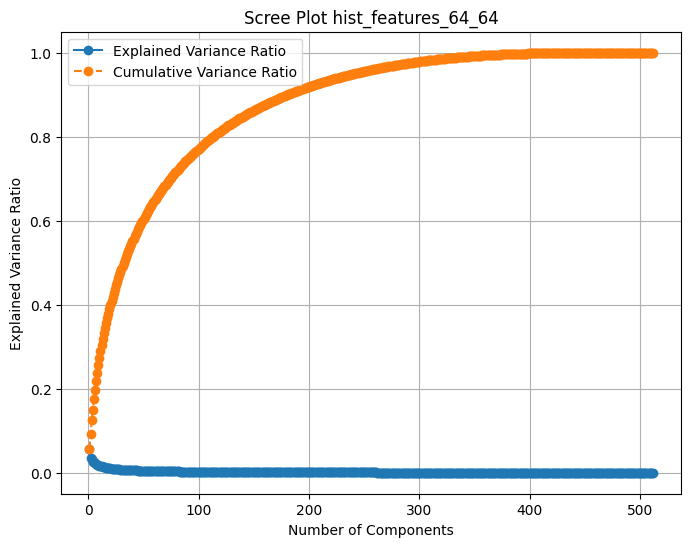


Name of Features: hist_features_64_64
Optimal number of components: 113
The maximum silhouette score is 0.00699489622804947 at minimum cluster size 4


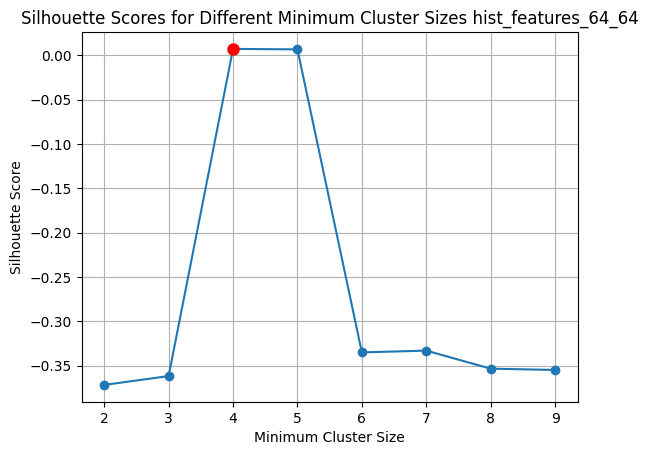

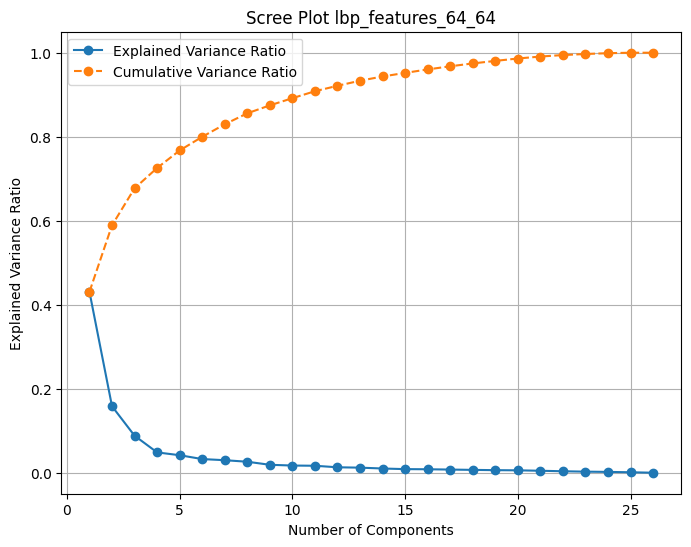


Name of Features: lbp_features_64_64
Optimal number of components: 7
The maximum silhouette score is 0.34692793942944405 at minimum cluster size 4


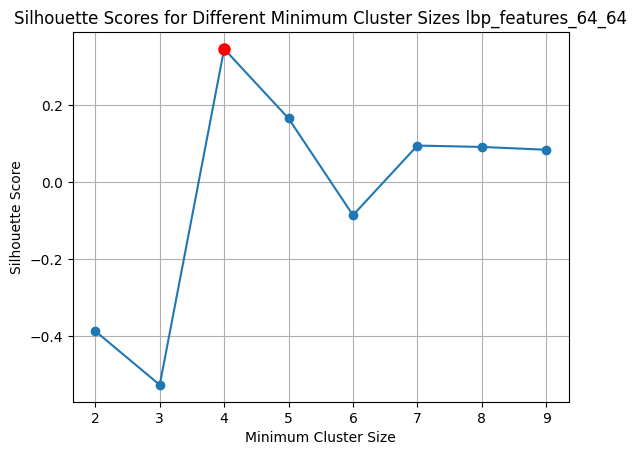

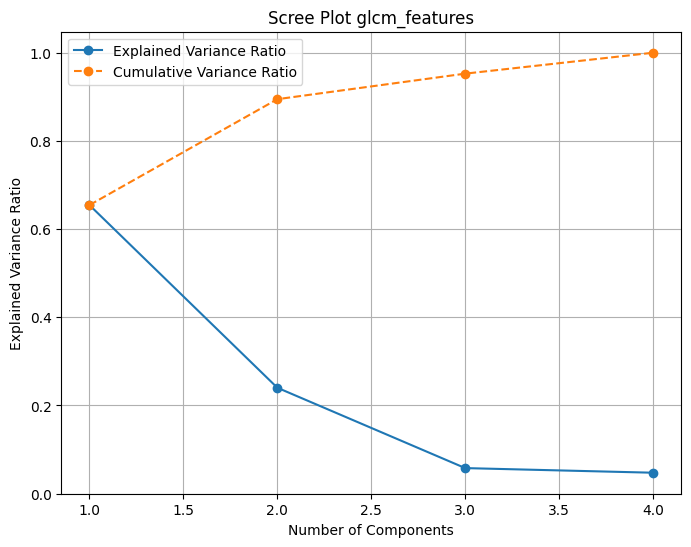


Name of Features: glcm_features
Optimal number of components: 2
The maximum silhouette score is 0.2945361537158352 at minimum cluster size 8


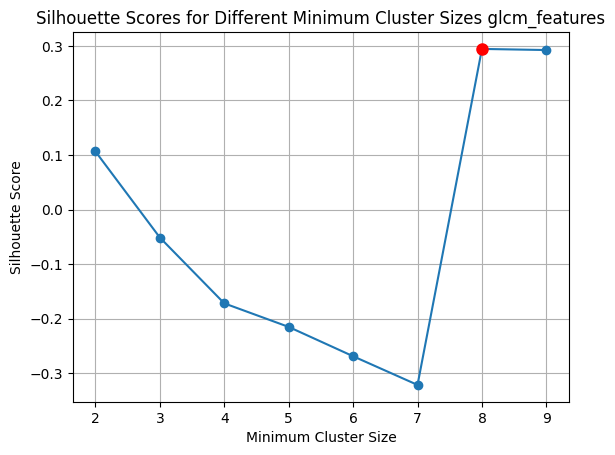

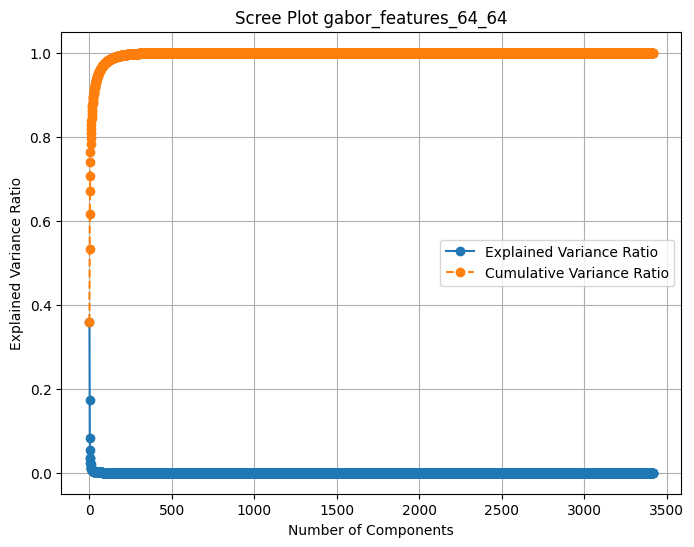


Name of Features: gabor_features_64_64
Optimal number of components: 10
The maximum silhouette score is 0.031067680814166256 at minimum cluster size 6


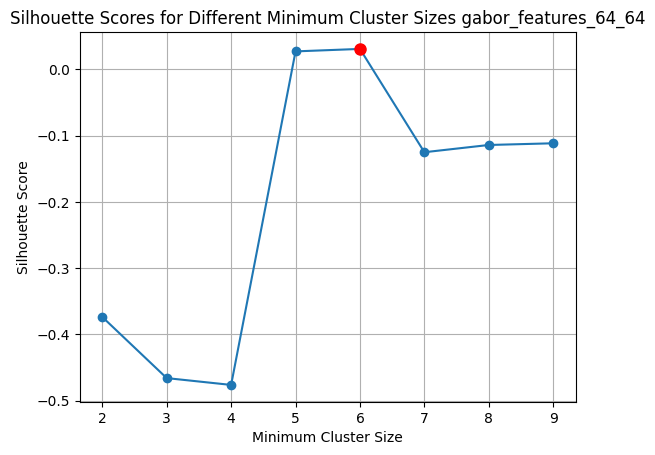

In [ ]:
hdbscan(dataframes)

**Best Features: lbp**

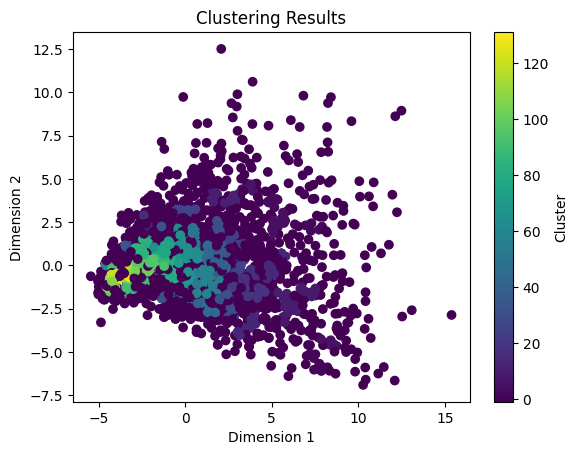

In [ ]:
import matplotlib.pyplot as plt
optimal_num_components = 2
best_min_cluster_size = 5
reduced_data, _ = reduce_dimensions_and_cluster(df2, optimal_num_components, best_min_cluster_size)
# Plot the reduced data with clusters
plt.scatter(reduced_data["Dimension 1"], reduced_data["Dimension 2"], c=reduced_data["Cluster"])
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Clustering Results")
plt.colorbar(label="Cluster")
plt.show()


**Select best PCA components for lbp features**

The maximum silhouette score is 0.4237145728320638 at Number of PCA Componnets 5


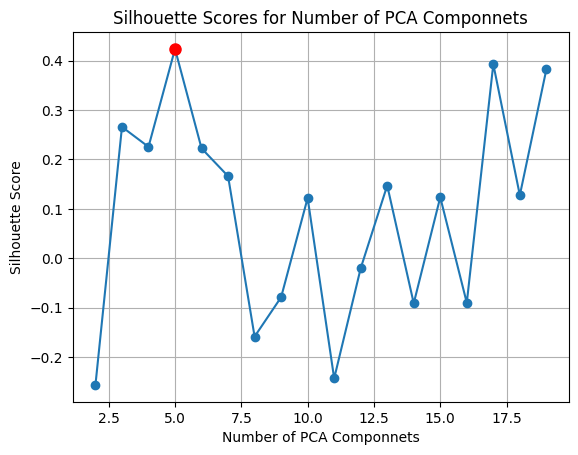

In [ ]:
# Example usage:
data = df2  # Replace with your actual dataframe
min_cluster_size = best_min_cluster_size
silhouette_scores = []
for n_components in range(2, 20):
  _, silhouette = reduce_dimensions_and_cluster(data, n_components, min_cluster_size)
  silhouette_scores.append(silhouette)

import matplotlib.pyplot as plt

min_cluster_sizes = range(2, 20)

# Find the maximum silhouette score and its corresponding minimum cluster size
max_silhouette = max(silhouette_scores)
max_idx = silhouette_scores.index(max_silhouette)
best_min_cluster_size = min_cluster_sizes[max_idx]

plt.plot(min_cluster_sizes, silhouette_scores, marker='o')
plt.xlabel('Number of PCA Componnets')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Number of PCA Componnets')
plt.grid(True)

# Mark the maximum silhouette score with a red dot
plt.plot(best_min_cluster_size, max_silhouette, marker='o', markersize=8, color='red')

# Print the maximum silhouette score
print(f"The maximum silhouette score is {max_silhouette} at Number of PCA Componnets {best_min_cluster_size}")

plt.show()

### BIRCH

In [ ]:
import pandas as pd
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score

def find_best_birch_clustering(dataframe, threshold_list, branching_factor_list):
    best_silhouette_score = -1
    best_threshold = None
    best_branching_factor = None
    best_clustered_df = None

    for threshold in threshold_list:
        for branching_factor in branching_factor_list:
            try:
              # Initialize BIRCH with the specified parameters
              birch = Birch(threshold=threshold, branching_factor=branching_factor)

              # Fit the BIRCH model on the data
              birch.fit(dataframe)

              # Predict the cluster labels for the data
              cluster_labels = birch.predict(dataframe)

              # Compute the Silhouette score
              silhouette_avg = silhouette_score(dataframe, cluster_labels)

              # Update the best scores and parameters if necessary
              if silhouette_avg > best_silhouette_score:
                  best_silhouette_score = silhouette_avg
                  best_threshold = threshold
                  best_branching_factor = branching_factor
                  best_clustered_df = dataframe.copy()
                  best_clustered_df['Cluster Label'] = cluster_labels

            except:
              pass

    # Return the best results
    return best_clustered_df, best_silhouette_score, best_threshold, best_branching_factor


In [ ]:

# Assuming you have a DataFrame named 'df' with high-dimensional data
def birch(dataframes):

  for df in dataframes:
    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Normalize the DataFrame
    normalized_df = scaler.fit_transform(df)

    # Convert the normalized array back to a DataFrame
    normalized_df = pd.DataFrame(normalized_df, columns=df.columns)

    # Print the normalized DataFrame


    # Specify the lists of threshold and branching_factor values to try
    threshold_list = [0.1, 0.3, 0.5, 0.7]
    branching_factor_list = [10, 20, 30, 40, 50]

    # Find the best BIRCH clustering parameters and compute Silhouette score
    best_clustered_df, best_silhouette_score, best_threshold, best_branching_factor = find_best_birch_clustering(normalized_df, threshold_list, branching_factor_list)

    # Display the modified dataframe with cluster labels
    #print(best_clustered_df)
    print('\nName of Features: ', df.name)
    # Display the best Silhouette score and corresponding parameters
    print("Best Silhouette score:", best_silhouette_score)
    print("Best threshold:", best_threshold)
    print("Best branching factor:", best_branching_factor)


In [ ]:
birch(dataframes)


Name of Features:  hist_features_64_64
Best Silhouette score: 0.1377217652732881
Best threshold: 0.7
Best branching factor: 50

Name of Features:  lbp_features_64_64
Best Silhouette score: 0.4191079379702569
Best threshold: 0.7
Best branching factor: 10

Name of Features:  glcm_features
Best Silhouette score: 0.7139869655768377
Best threshold: 0.3
Best branching factor: 10

Name of Features:  gabor_features_64_64
Best Silhouette score: 0.14952556738228934
Best threshold: 0.3
Best branching factor: 50
